In [1]:
import math
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from numpy import log
import time
from keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from keras.layers import Dense, LeakyReLU
from keras.activations import elu
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.layers import LeakyReLU, ELU
from arch import arch_model
from sklearn.preprocessing import StandardScaler
from keras.layers import GRU, Dense, Dropout
#importing necessary libraries
from math import log, exp
from datetime import datetime
from numpy import log, exp


In [2]:
class EuropeanOptionBS:
    def __init__(self, S, K, T, r, q, sigma, Type):
        self.S = S
        self.K = K
        self.T = T
        self.r = r
        self.q = q
        self.sigma = sigma
        self.Type = Type
        self.d1 = self.d1()
        self.d2 = self.d2()
        self.price = self.price()

    def d1(self):
        d1 = (math.log(self.S / self.K) +
              (self.r - self.q + 0.5 * (self.sigma ** 2)) * self.T) / \
             (self.sigma * math.sqrt(self.T))
        return d1

    def d2(self):
        d2 = self.d1 - self.sigma * math.sqrt(self.T)
        return d2

    def price(self):
        if self.Type == "Call":
            price = self.S * math.exp(-self.q * self.T) * norm.cdf(self.d1) - \
                    self.K * math.exp(-self.r * self.T) * norm.cdf(self.d2)
        if self.Type == "Put":
            price = self.K * math.exp(-self.r * self.T) * norm.cdf(-self.d2) - \
                    self.S * math.exp(-self.q * self.T) * norm.cdf(-self.d1)
        return price

# real data

In [3]:
r = 0.0516

In [4]:


# Function to process a single CSV file
def data_cleaning(file_path, maturity_date):
    df = pd.read_csv(file_path)
    
    columns = {"Price~" : "underlying_stockprice",'Last' : 'option_price'}
    df.rename(columns=columns,inplace=True)
    
    df = df[~df['Time'].str.contains('Downloaded', na=False)]
    column_to_convert = 'IV'  # Example column name
    if column_to_convert in df.columns:
        df[column_to_convert] = df[column_to_convert].str.rstrip('%').astype('float') / 100.0
        

    #df.replace({'\+': '', '%': ''}, regex=True, inplace=True)
    if df['Open Int'].dtype == object:
        #print(file_path)
        df['Open Int'] = df['Open Int'].str.replace(',', '').astype(float)
    df['Time'] = pd.to_datetime(df['Time'], format='%m/%d/%Y')
    
    

    for col in [ 'Open', 'High', 'Low', 'Change', '%Chg', 'Bid', 'Ask', 'Open Int', 'Delta', 
                'Gamma', 'Theta', 'Vega', 'Rho', 'Theo' ]:
        if col in df.columns:
            df.drop(col, axis=1, inplace=True)
    
    df.sort_values(by='Time', inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    df = df[df['underlying_stockprice'] > 0]
    r = 0.0516
    df['r'] = 0.0516
    # Calculating 'Days to Maturity' and adding the column
    df['Maturity'] = (maturity_date - df['Time']).dt.days 
    df['Maturity'] = df['Maturity'] / 252
    df['C/S'] = df['option_price'] / df['underlying_stockprice']
    #df['Log(C/S)'] = np.log(df['option_price'] / df['underlying_stockprice'])
    df['Monyness'] = df['underlying_stockprice'] / df['Strike']
    #df['Log_Forward_Moneyness'] = log(df['Strike'] / (df['Price~] * exp(r * (df['Maturity']))))
    df['K/S'] = df['Strike']/ df['underlying_stockprice']


    
    
    #df['BS/K'] = df.apply(lambda row: EuropeanOptionBS(
    #row['Price~'], row['Strike'], row['Maturity'], r, 0, row['IV'], "Call").price 
    #if row['Strike'] > 0 and row['Maturity'] > 0 and row['IV'] > 0 else float('nan'), axis=1)
        


      
    df = df[df['Volume'] != 0]
    df = df[df['option_price'] != 0]
    df = df[df['option_price'] >= 0.1]
    df = df[df['Maturity'] <= 2.4] 
    #df = df[df['Maturity'] >= 14/252] 
    df = df.dropna()
    #df = df[df['option_price'] >= df['underlying_stockprice'] - df['Strike'] * np.exp(-r * (df['Maturity']))]

    
    return df

In [5]:
# Defining the fixed maturity date
maturity_date = datetime(2024, 6, 21)

In [6]:
file_names_20240315 = [
    '20240315_10000.csv', '20240315_11000.csv', '20240315_12000.csv', 
    '20240315_13000.csv', '20240315_14000.csv', '20240315_15000.csv', 
    '20240315_15500.csv', '20240315_16000.csv', '20240315_16500.csv', 
    '20240315_17000.csv', '20240315_17500.csv', '20240315_18000.csv', 
    '20240315_18500.csv', '20240315_19000.csv', '20240315_19500.csv', 
    '20240315_20000.csv', '20240315_20500.csv', '20240315_21000.csv', 
    '20240315_21500.csv', '20240315_22000.csv', '20240315_22500.csv', 
    '20240315_23000.csv', '20240315_23500.csv', '20240315_24000.csv', 
    '20240315_24500.csv', '20240315_25000.csv', '20240315_25500.csv', 
    '20240315_26000.csv', '20240315_27000.csv', '20240315_28000.csv', 
    '20240315_29000.csv', '20240315_30000.csv', '20240315_31000.csv', 
    '20240315_32000.csv', '20240315_33000.csv', '20240315_34000.csv', 
    '20240315_35000.csv', '20240315_36000.csv', '20240315_37000.csv', 
    '20240315_38000.csv',  '20240315_40000.csv', 
    '20240315_41000.csv', '20240315_42000.csv',  
     '20240315_45000.csv'
]

In [7]:
file_names_20240419 = [
    '20240419_10000.csv', '20240419_11000.csv', '20240419_12000.csv', 
    '20240419_13000.csv', '20240419_14000.csv', '20240419_15000.csv', 
    '20240419_15500.csv', '20240419_16000.csv', '20240419_16500.csv', 
    '20240419_17000.csv', '20240419_17500.csv', '20240419_18000.csv', 
    '20240419_18500.csv', '20240419_19000.csv', '20240419_19500.csv', 
    '20240419_20000.csv', '20240419_20500.csv', '20240419_21000.csv', 
    '20240419_21500.csv', '20240419_22000.csv', '20240419_22500.csv', 
    '20240419_23000.csv', '20240419_23500.csv', '20240419_24000.csv', 
    '20240419_24500.csv', '20240419_25000.csv', '20240419_25500.csv', 
    '20240419_26000.csv', '20240419_27000.csv', '20240419_28000.csv', 
    '20240419_29000.csv', '20240419_30000.csv', '20240419_31000.csv', 
    '20240419_32000.csv', '20240419_33000.csv', '20240419_34000.csv', 
    '20240419_35000.csv', '20240419_36000.csv', '20240419_37000.csv', 
    '20240419_38000.csv', '20240419_39000.csv', '20240419_40000.csv', 
    '20240419_41000.csv', '20240419_42000.csv', '20240419_43000.csv', 
    '20240419_44000.csv', '20240419_45000.csv', '20240419_46000.csv', 
    '20240419_47000.csv', '20240419_48000.csv', '20240419_49000.csv'
]

In [8]:
file_names_20240503 = [
    '20240503_10000.csv', '20240503_11000.csv', '20240503_12000.csv', 
    '20240503_13000.csv', '20240503_14000.csv', '20240503_15000.csv', 
    '20240503_16000.csv', '20240503_17000.csv', '20240503_18000.csv', 
    '20240503_19000.csv', '20240503_20000.csv', '20240503_21000.csv', 
    '20240503_22000.csv', '20240503_23000.csv', '20240503_24000.csv', 
    '20240503_27000.csv', '20240503_28000.csv', '20240503_29000.csv', 
    '20240503_30000.csv', '20240503_31000.csv', '20240503_32000.csv', 
    '20240503_33000.csv', '20240503_34000.csv', '20240503_35000.csv'
]

In [13]:
csv_filenames = [
                    '100.csv', '110.csv', '120.csv', '130.csv', '140.csv', '160.csv', '170.csv', '180.csv',
                    '190.csv', '210.csv', '220.csv', '230.csv', '240.csv', '260.csv', '270.csv', '280.csv',
                    '290.csv', '310.csv', '320.csv', '330.csv', '340.csv', '360.csv', '370.csv', '380.csv',
                    '390.csv', '410.csv', '420.csv', '430.csv', '440.csv', '460.csv', '470.csv', '480.csv',
                    '490.csv', '510.csv', '520.csv', '530.csv', '540.csv', '105.csv', '115.csv', '135.csv',
                    '145.csv', '155.csv', '165.csv', '185.csv', '205.csv', '215.csv', '235.csv', '245.csv',
                    '255.csv', '265.csv', '285.csv', '295.csv', '305.csv', '50.csv',  '90.csv' , '345.csv',
                    '125.csv', '750.csv', '150.csv', '200.csv', '250.csv', '300.csv', '350.csv', '400.csv',
                    '345.csv', '500.csv', '550.csv', '600.csv', '650.csv', '700.csv', '315.csv', '335.csv',
                    '355.csv', '175.csv', '195.csv', '225.csv', '275.csv', '325.csv', '800.csv', '850.csv', 
                    '900.csv', '950.csv', '1000.csv', '1050.csv', '1100.csv', '1150.csv', '1200.csv', 
                    '1300.csv', '1350.csv', '1400.csv', '1450.csv', '1500.csv', '1550.csv', '1250.csv',
                    '1600.csv', '1700.csv', '1800.csv', '1900.csv', '2000.csv', '2100.csv', '2200.csv',
             
                ]  

In [9]:
file_names_20240517 = [
    "20240517_36500.csv","20240517_37000.csv","20240517_37500.csv","20240517_38000.csv","20240517_38500.csv",
    "20240517_39000.csv","20240517_39500.csv","20240517_41000.csv","20240517_42000.csv","20240517_43000.csv",
    "20240517_44000.csv","20240517_46000.csv","20240517_47000.csv","20240517_48000.csv","20240517_31000.csv",
    "20240517_32000.csv","20240517_33000.csv","20240517_34000.csv","20240517_18500.csv","20240517_19500.csv",
    "20240517_20500.csv","20240517_21500.csv","20240517_22500.csv","20240517_23500.csv","20240517_24500.csv",
    "20240517_25500.csv","20240517_26500.csv","20240517_27500.csv","20240517_28500.csv","20240517_29500.csv",
    "20240517_30500.csv","20240517_31500.csv","20240517_32500.csv","20240517_34500.csv","20240517_35500.csv",
    "20240517_36000.csv","20240517_29000.csv","20240517_30000.csv","20240517_35000.csv","20240517_40000.csv",
    "20240517_45000.csv","20240517_33500.csv","20240517_10500.csv","20240517_11000.csv","20240517_11500.csv",
    "20240517_12000.csv","20240517_12500.csv","20240517_13000.csv","20240517_13500.csv","20240517_14000.csv",
    "20240517_14500.csv","20240517_15500.csv","20240517_16500.csv","20240517_17500.csv","20240517_10000.csv",
    "20240517_15000.csv","20240517_16000.csv","20240517_17000.csv","20240517_18000.csv","20240517_19000.csv",
    "20240517_20000.csv","20240517_21000.csv","20240517_22000.csv","20240517_23000.csv","20240517_24000.csv",
    "20240517_25000.csv","20240517_26000.csv","20240517_27000.csv","20240517_28000.csv"
]

In [10]:


# Change the file path to the location where your CSV file is stored
file_path = '50.csv'

# Read the CSV file
df1 = pd.read_csv(file_path)

In [38]:
print(len(csv_filenames))

101


In [39]:
df1.columns

Index(['Time', 'Open', 'High', 'Low', 'Last', 'Change', '%Chg', 'Volume',
       'Open Int', 'IV', 'Delta', 'Gamma', 'Theta', 'Vega', 'Rho', 'Theo',
       'Price~', 'Strike', 'Bid', 'Ask'],
      dtype='object')

In [40]:
df1.to_csv('df1.csv', index=False)

In [41]:
df1.head()

Time    Open    High     Low    Last  Change    %Chg  Volume  \
0  06/11/2024    0.00    0.00    0.00    0.00    0.00   0.00%     0.0   
1  06/10/2024    0.00    0.00    0.00    0.00    0.00   0.00%     0.0   
2  06/07/2024    0.00    0.00    0.00    0.00    0.00   0.00%     0.0   
3  06/06/2024  123.68  123.68  123.68  123.68   -0.32  -0.26%     1.0   
4  06/05/2024  124.00  124.00  124.00  124.00    0.00   0.00%   351.0   

   Open Int       IV     Delta     Gamma     Theta      Vega       Rho  \
0    1516.0  317.36%  0.994941  0.000165 -0.071620  0.004063  0.013400   
1    1516.0  299.87%  0.997115  0.000102 -0.045315  0.002542  0.013517   
2    1516.0  166.12%  0.999987  0.000001 -0.007413  0.000020  0.017774   
3    1516.0  246.20%  0.997995  0.000074 -0.026706  0.002215  0.018980   
4    1615.0  207.37%  0.999300  0.000033 -0.013219  0.000861  0.020446   

      Theo    Price~  Strike     Bid     Ask  
0  118.200  167.9601    50.0  117.75  118.20  
1  123.950  173.7900    50.0  123.55  124.35  
2  127.575  177.4800    50.0  127.30  127.85  
3  128.100  177.9400    50.0  127.80  128.40  
4  125.125  175.0000    50.0  124.85  125.40

In [14]:

maturity_date = datetime(2024, 6, 21)
# Dictionary to hold the processed DataFrames
processed_2024621 = {}

# Looping through the CSV filenames
for csv_filename in csv_filenames:
    # Processing each CSV file and storing the result in the dictionary
    df_name = 'df' + csv_filename.split('.')[0]
    
    processed_2024621[df_name] = data_cleaning(csv_filename,maturity_date)

In [15]:
# Process each CSV file and create a DataFrame variable for each
for csv_filename in csv_filenames:

    df = data_cleaning(csv_filename,maturity_date)
    df_name = 'df' + csv_filename.split('.')[0]
    globals()[df_name] = df

In [16]:

maturity_date = datetime(2024, 5, 17)
# Dictionary to hold the processed DataFrames
processed_2024517 = {}

# Looping through the CSV filenames
for csv_filename in file_names_20240517:
    # Processing each CSV file and storing the result in the dictionary
    df_name = 'df' + csv_filename.split('.')[0]
    
    processed_2024517[df_name] = data_cleaning(csv_filename,maturity_date)

In [17]:
# Process each CSV file and create a DataFrame variable for each
for csv_filename in file_names_20240517:

    df = data_cleaning(csv_filename,maturity_date)
    df_name = 'df' + csv_filename.split('.')[0]
    globals()[df_name] = df

In [18]:
maturity_date = datetime(2024, 4, 19)
processed_2024419 = {}

# Looping through the CSV filenames
for csv_filename in file_names_20240419:
    # Processing each CSV file and storing the result in the dictionary
    df_name = 'df' + csv_filename.split('.')[0]
    
    processed_2024419[df_name] = data_cleaning(csv_filename,maturity_date)

In [19]:
# Process each CSV file and create a DataFrame variable for each
for csv_filename in file_names_20240419:

    df = data_cleaning(csv_filename,maturity_date)
    df_name = 'df' + csv_filename.split('.')[0]
    globals()[df_name] = df

In [20]:
maturity_date = datetime(2024, 5, 3)
processed_2024503 = {}

# Looping through the CSV filenames
for csv_filename in file_names_20240503:
    # Processing each CSV file and storing the result in the dictionary
    df_name = 'df' + csv_filename.split('.')[0]
    
    processed_2024503[df_name] = data_cleaning(csv_filename,maturity_date)

In [21]:
# Process each CSV file and create a DataFrame variable for each
for csv_filename in file_names_20240503:

    df = data_cleaning(csv_filename,maturity_date)
    df_name = 'df' + csv_filename.split('.')[0]
    globals()[df_name] = df

In [22]:

maturity_date = datetime(2024, 3, 15)
processed_20240315 = {}

# Looping through the CSV filenames
for csv_filename in file_names_20240315:
    # Processing each CSV file and storing the result in the dictionary
    df_name = 'df' + csv_filename.split('.')[0]
    
    processed_20240315[df_name] = data_cleaning(csv_filename,maturity_date)

In [23]:
# Process each CSV file and create a DataFrame variable for each
for csv_filename in file_names_20240315:

    df = data_cleaning(csv_filename,maturity_date)
    df_name = 'df' + csv_filename.split('.')[0]
    globals()[df_name] = df

In [25]:
df20240517_25000.head()

Time  option_price  Volume      IV  underlying_stockprice  Strike  \
0 2023-09-26         40.64    79.0  0.5107                 244.12   250.0   
1 2023-09-27         38.60   308.0  0.5116                 240.50   250.0   
2 2023-09-28         41.00    16.0  0.5108                 246.38   250.0   
3 2023-09-29         44.15    20.0  0.5123                 250.22   250.0   
4 2023-10-02         44.40    24.0  0.5150                 251.60   250.0   

   Maturity       C/S  Monyness       K/S  
0  0.928571  0.166476   0.97648  1.024087  
1  0.924603  0.160499   0.96200  1.039501  
2  0.920635  0.166410   0.98552  1.014693  
3  0.916667  0.176445   1.00088  0.999121  
4  0.904762  0.176471   1.00640  0.993641

In [24]:
combined_df1 = pd.concat(processed_2024419.values(), ignore_index=True)

In [25]:
combined_df2 = pd.concat(processed_2024621.values(), ignore_index=True)

In [26]:
combined_df3 = pd.concat(processed_2024503.values(), ignore_index=True)

In [27]:
combined_df4 = pd.concat(processed_2024517.values(), ignore_index=True)

In [28]:
combined_test =  pd.concat(processed_20240315.values(), ignore_index=True)

In [29]:
combined_df  = pd.concat([combined_df1, combined_df2, combined_df3, combined_df4], ignore_index=True)

In [29]:
combined_df.shape

(31828, 11)

In [30]:
combined_df.shape

(31828, 11)

In [30]:
data = combined_df.copy()

In [31]:
# Sorting the combined DataFrame by 'Exchange Date'
data.sort_values(by='Time', inplace=True)
data.reset_index(drop=True, inplace=True)

In [32]:
# Calculate log returns of the underlying stock prices
data['log_return'] = np.log(data['underlying_stockprice'] / data['underlying_stockprice'].shift(1))
data = data.dropna()



# Fit a GARCH(1,1) model
returns = data['log_return'].values
model = arch_model(returns, vol='Garch', p=1, q=1)
garch_fit = model.fit(disp='off')
data['cond_vol'] = garch_fit.conditional_volatility

C:\Users\spin 3\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.616e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\spin 3\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [35]:
nan_counts = data.isna().sum()

print(nan_counts)

Time                     0
option_price             0
Volume                   0
IV                       0
underlying_stockprice    0
Strike                   0
r                        0
Maturity                 0
C/S                      0
Monyness                 0
K/S                      0
log_return               0
cond_vol                 0
dtype: int64


In [33]:
data.describe()

Time  option_price         Volume  \
count                          31827  31827.000000   31827.000000   
mean   2023-11-02 13:47:01.566594560     26.766472     494.989851   
min              2022-10-26 00:00:00      0.100000       1.000000   
25%              2023-08-23 00:00:00      2.500000       6.000000   
50%              2023-12-05 00:00:00     13.650000      29.000000   
75%              2024-02-20 00:00:00     40.550000     150.000000   
max              2024-06-11 00:00:00    232.000000  224714.000000   
std                              NaN     32.430714    4249.107492   

                 IV  underlying_stockprice        Strike             r  \
count  31827.000000           31827.000000  31827.000000  3.182700e+04   
mean       0.552730             208.355209    285.390235  5.160000e-02   
min        0.111900             108.100000     50.000000  5.160000e-02   
25%        0.488900             179.830000    190.000000  5.160000e-02   
50%        0.520700             202.640000    260.000000  5.160000e-02   
75%        0.575000             239.740000    350.000000  5.160000e-02   
max        7.632400             293.340000    750.000000  5.160000e-02   
std        0.190091              36.174820    129.380676  6.807162e-15   

           Maturity           C/S      Monyness           K/S    log_return  \
count  31827.000000  31827.000000  31827.000000  31827.000000  31827.000000   
mean       0.839542      0.125124      0.874560      1.391830     -0.000009   
min        0.000000      0.000457      0.144133      0.177004     -0.130590   
25%        0.373016      0.012437      0.591619      0.939236      0.000000   
50%        0.674603      0.065394      0.788825      1.267708      0.000000   
75%        1.202381      0.195103      1.064696      1.690277      0.000000   
max        2.396825      0.857955      5.649600      6.938020      0.142427   
std        0.610085      0.145518      0.425017      0.660341      0.004020   

           cond_vol  
count  31827.000000  
mean       0.004011  
min        0.002892  
25%        0.003981  
50%        0.003981  
75%        0.003981  
max        0.014789  
std        0.000270

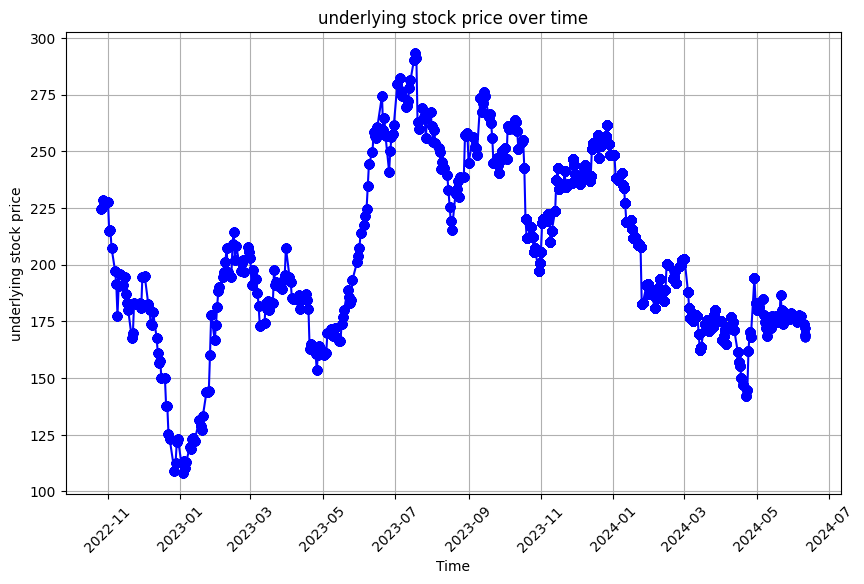

In [34]:
import matplotlib.pyplot as plt

# Plotting the option_price column
plt.figure(figsize=(10, 6))
plt.plot(data['Time'], data['underlying_stockprice'], marker='o', linestyle='-', color='b')
plt.xlabel('Time')
plt.ylabel('underlying stock price')
plt.title('underlying stock price over time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

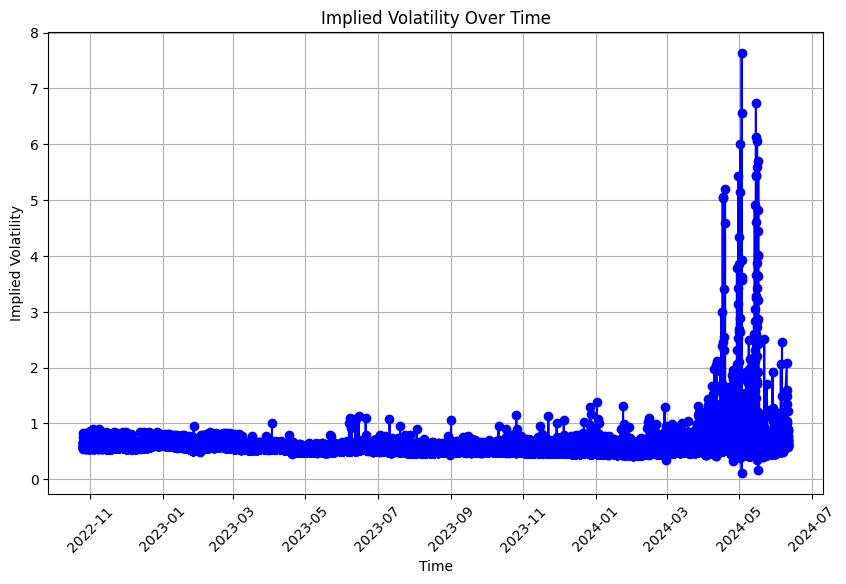

In [35]:
import matplotlib.pyplot as plt

# Plotting the option_price column
plt.figure(figsize=(10, 6))
plt.plot(data['Time'], data['IV'], marker='o', linestyle='-', color='b')
plt.xlabel('Time')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

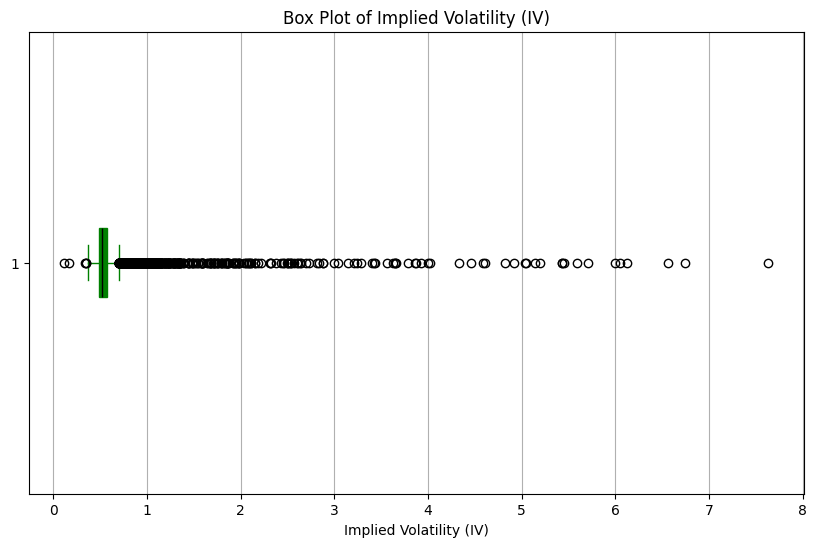

In [36]:
# Plotting a box plot for Implied Volatility (IV) to show its distribution
plt.figure(figsize=(10, 6))
plt.boxplot(data['IV'], vert=False, patch_artist=True, boxprops=dict(facecolor='g', color='g'), whiskerprops=dict(color='g'), capprops=dict(color='g'), medianprops=dict(color='black'))
plt.xlabel('Implied Volatility (IV)')
plt.title('Box Plot of Implied Volatility (IV)')
plt.grid(True, axis='x')
plt.show()

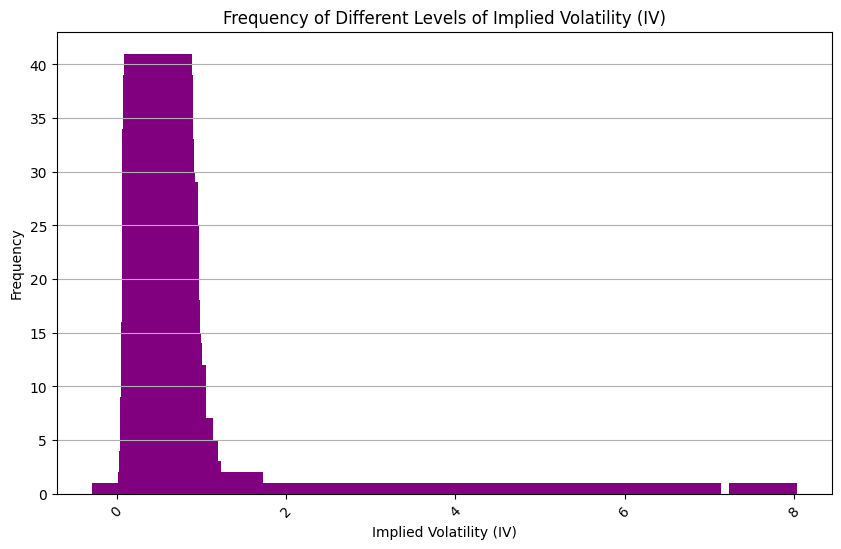

In [37]:
# Plotting a bar chart to show the frequency of different levels of Implied Volatility (IV)
plt.figure(figsize=(10, 6))
iv_counts = data['IV'].value_counts().sort_index()
plt.bar(iv_counts.index, iv_counts.values, color='purple')
plt.xlabel('Implied Volatility (IV)')
plt.ylabel('Frequency')
plt.title('Frequency of Different Levels of Implied Volatility (IV)')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.show()


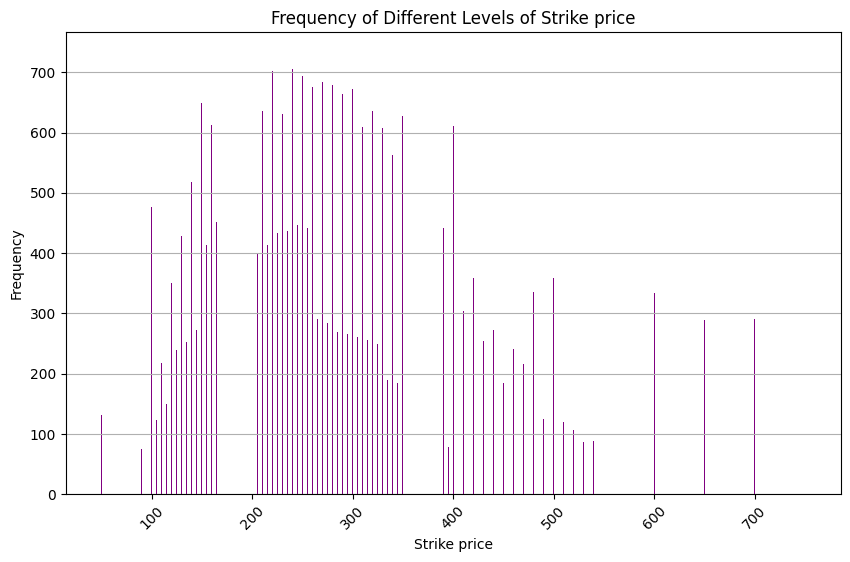

In [38]:
# Plotting a bar chart to show the frequency of different levels of Implied Volatility (IV)
plt.figure(figsize=(10, 6))
iv_counts = data['Strike'].value_counts().sort_index()
plt.bar(iv_counts.index, iv_counts.values, color='purple')
plt.xlabel('Strike price')
plt.ylabel('Frequency')
plt.title('Frequency of Different Levels of Strike price')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.show()

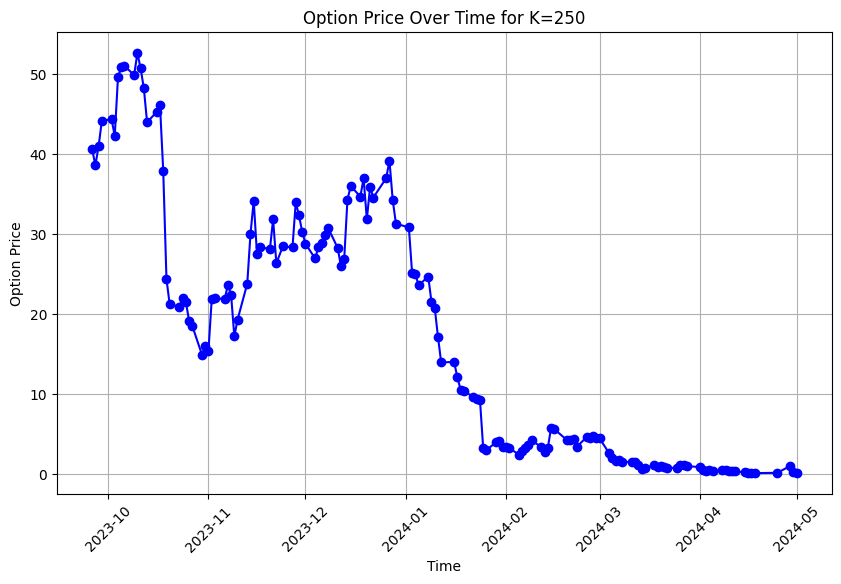

In [75]:
import matplotlib.pyplot as plt

# Plotting the option_price column
plt.figure(figsize=(10, 6))
plt.plot(df20240517_25000['Time'],df20240517_25000['option_price'], marker='o', linestyle='-', color='b')
plt.xlabel('Time')
plt.ylabel('Option Price')
plt.title('Option Price Over Time for K=250')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

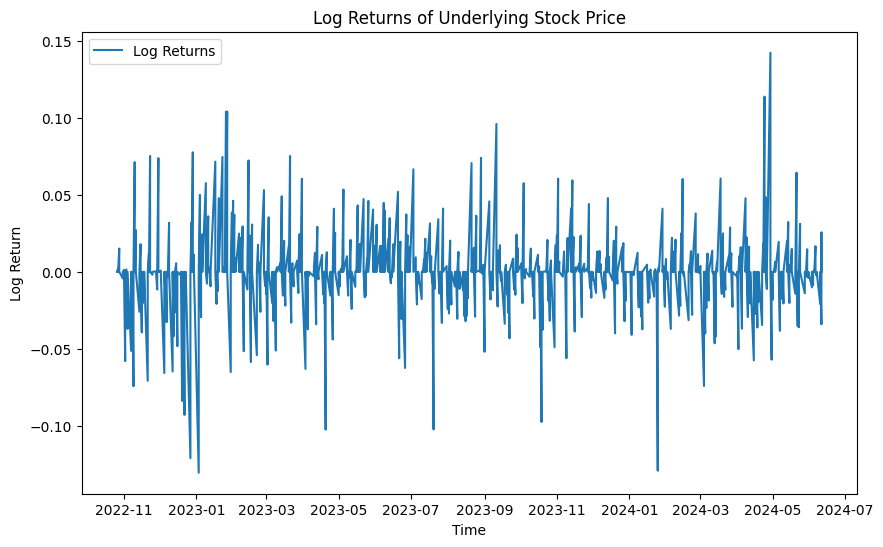

C:\Users\spin 3\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.618e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                129484.
Distribution:                  Normal   AIC:                          -258960.
Method:            Maximum Likelihood   BIC:                          -258926.
                                        No. Observations:                31650
Date:                Wed, Jul 03 2024   Df Residuals:                    31649
Time:                        13:58:24   Df Model:                            1
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
mu         -8.6584e-06  7.357e-08   -117.696     

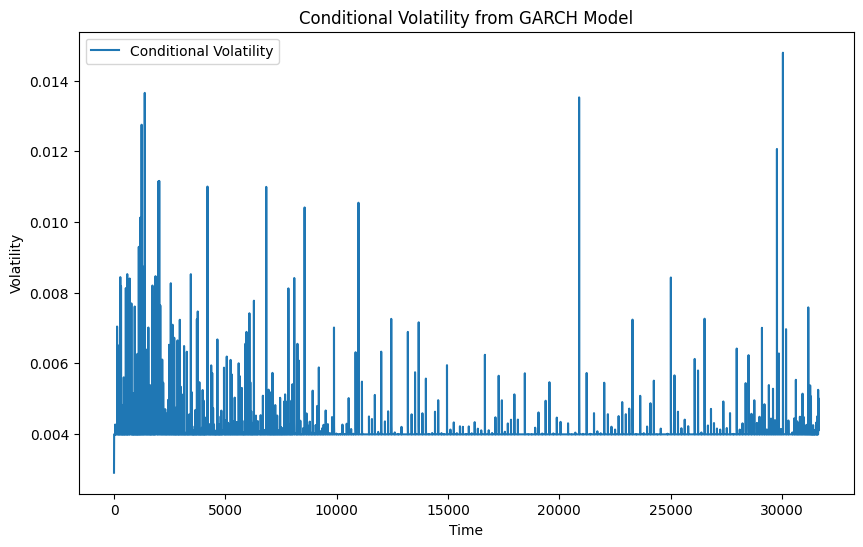

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model



# Calculate log returns of the underlying stock prices
data['log_return'] = np.log(data['underlying_stockprice'] / data['underlying_stockprice'].shift(1))
data = data.dropna()

# Plot the log returns
plt.figure(figsize=(10, 6))
plt.plot(data['Time'], data['log_return'], label='Log Returns')
plt.title('Log Returns of Underlying Stock Price')
plt.xlabel('Time')
plt.ylabel('Log Return')
plt.legend()
plt.show()

# Fit a GARCH(1,1) model
returns = data['log_return'].values
model = arch_model(returns, vol='Garch', p=1, q=1)
garch_fit = model.fit(disp='off')

# Summarize the GARCH model fit
print(garch_fit.summary())

# Plot the conditional volatility
plt.figure(figsize=(10, 6))
plt.plot(garch_fit.conditional_volatility, label='Conditional Volatility')
plt.title('Conditional Volatility from GARCH Model')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()

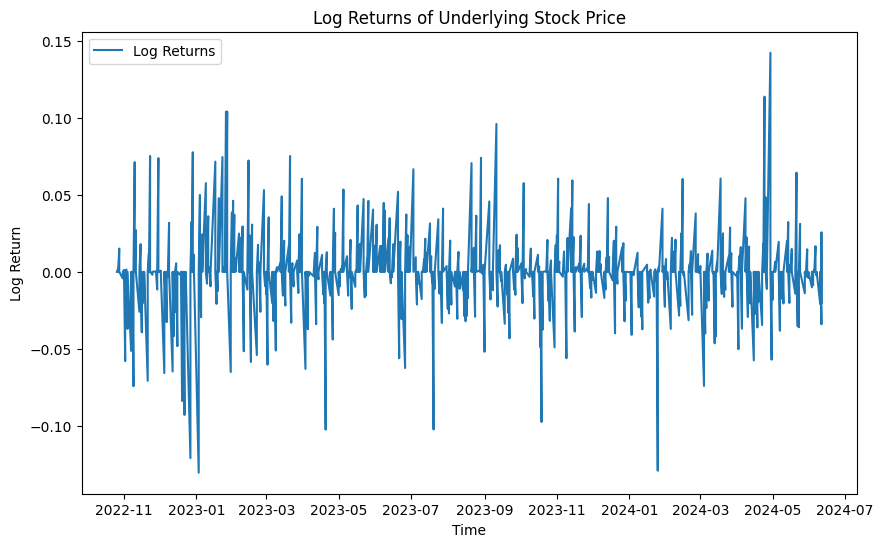

In [42]:
# Plot the log returns
plt.figure(figsize=(10, 6))
plt.plot(data['Time'], data['log_return'], label='Log Returns')
plt.title('Log Returns of Underlying Stock Price')
plt.xlabel('Time')
plt.ylabel('Log Return')
plt.legend()
plt.show()

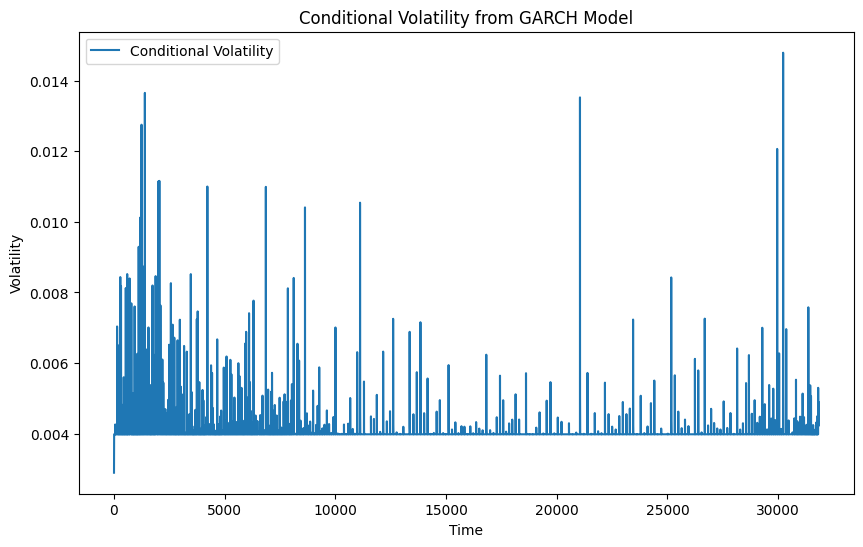

In [106]:
# Plot the conditional volatility
plt.figure(figsize=(10, 6))
plt.plot(data['cond_vol'], label='Conditional Volatility')
plt.title('Conditional Volatility from GARCH Model')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()

# ML

In [36]:
data.to_csv('combine.csv', index=False)

In [605]:
data.head()

Time  option_price  Volume      IV  underlying_stockprice  Strike  \
0 2022-09-30         50.10    64.0  0.5835                 265.25   400.0   
1 2022-09-30        185.45    50.0  0.7525                 265.25   100.0   
2 2022-09-30         19.73    14.0  0.5717                 265.25   650.0   
3 2022-09-30        121.00    17.0  0.6616                 265.25   200.0   
4 2022-09-30         33.45   402.0  0.5735                 265.25   500.0   

   Maturity       C/S  Monyness       K/S       r  
0       2.5  0.188878  0.663125  1.508011  0.0516  
1       2.5  0.699152  2.652500  0.377003  0.0516  
2       2.5  0.074383  0.408077  2.450518  0.0516  
3       2.5  0.456173  1.326250  0.754006  0.0516  
4       2.5  0.126107  0.530500  1.885014  0.0516

In [108]:
data['r'] = r

In [219]:

# Define the feature columns and the target column
feature_columns = [ 'IV', 'K/S', 'Maturity','r']
target_column = 'C/S'

# Split the data into features and target
X = data[feature_columns]
y = data[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Display the shapes of the resulting datasets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((25461, 4), (6366, 4), (25461,), (6366,))

In [112]:
xx_test =  X_test

In [220]:



# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



In [221]:
model_ML = Sequential()

model_ML.add(Dense(30, input_dim=4))
model_ML.add(LeakyReLU())
model_ML.add(Dense(60))
model_ML.add(ELU())
model_ML.add(Dense(90))
model_ML.add(LeakyReLU())
model_ML.add(Dense(1))

C:\Users\spin 3\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [115]:
ML_prediction_start_time = time.time()


In [222]:
model_ML.compile(loss='mean_squared_error', optimizer='adam')

In [223]:
history_model_ML = model_ML.fit(X_train, y_train, epochs=100, batch_size=15, verbose=0)

In [118]:
ML_prediction_end_time = time.time()

In [116]:
ML_prediction_time = ML_prediction_end_time - ML_prediction_start_time
print(ML_prediction_time)

213.38647603988647


In [119]:
final_loss = history_model_ML.history['loss'][-1]
print(f"   Last log loss: {final_loss:.10f}")

   Last log loss: 0.0000377131


In [119]:
y_pred_ML = model_ML.predict(X_test)
rmse_ML = np.sqrt(mean_squared_error(y_test,y_pred_ML))
mae_ML = mean_absolute_error(y_test, y_pred_ML)
mse_ML = mean_squared_error(y_test,y_pred_ML)
print(f"   MSA: {rmse_ML:.10f}")
print(f"   MAE: {mae_ML :.10f}")
print(f"   MSE: {mse_ML :.10f}") 
print("r-squared = {:.3f}".format(r2_score(y_test, y_pred_ML)))

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
   MSA: 0.0056024519
   MAE: 0.0028948294
   MSE: 0.0000313875
r-squared = 0.999


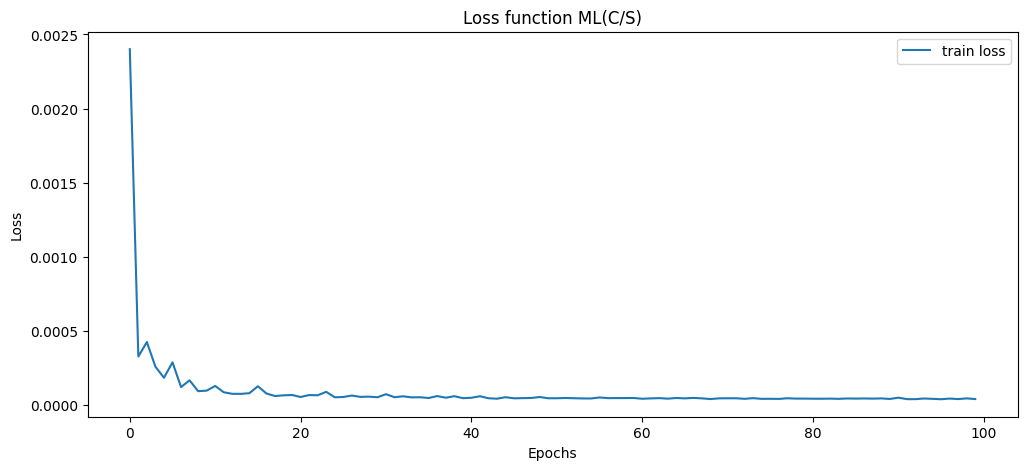

In [219]:
fig, ax = plt.subplots(figsize=(12, 5))
x_x = history_model_ML.history["loss"]
ax.plot(history_model_ML.history["loss"], label="train loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Loss function ML(C/S)')
#ax.plot(history.history["accuracy"], label="train accuracy")
#ax.plot(history.history["val_loss"], label="validation loss")
#ax.plot(history.history["val_accuracy"], label="validation accuracy")
ax.legend()

In [216]:
if np.any(y_pred_ML == 0):
    print("There are zeros in y_pred")
else:
    print("There are no zeros in y_pred")

# Check if there are any zeros in y_test
if np.any(y_test == 0):
    print("There are zeros in y_test")
else:
    print("There are no zeros in y_test")

There are no zeros in y_pred
There are no zeros in y_test


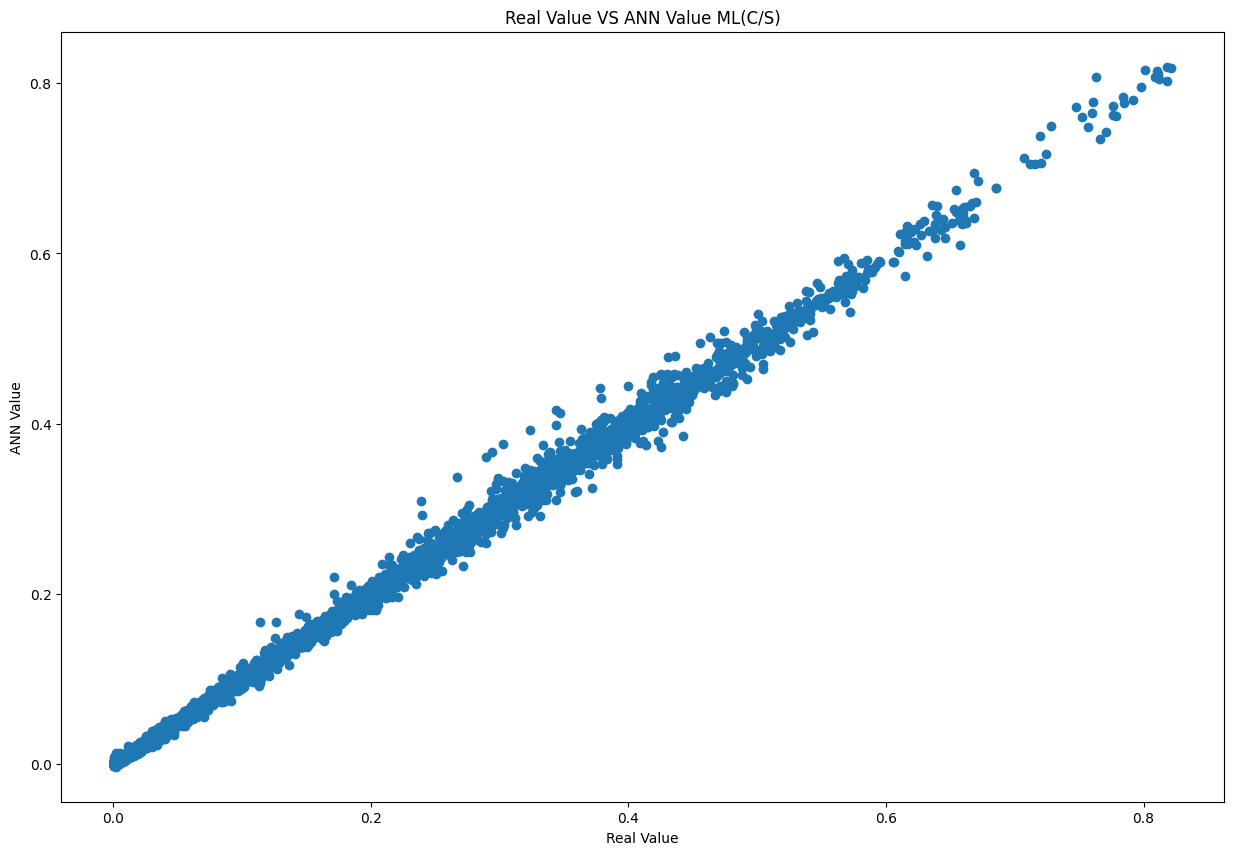

In [218]:

# Comparison of real values and predictions on the test dataset
plt.figure(figsize=(15, 10))
plt.scatter(y_test, y_pred_ML)
plt.xlabel("Real Value")
plt.ylabel("ANN Value")
plt.annotate("r-squared = {:.3f}".format(r2_score(y_test, y_pred_ML)), (20, 1), size=15)
plt.title('Real Value VS ANN Value ML(C/S)')
plt.show()

In [120]:
# Resetting the indices to ensure alignment
y_test = y_test.reset_index(drop=True)
y_pred_ML = pd.Series(y_pred_ML.flatten(), name='Predictions')

In [121]:

#frac_ML = pd.DataFrame({'Actual':y_test, 'Predicted': y_pred_ML})
# Combine them into a DataFrame
frac_ML = pd.DataFrame({'Actual':(y_test), 'Predicted': (y_pred_ML)})

# Save the DataFrame to a CSV file
frac_ML.to_csv('frac_ML.csv', index=False)

In [122]:
nan_counts = frac_ML.isna().sum()

print(nan_counts)


Actual       0
Predicted    0
dtype: int64


In [123]:
# Drop rows with NaN values
frac_ML = frac_ML.dropna()

# Reset index (optional)
frac_ML = frac_ML.reset_index(drop=True)

fractions statistics
Min: -2.8935690373182297
Max: 13.273895212316084
Mean: 0.05687898460300629
Std: 0.35264279104070695


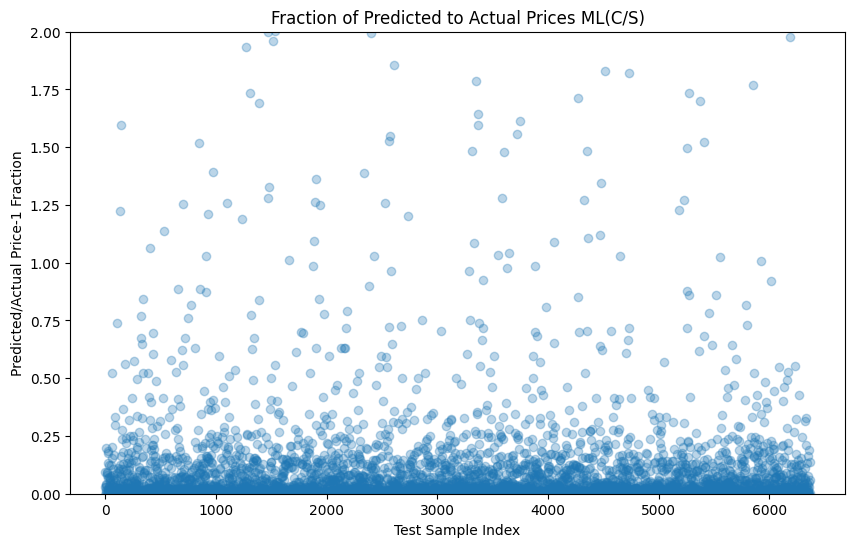

In [124]:


y_testf = frac_ML['Actual'].values
y_predf = frac_ML['Predicted'].values

# Calculate the fractions
fractionsf = y_predf / y_testf-1

# Print statistics for fractions
print("fractions statistics")
print("Min:", np.min(fractionsf))
print("Max:", np.max(fractionsf))
print("Mean:", np.mean(fractionsf))
print("Std:", np.std(fractionsf))

# Plot the fractions
plt.figure(figsize=(10, 6))
plt.plot(fractionsf, 'o', alpha=0.3)
plt.xlabel('Test Sample Index')
plt.ylabel('Predicted/Actual Price-1 Fraction')
plt.title('Fraction of Predicted to Actual Prices ML(C/S)')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

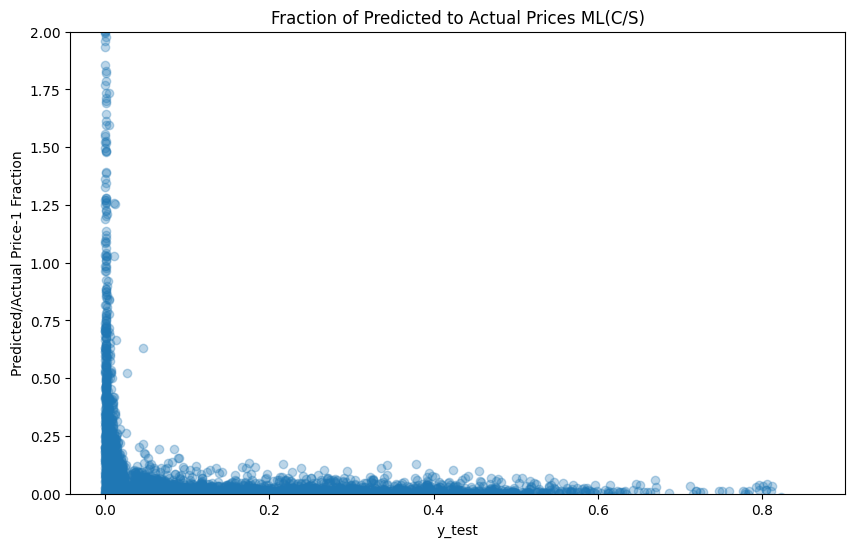

In [128]:


y_testf = frac_ML['Actual'].values
y_predf = frac_ML['Predicted'].values

# Calculate the fractions
fractionsf = y_predf / y_testf-1



# Plot the fractions
plt.figure(figsize=(10, 6))
plt.plot( y_testf,fractionsf, 'o', alpha=0.3)
plt.xlabel('y_test')
plt.ylabel('Predicted/Actual Price-1 Fraction')
plt.title('Fraction of Predicted to Actual Prices ML(C/S)')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

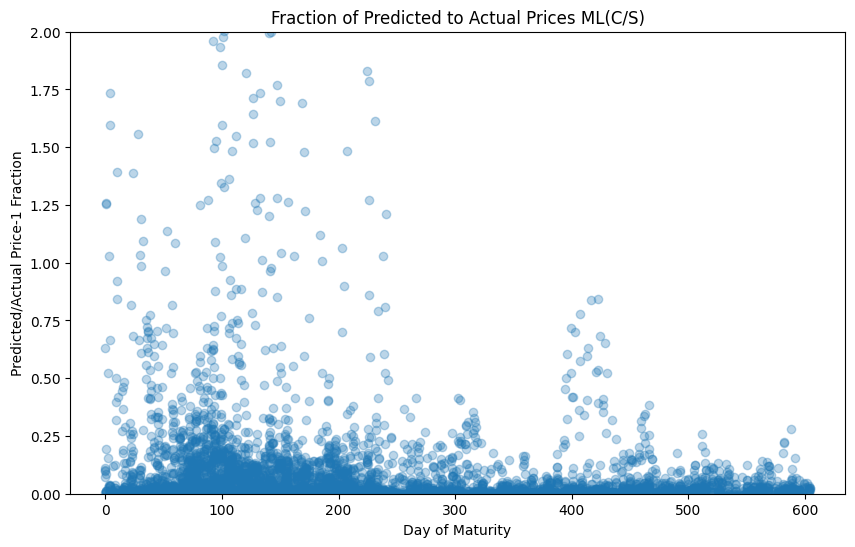

In [157]:


y_testf = frac_ML['Actual'].values
y_predf = frac_ML['Predicted'].values

# Calculate the fractions
fractionsf = y_predf / y_testf-1



# Plot the fractions
plt.figure(figsize=(10, 6))
plt.plot(X_test["Maturity"]*252,fractionsf, 'o', alpha=0.3)
plt.xlabel('Day of Maturity')
plt.ylabel('Predicted/Actual Price-1 Fraction')
plt.title('Fraction of Predicted to Actual Prices ML(C/S)')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

In [227]:

#frac_ML = pd.DataFrame({'Actual':y_test, 'Predicted': y_pred_ML})
# Combine them into a DataFrame
frac_ML = pd.DataFrame({'Actual':np.log(y_test), 'Predicted': np.log(y_pred_ML)})

# Save the DataFrame to a CSV file
frac_ML.to_csv('frac_ML.csv', index=False)


In [229]:
# Drop rows with NaN values
frac_ML = frac_ML.dropna()

# Reset index (optional)
frac_ML = frac_ML.reset_index(drop=True)

fractions statistics
Min: -0.33219612151550304
Max: 0.7357150575495592
Mean: 0.002965923076437756
Std: 0.04706589942015397


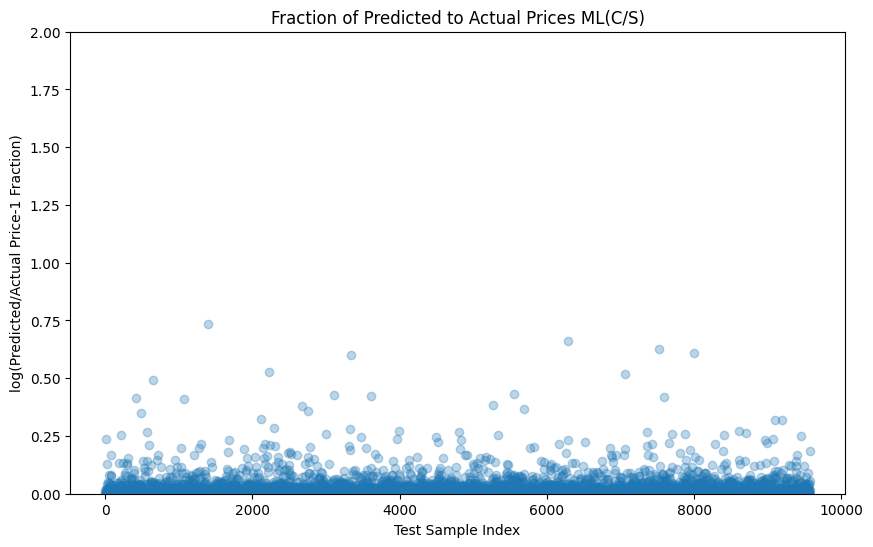

In [230]:


y_testf = frac_ML['Actual'].values
y_predf = frac_ML['Predicted'].values

# Calculate the fractions
fractionsf = y_predf / y_testf-1

# Print statistics for fractions
print("fractions statistics")
print("Min:", np.min(fractionsf))
print("Max:", np.max(fractionsf))
print("Mean:", np.mean(fractionsf))
print("Std:", np.std(fractionsf))

# Plot the fractions
plt.figure(figsize=(10, 6))
plt.plot(fractionsf, 'o', alpha=0.3)
plt.xlabel('Test Sample Index')
plt.ylabel('log(Predicted/Actual Price-1 Fraction)')
plt.title('Fraction of Predicted to Actual Prices ML(C/S)')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

# log ml

In [79]:
feature_columns = [ 'IV', 'K/S', 'Maturity','r']
target_column = 'C/S'

In [80]:
# Split the data into features and target
X = data[feature_columns]
y = log(data[target_column])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Display the shapes of the resulting datasets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((25461, 4), (6366, 4), (25461,), (6366,))

In [81]:
nan_counts = y.isna().sum()

print(nan_counts)

0


In [82]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [83]:
model_ML_log = Sequential()

model_ML_log.add(Dense(30, input_dim=4))
model_ML_log.add(LeakyReLU())
model_ML_log.add(Dense(60))
model_ML_log.add(ELU())
model_ML_log.add(Dense(90))
model_ML_log.add(LeakyReLU())
model_ML_log.add(Dense(1))

C:\Users\spin 3\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [84]:
ML_prediction_start_time = time.time()

In [85]:
model_ML_log.compile(loss='mean_squared_error', optimizer='adam')

In [86]:
history_model_ML_log = model_ML_log.fit(X_train, y_train, epochs=100, batch_size=15, verbose=0)

In [186]:
ML_prediction_end_time = time.time()

In [187]:
ML_prediction_time = ML_prediction_end_time - ML_prediction_start_time
print(ML_prediction_time)

212.19140315055847


In [188]:
final_loss = history_model_ML_log.history['loss'][-1]
print(f"   Last log loss log(c/s): {final_loss:.10f}")

   Last log loss log(c/s): 0.0045835441


In [189]:
y_pred_ML_log = model_ML_log.predict(X_test)
rmse_ML = np.sqrt(mean_squared_error(y_test,y_pred_ML_log))
mae_ML = mean_absolute_error(y_test, y_pred_ML_log)
mse_ML = mean_squared_error(y_test,y_pred_ML_log)
print(f"   MSA log(c/s): {rmse_ML:.10f}")
print(f"   MAE log(c/s): {mae_ML :.10f}")
print(f"   MSE log(c/s): {mse_ML :.10f}") 
print("r-squared = {:.3f}".format(r2_score(y_test, y_pred_ML_log)))

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
   MSA log(c/s): 0.0541997443
   MAE log(c/s): 0.0310080658
   MSE log(c/s): 0.0029376123
r-squared = 0.999


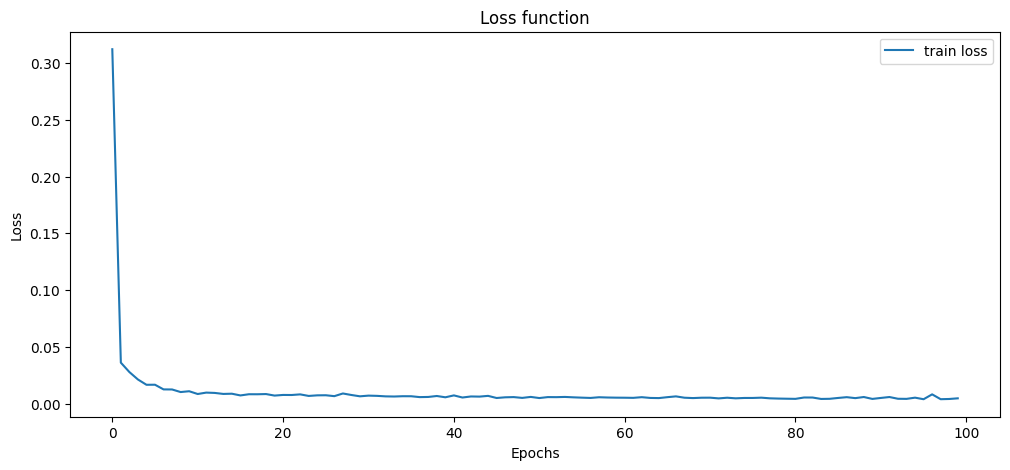

In [190]:
fig, ax = plt.subplots(figsize=(12, 5))
x_x = history_model_ML_log.history["loss"]
ax.plot(history_model_ML_log.history["loss"], label="train loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Loss function')
#ax.plot(history.history["accuracy"], label="train accuracy")
#ax.plot(history.history["val_loss"], label="validation loss")
#ax.plot(history.history["val_accuracy"], label="validation accuracy")
ax.legend()

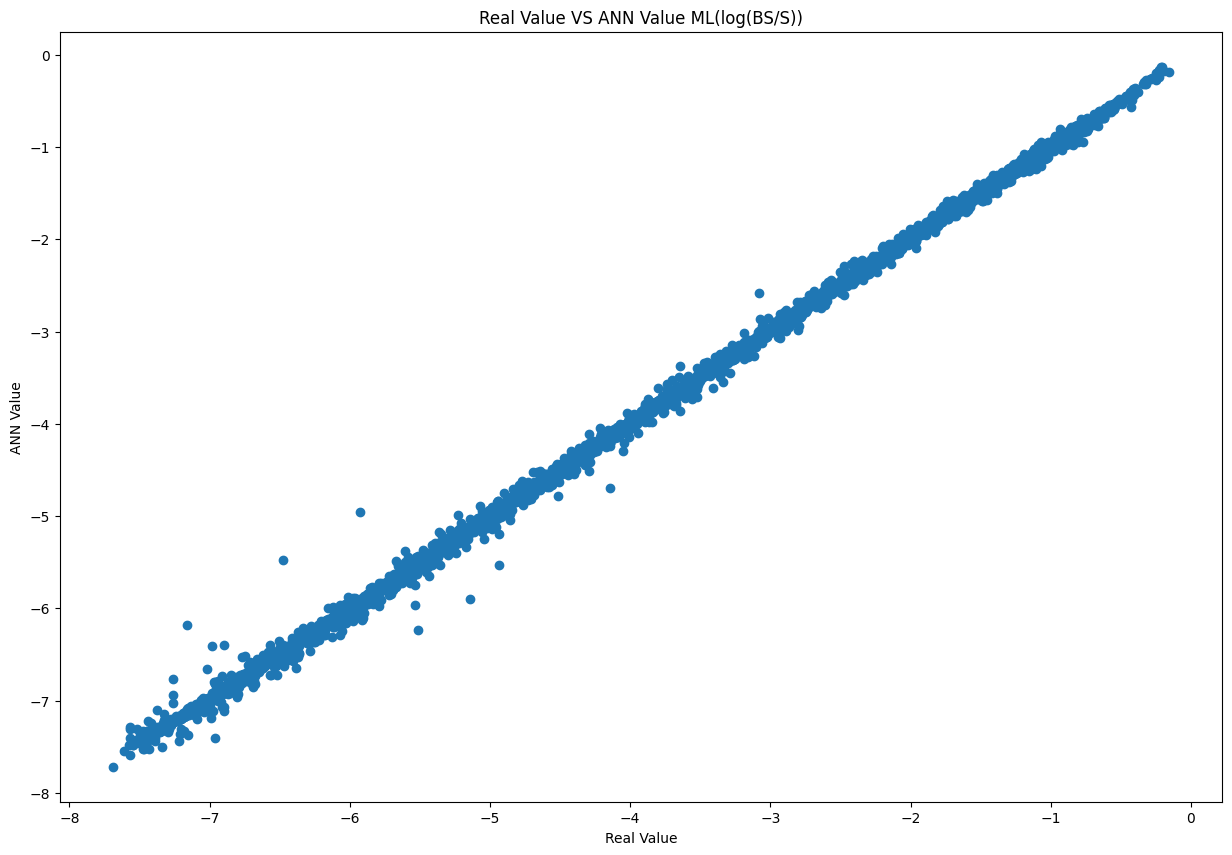

In [191]:

# Comparison of real values and predictions on the test dataset
plt.figure(figsize=(15, 10))
plt.scatter(y_test, y_pred_ML_log)
plt.xlabel("Real Value")
plt.ylabel("ANN Value")
plt.annotate("r-squared = {:.3f}".format(r2_score(y_test, y_pred_ML_log)), (20, 1), size=15)
plt.title('Real Value VS ANN Value ML(log(BS/S))')
plt.show()

In [124]:
# Resetting the indices to ensure alignment
y_test = y_test.reset_index(drop=True)
y_pred_ML_log_seri = pd.Series(y_pred_ML_log.flatten(), name='Predictions')

In [125]:



# Combine them into a DataFrame
frac_ML_log = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_ML_log_seri})

# Save the DataFrame to a CSV file
frac_ML_log.to_csv('frac_ML_log.csv', index=False)

In [126]:
nan_counts = frac_ML_log.isna().sum()

print(nan_counts)
# Drop rows with NaN values
frac_ML_log = frac_ML_log.dropna()

# Reset index (optional)
frac_ML_log = frac_ML_log.reset_index(drop=True)

Actual       0
Predicted    0
dtype: int64


In [127]:

y_testf = frac_ML_log['Actual'].values
y_predf = frac_ML_log['Predicted'].values

# Calculate the fractions
fractionsf = y_predf / y_testf-1


fractions statistics
Min: -0.3822363760660342
Max: 0.3344798169790304
Mean: -0.0036054601306860544
Std: 0.023210457468627415


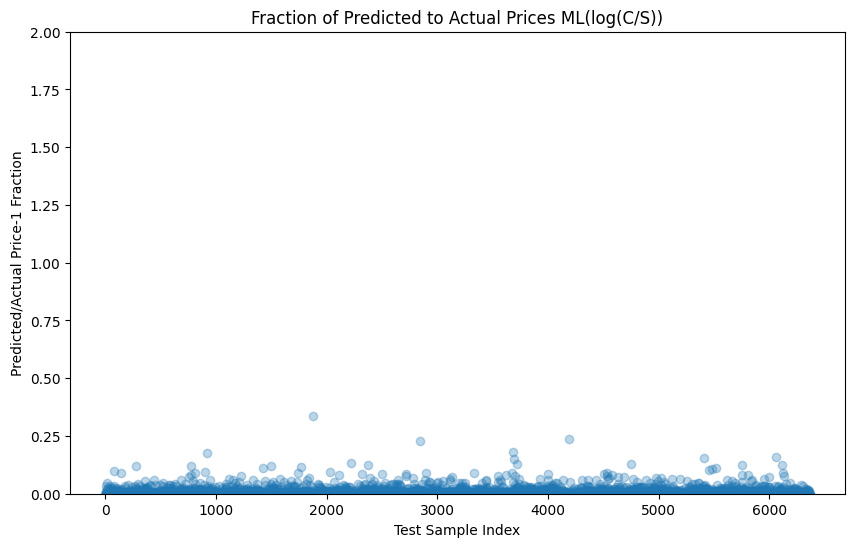

In [196]:

# Print statistics for fractions
print("fractions statistics")
print("Min:", np.min(fractionsf))
print("Max:", np.max(fractionsf))
print("Mean:", np.mean(fractionsf))
print("Std:", np.std(fractionsf))

# Plot the fractions
plt.figure(figsize=(10, 6))
plt.plot(fractionsf, 'o', alpha=0.3)
plt.xlabel('Test Sample Index')
plt.ylabel('Predicted/Actual Price-1 Fraction')
plt.title('Fraction of Predicted to Actual Prices ML(log(C/S))')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

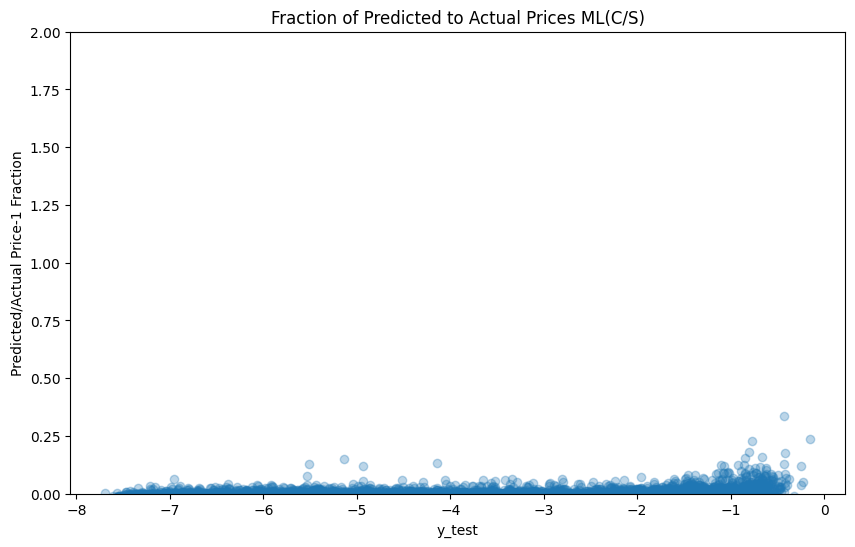

In [197]:





# Plot the fractions
plt.figure(figsize=(10, 6))
plt.plot( y_testf,fractionsf, 'o', alpha=0.3)
plt.xlabel('y_test')
plt.ylabel('Predicted/Actual Price-1 Fraction')
plt.title('Fraction of Predicted to Actual Prices ML(C/S)')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

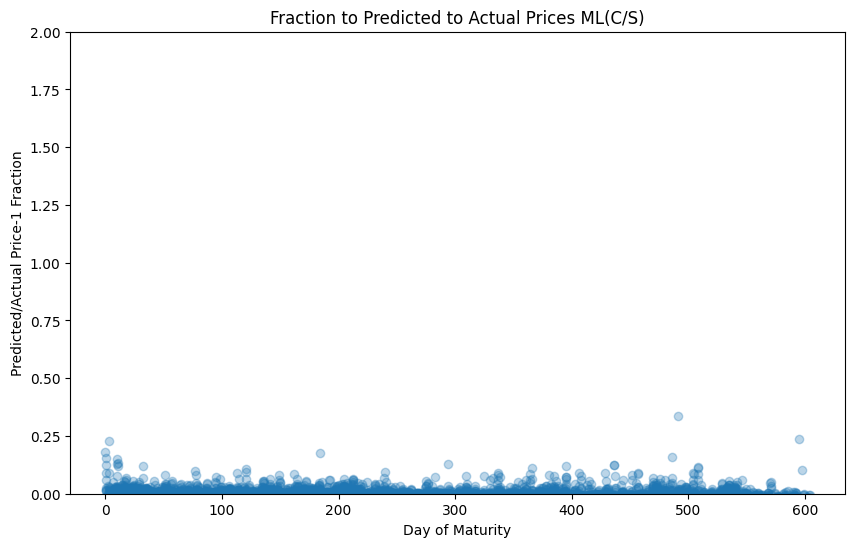

In [201]:
# Plot the fractions
plt.figure(figsize=(10, 6))
plt.plot(X_test["Maturity"]*252,fractionsf, 'o', alpha=0.3)
plt.xlabel('Day of Maturity')
plt.ylabel('Predicted/Actual Price-1 Fraction')
plt.title('Fraction to Predicted to Actual Prices ML(C/S)')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

# test

In [102]:
df20240315_25000.head()


Time  option_price  Volume      IV  underlying_stockprice  Strike  \
71 2022-10-28         58.25    23.0  0.5873                 228.52   250.0   
72 2022-10-31         59.85    12.0  0.5981                 227.54   250.0   
73 2022-11-01         58.67    29.0  0.5844                 227.82   250.0   
74 2022-11-02         51.25    32.0  0.5882                 214.98   250.0   
75 2022-11-03         51.02    23.0  0.5844                 215.31   250.0   

    Maturity       C/S  Monyness       K/S  
71  2.000000  0.254901   0.91408  1.093996  
72  1.988095  0.263031   0.91016  1.098708  
73  1.984127  0.257528   0.91128  1.097358  
74  1.980159  0.238394   0.85992  1.162899  
75  1.976190  0.236961   0.86124  1.161117

In [49]:
df20240315_25000 = df20240315_25000[df20240315_25000['Maturity'] <= 1.9] 

In [101]:
df20240315_25000.describe()

Time  option_price       Volume          IV  \
count                            334    334.000000   334.000000  334.000000   
mean   2023-07-02 02:17:57.844311296     26.474102   602.434132    0.519304   
min              2022-10-28 00:00:00      0.120000     2.000000    0.439400   
25%              2023-03-03 18:00:00     12.350000    47.250000    0.487050   
50%              2023-07-04 00:00:00     25.115000   139.000000    0.509850   
75%              2023-10-30 18:00:00     37.000000   467.750000    0.551825   
max              2024-03-01 00:00:00     75.900000  9606.000000    0.619500   
std                              NaN     17.010139  1160.166782    0.042381   

       underlying_stockprice  Strike    Maturity         C/S    Monyness  \
count             334.000000   334.0  334.000000  334.000000  334.000000   
mean              210.398095   250.0    1.019461    0.119688    0.841592   
min               108.100000   250.0    0.055556    0.000592    0.432400   
25%               183.450000   250.0    0.540675    0.070280    0.733800   
50%               207.495000   250.0    1.011905    0.119976    0.829980   
75%               245.257500   250.0    1.497024    0.168453    0.981030   
max               293.340000   250.0    2.000000    0.263031    1.173360   
std                41.071086     0.0    0.559419    0.063512    0.164284   

              K/S  
count  334.000000  
mean     1.242051  
min      0.852253  
25%      1.019337  
50%      1.204848  
75%      1.362774  
max      2.312673  
std      0.287783

In [50]:
combined_test = combined_test[combined_test['Maturity'] > 14/ 252 ] 
combined_test =  combined_test[combined_test['Maturity'] <= 1.9 ]

In [51]:
data2 = combined_test.copy()

In [174]:
data2.to_csv('combine_test.csv', index=False)

In [55]:

data2.describe()

# Plotting the option_price column


Time  option_price         Volume  \
count                           9661   9661.000000    9661.000000   
mean   2023-08-16 05:49:31.742055424     37.486264     576.036125   
min              2022-11-23 00:00:00      0.100000       1.000000   
25%              2023-05-08 00:00:00      9.870000       8.000000   
50%              2023-08-25 00:00:00     29.100000      32.000000   
75%              2023-11-28 00:00:00     56.600000     143.000000   
max              2024-03-15 00:00:00    194.100000  167030.000000   
std                              NaN     33.409413    4237.234363   

                IV  underlying_stockprice       Strike             r  \
count  9661.000000            9661.000000  9661.000000  9.661000e+03   
mean      0.547094             218.399056   244.455543  5.160000e-02   
min       0.388200             108.100000   100.000000  5.160000e-02   
25%       0.491000             189.190000   180.000000  5.160000e-02   
50%       0.523500             219.960000   230.000000  5.160000e-02   
75%       0.570800             251.050000   300.000000  5.160000e-02   
max       7.275700             293.340000   450.000000  5.160000e-02   
std       0.185671              38.038208    84.778842  4.892173e-15   

          Maturity          C/S     Monyness          K/S  
count  9661.000000  9661.000000  9661.000000  9661.000000  
mean      0.840307     0.169210     0.993325     1.142689  
min       0.000000     0.000455     0.240222     0.344376  
25%       0.428571     0.046094     0.730267     0.844838  
50%       0.805556     0.140333     0.940048     1.063776  
75%       1.238095     0.261633     1.183659     1.369363  
max       1.896825     0.673647     2.903800     4.162812  
std       0.490727     0.141641     0.360392     0.429132

In [52]:
data2.sort_values(by='Time', inplace=True)
data2.reset_index(drop=True, inplace=True)

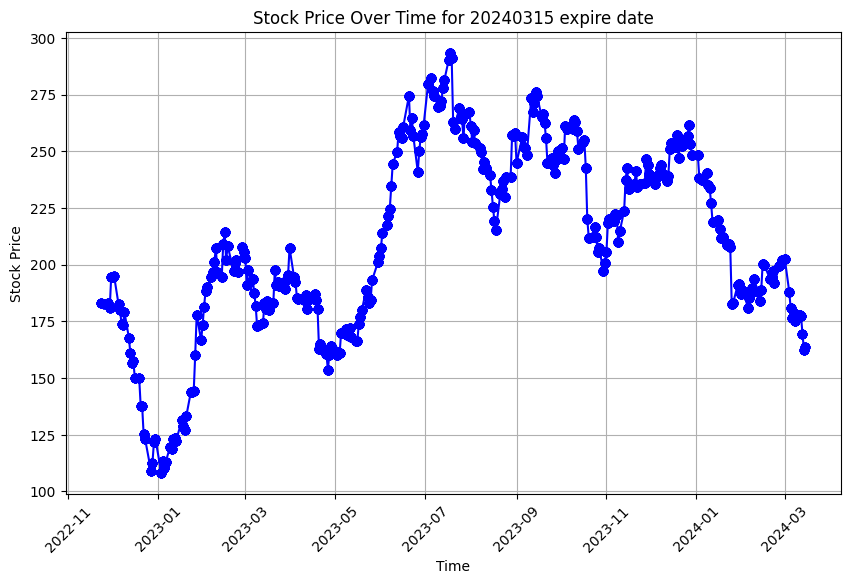

In [64]:


# Plotting the option_price column
plt.figure(figsize=(10, 6))
plt.plot(data2['Time'],data2['underlying_stockprice'], marker='o', linestyle='-', color='b')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Over Time for 20240315 expire date')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

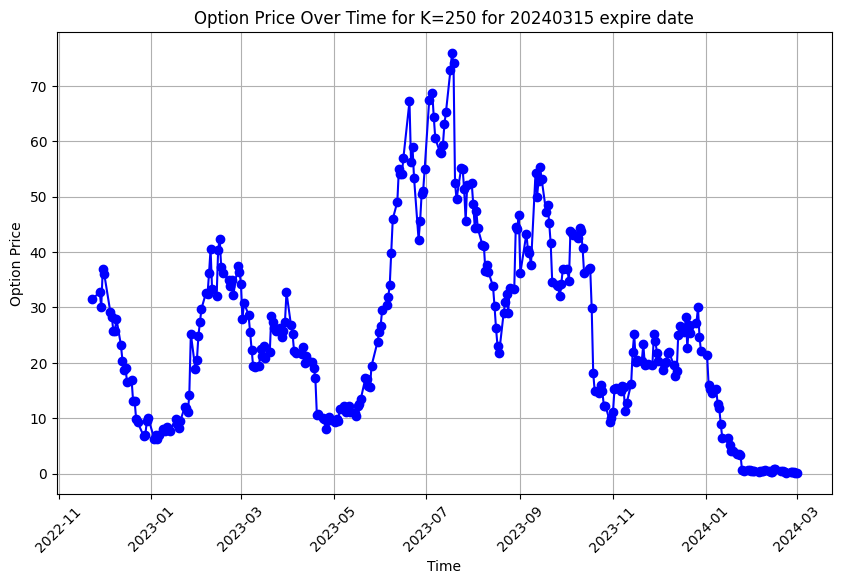

In [65]:

df20240315_25000.sort_values(by='Time', inplace=True)
df20240315_25000.reset_index(drop=True, inplace=True)


# Plotting the option_price column
plt.figure(figsize=(10, 6))
plt.plot(df20240315_25000['Time'],df20240315_25000['option_price'], marker='o', linestyle='-', color='b')
plt.xlabel('Time')
plt.ylabel('Option Price')
plt.title('Option Price Over Time for K=250 for 20240315 expire date')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

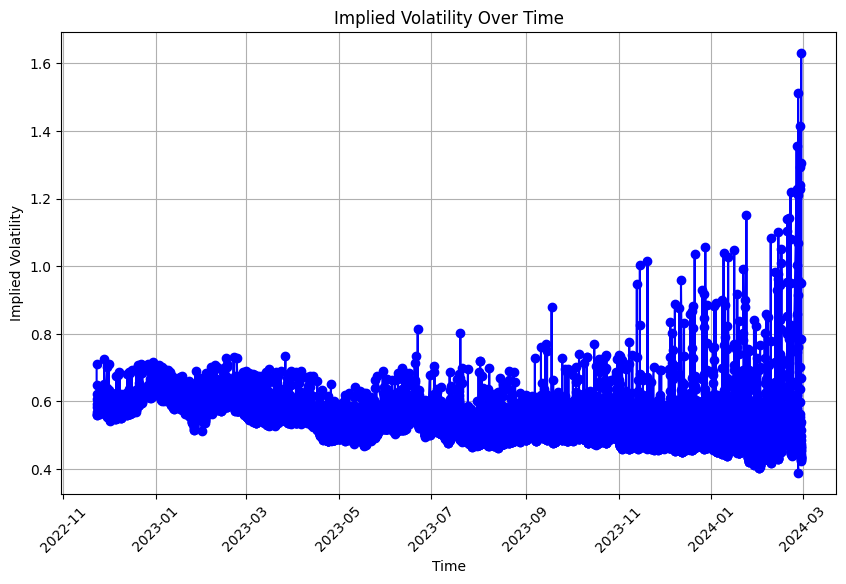

In [260]:
plt.figure(figsize=(10, 6))
plt.plot(data2['Time'], data2['IV'], marker='o', linestyle='-', color='b')
plt.xlabel('Time')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [53]:

def categorize_maturity(maturity):
    if maturity > 280/252:
        return "Long-term"
    elif 90/252 < maturity <= 280/252:
        return "Medium-term"
    else:
        return "Short-term"


In [54]:
# Define the categories
conditions = [
    (data2['Monyness'] < 0.95),
    (data2['Monyness'] >= 0.95) & (data2['Monyness'] <= 1.05),
    (data2['Monyness'] > 1.05)
]
choices = ['OTM', 'ATM', 'ITM']

# Create a new column for the categories
data2['Category'] = pd.Categorical(pd.cut(data2['Monyness'], bins=[0, 0.95, 1.05, float('inf')], labels=['OTM', 'NTM', 'ITM'], right=False))

In [120]:
data2['Maturity_State'] = data2['Maturity'].apply(categorize_maturity)

In [74]:
data2_25000 = df20240315_25000.copy()

In [ ]:
data2_25000['Maturity_State'] = data2_25000['Maturity'].apply(categorize_maturity)

In [ ]:
# Define the categories
conditions = [
    (data2_25000['Monyness'] < 0.95),
    (data2_25000['Monyness'] >= 0.95) & (data2_25000['Monyness'] <= 1.05),
    (data2_25000['Monyness'] > 1.05)
]
choices = ['OTM', 'ATM', 'ITM']

# Create a new column for the categories
data2_25000['Category'] = pd.Categorical(pd.cut(data2_25000['Monyness'], bins=[0, 0.95, 1.05, float('inf')], labels=['OTM', 'NTM', 'ITM'], right=False))

In [76]:
# Sorting the combined DataFrame by 'Exchange Date'
data2_25000.sort_values(by='Time', inplace=True)
data2_25000.reset_index(drop=True, inplace=True)

In [41]:
data2.shape

(9472, 13)

In [121]:
data2_25000.shape

(316, 13)

In [164]:
data2otm = data2[data2['Category']== 'OTM']
data2ntm = data2[data2['Category']== 'NTM']
data2itm = data2[data2['Category']== 'ITM']


In [165]:
data2otm= data2otm.reset_index(drop=True)
data2ntm= data2ntm.reset_index(drop=True)
data2itm= data2itm.reset_index(drop=True)

In [166]:
data2_Long_term = data2[data2['Maturity_State']== 'Long-term']
data2_Medium_term = data2[data2['Maturity_State']== 'Medium-term']
data2_Short_term = data2[data2['Maturity_State']== 'Short-term']
data2_Long_term= data2_Long_term.reset_index(drop=True)
data2_Medium_term= data2_Medium_term.reset_index(drop=True)
data2_Short_term= data2_Short_term.reset_index(drop=True)

In [168]:
data2otm.shape

(4936, 13)

In [169]:
data2ntm.shape

(1123, 13)

In [170]:
data2itm.shape

(3602, 13)

In [171]:
data2_Long_term.shape

(3024, 13)

In [172]:
data2_Medium_term.shape

(4717, 13)

In [173]:
data2_Short_term.shape

(1920, 13)

In [181]:
y_short.shape

(1920,)

# LSTM

In [128]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [129]:


# Define feature columns and target column
feature_columns = ['IV', 'K/S', 'Maturity', 'r']
target_column = 'C/S'

# Split the data into features and target
X = data[feature_columns]
y = data[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [130]:
# Reshape the data for LSTM
X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [332]:
# Define the LSTM model
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(1, 4)))
    #model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [333]:
# Train the LSTM model
lstm_model = create_lstm_model()

C:\Users\spin 3\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [334]:
LSTM_prediction_start_time = time.time()

In [335]:

lstm_history = lstm_model.fit(X_train_lstm, y_train, epochs=150, batch_size=16, verbose=0)

In [336]:
LSTM_prediction_end_time = time.time()

In [337]:
LSTM_prediction_time = LSTM_prediction_end_time - LSTM_prediction_start_time
print(LSTM_prediction_time)

281.46649718284607


In [338]:
final_loss = lstm_history.history['loss'][-1]
print(f"   Last log loss: {final_loss:.10f}")

   Last log loss: 0.0001413459


In [339]:
y_pred_LSTM = lstm_model.predict(X_test_lstm)
rmse_LSTM = np.sqrt(mean_squared_error(y_test,y_pred_LSTM))
mae_LSTM = mean_absolute_error(y_test, y_pred_LSTM)
mse_LSTM = mean_squared_error(y_test,y_pred_LSTM)
r2_lstm = r2_score(y_test, y_pred_LSTM)
print(f"LSTM R-squared: {r2_lstm:.3f}")
print(f"   MSA: {rmse_LSTM:.10f}")
print(f"   MAE: {mae_LSTM :.10f}")
print(f"   MSE: {mse_LSTM :.10f}")   

199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
LSTM R-squared: 0.997
   MSA: 0.0077625383
   MAE: 0.0046017014
   MSE: 0.0000602570


In [303]:
def create_improved_lstm_model():
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(1, 4)))
    
    model.add(LSTM(units=100, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(units=50, activation='relu'))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

In [304]:
lstm_model_improved = create_improved_lstm_model()

C:\Users\spin 3\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [305]:
LSTM_prediction_start_time = time.time()

In [306]:
lstm_history = lstm_model_improved.fit(X_train_lstm, y_train, epochs=150, batch_size=16, verbose=0)

In [307]:
LSTM_prediction_end_time = time.time()

In [308]:
LSTM_prediction_time = LSTM_prediction_end_time - LSTM_prediction_start_time
print(LSTM_prediction_time)

340.738406419754


In [309]:
final_loss = lstm_history.history['loss'][-1]
print(f"   Last log loss: {final_loss:.10f}")

   Last log loss: 0.0000486713


In [328]:
y_pred_LSTM = lstm_model_improved.predict(X_test_lstm)
rmse_LSTM = np.sqrt(mean_squared_error(y_test,y_pred_LSTM))
mae_LSTM = mean_absolute_error(y_test, y_pred_LSTM)
mse_LSTM = mean_squared_error(y_test,y_pred_LSTM)
r2_lstm = r2_score(y_test, y_pred_LSTM)
print(f"LSTM R-squared: {r2_lstm:.3f}")
print(f"   MSA: {rmse_LSTM:.10f}")
print(f"   MAE: {mae_LSTM :.10f}")
print(f"   MSE: {mse_LSTM :.10f}")   

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
LSTM R-squared: 0.997
   MSA: 0.0074433834
   MAE: 0.0053625320
   MSE: 0.0000554040


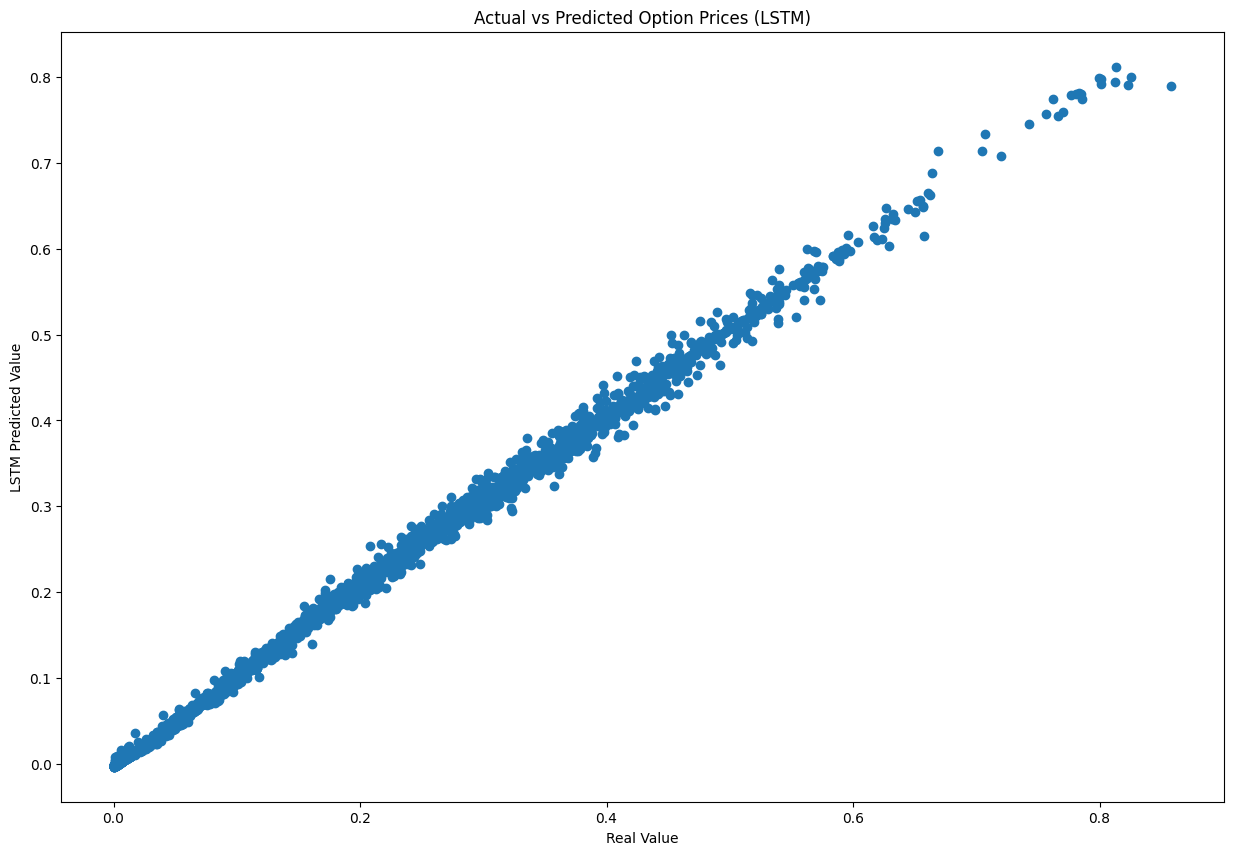

In [321]:

# Evaluate the LSTM model



# Plot LSTM results
plt.figure(figsize=(15, 10))
plt.scatter(y_test, y_pred_LSTM)
plt.xlabel("Real Value")
plt.ylabel("LSTM Predicted Value")
plt.title('Actual vs Predicted Option Prices (LSTM)')
plt.show()

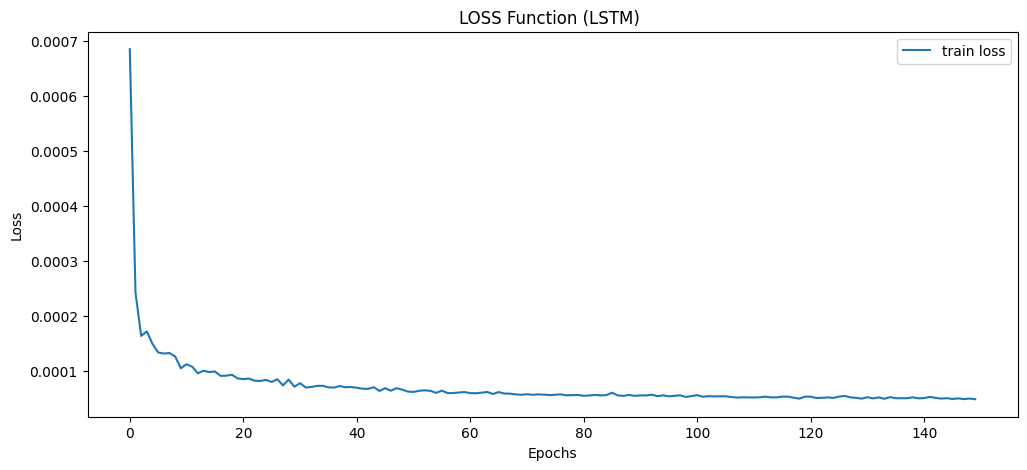

In [322]:
fig, ax = plt.subplots(figsize=(12, 5))
x_x = lstm_history.history["loss"]
ax.plot(lstm_history.history["loss"], label="train loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('LOSS Function (LSTM) ')
#ax.plot(history.history["accuracy"], label="train accuracy")
#ax.plot(history.history["val_loss"], label="validation loss")
#ax.plot(history.history["val_accuracy"], label="validation accuracy")
ax.legend()

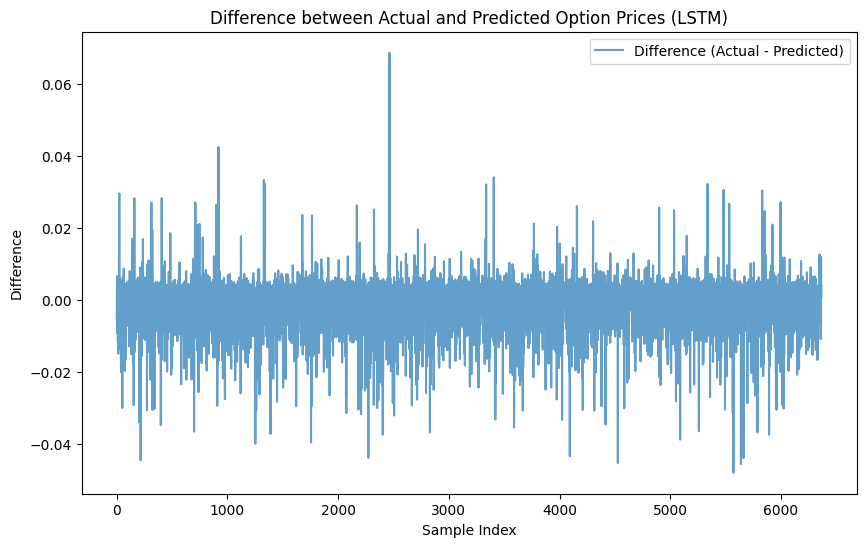

In [326]:
difference = y_test.values - y_pred_LSTM.flatten()

# Plot the difference
plt.figure(figsize=(10, 6))
plt.plot(difference, label='Difference (Actual - Predicted)', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('Difference')
plt.title('Difference between Actual and Predicted Option Prices (LSTM)')
plt.legend()
plt.show()

In [ ]:

X_trainsample = scaler.fit_transform(df250[feature_columns])
X_trainsample_lstm = np.reshape(X_trainsample, (X_trainsample.shape[0], 1, X_trainsample.shape[1]))
newper = lstm_model.predict (X_trainsample_lstm)
differencee = newper- df250['C/S'].values
# Plot log-transformed actual vs predicted
plt.figure(figsize=(14, 7))

plt.subplot(1, 1, 1)
plt.plot(df250['C/S'].values, label=' Actual', marker='o')
plt.plot(newper, label=' Predicted', marker='x')
plt.title(' Actual vs Predicted EuropeanOption price (LSTM)')
plt.xlabel('sample index')
plt.ylabel('Call option price/underlying stock price')
plt.legend()

In [63]:
feature_columns = ['IV', 'K/S', 'Maturity', 'r']
target_column = 'C/S'

# Split the data into features and target
X = data[feature_columns]
y = data[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
feature_columns = ['IV', 'K/S', 'Maturity', 'r']
target_column = 'C/S'

# Split the data into features and target
X = data[feature_columns]
y = data[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the data for LSTM
X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [89]:
# Improved LSTM model
def create_improved_lstm_model():
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(1, 4)))
    model.add(LSTM(units=100, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=50, activation='elu'))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

C:\Users\spin 3\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


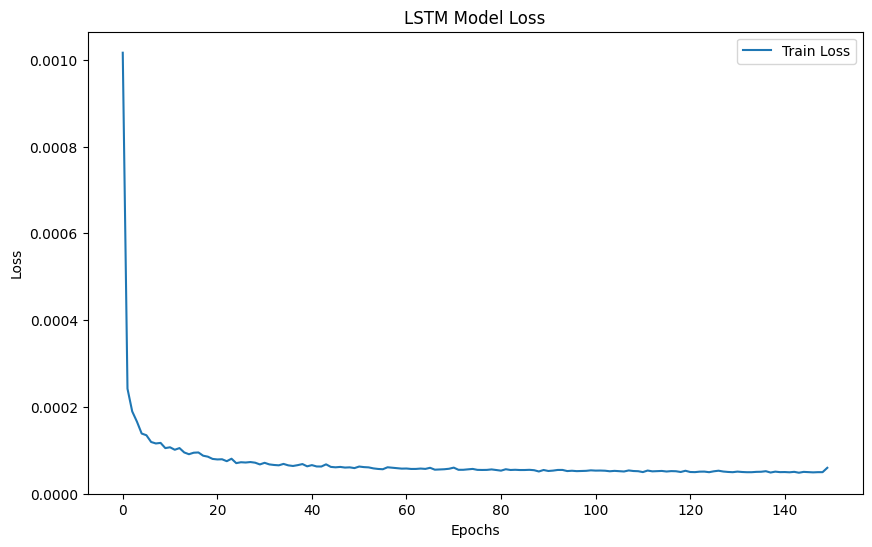

Train Loss: 3.105073847109452e-05
Test Loss: 2.9800019547110423e-05


In [56]:


# Improved LSTM model
def create_improved_lstm_model():
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(1, 4)))
    model.add(LSTM(units=100, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=50, activation='elu'))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

lstm_model = create_improved_lstm_model()
lstm_history = lstm_model.fit(X_train_lstm, y_train, epochs=150, batch_size=16, verbose=0)

# Evaluate the model
train_loss = lstm_model.evaluate(X_train_lstm, y_train, verbose=0)
test_loss = lstm_model.evaluate(X_test_lstm, y_test, verbose=0)

# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(lstm_history.history['loss'], label='Train Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(f'Train Loss: {train_loss}')
print(f'Test Loss: {test_loss}')


In [132]:
final_loss = lstm_history.history['loss'][-1]
print(f"   Last log loss: {final_loss:.10f}")

   Last log loss: 0.0000476955


In [59]:

y_pred_LSTM = lstm_model.predict(X_test_lstm)
rmse_LSTM = np.sqrt(mean_squared_error(y_test,y_pred_LSTM))
mae_LSTM = mean_absolute_error(y_test, y_pred_LSTM)
mse_LSTM = mean_squared_error(y_test,y_pred_LSTM)
r2_lstm = r2_score(y_test, y_pred_LSTM)
print(f"LSTM R-squared: {r2_lstm:.3f}")
print(f"   MSA: {rmse_LSTM:.10f}")
print(f"   MAE: {mae_LSTM :.10f}")
print(f"   MSE: {mse_LSTM :.10f}")  

199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
LSTM R-squared: 0.999
   MSA: 0.0054589395
   MAE: 0.0027763185
   MSE: 0.0000298000


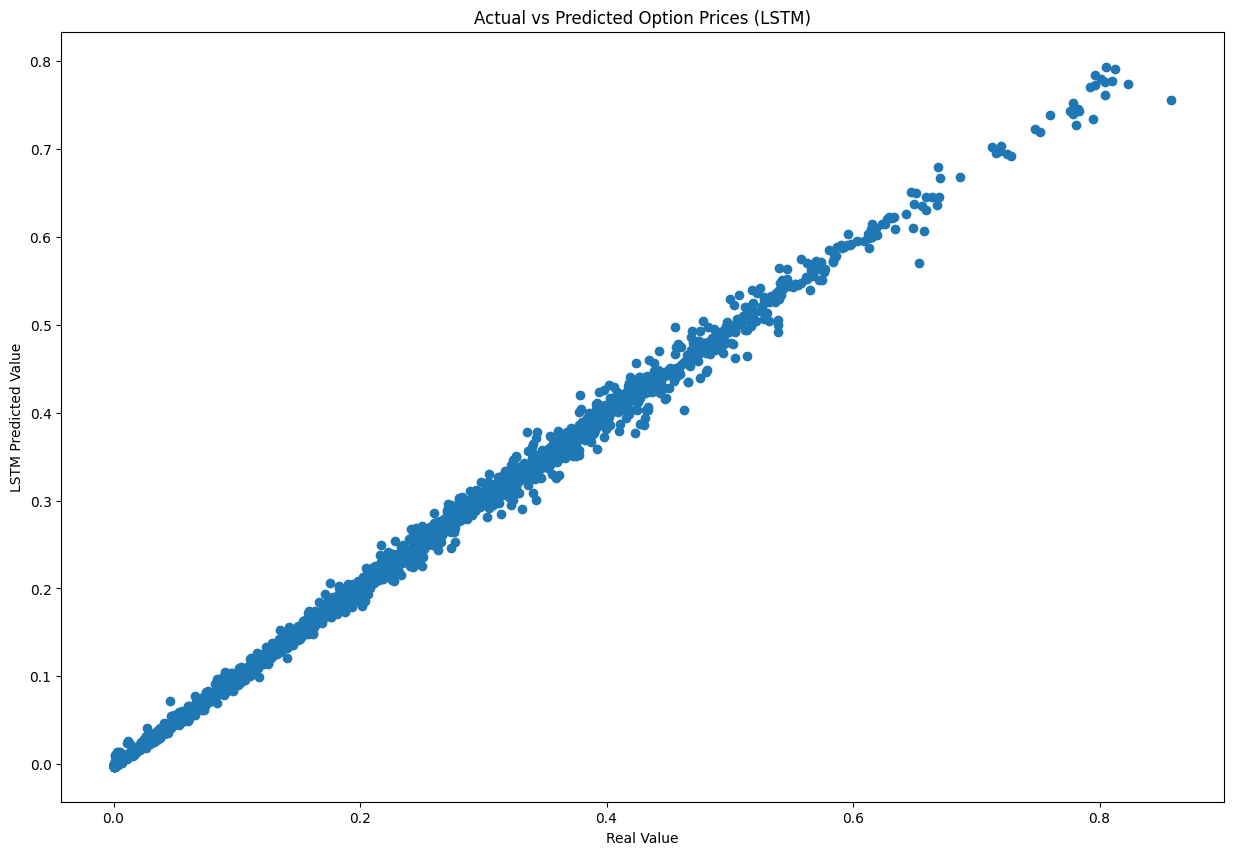

In [134]:
# Plot LSTM results
plt.figure(figsize=(15, 10))
plt.scatter(y_test, y_pred_LSTM)
plt.xlabel("Real Value")
plt.ylabel("LSTM Predicted Value")
plt.title('Actual vs Predicted Option Prices (LSTM)')
plt.show()

fractions statistics
Min: -0.8337001047636333
Max: 8.888998693227768
Mean: 0.1565125571571926
Std: 0.4832287507672764


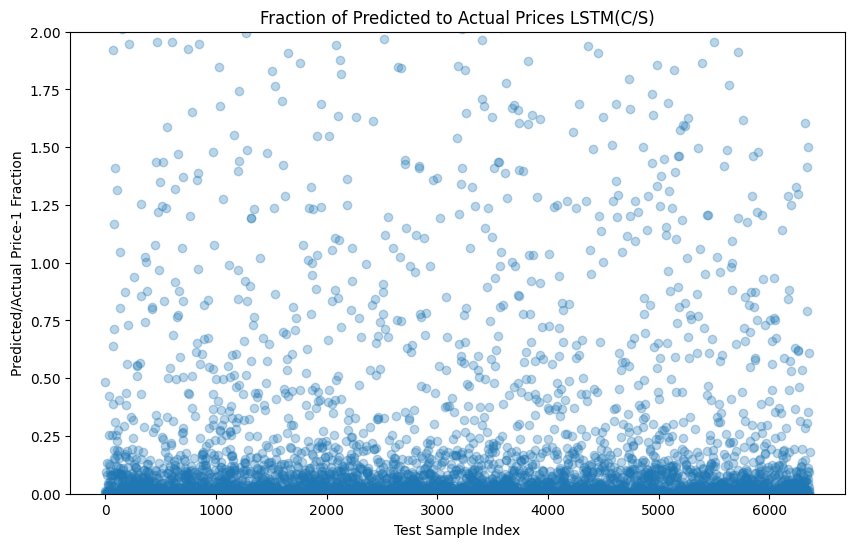

In [60]:
y_test = y_test.reset_index(drop=True)
newper_lstm = pd.Series(y_pred_LSTM.flatten(), name='Predictions')
# Combine them into a DataFrame
frac_lstm = pd.DataFrame({'Actual': y_test, 'Predicted': newper_lstm})

y_testf = frac_lstm['Actual'].values
y_predf = frac_lstm['Predicted'].values

# Calculate the fractions
fractionsf = y_predf / y_testf-1

# Print statistics for fractions
print("fractions statistics")
print("Min:", np.min(fractionsf))
print("Max:", np.max(fractionsf))
print("Mean:", np.mean(fractionsf))
print("Std:", np.std(fractionsf))

# Plot the fractions
plt.figure(figsize=(10, 6))
plt.plot(fractionsf, 'o', alpha=0.3)
plt.xlabel('Test Sample Index')
plt.ylabel('Predicted/Actual Price-1 Fraction')
plt.title('Fraction of Predicted to Actual Prices LSTM(C/S)')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

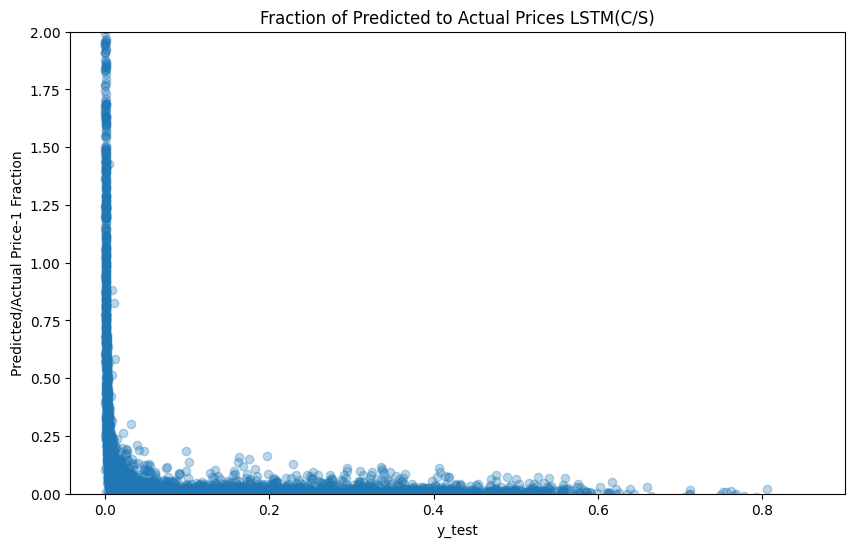

In [61]:

# Plot the fractions
plt.figure(figsize=(10, 6))
plt.plot(y_test,fractionsf, 'o', alpha=0.3)
plt.xlabel('y_test')
plt.ylabel('Predicted/Actual Price-1 Fraction')
plt.title('Fraction of Predicted to Actual Prices LSTM(C/S)')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

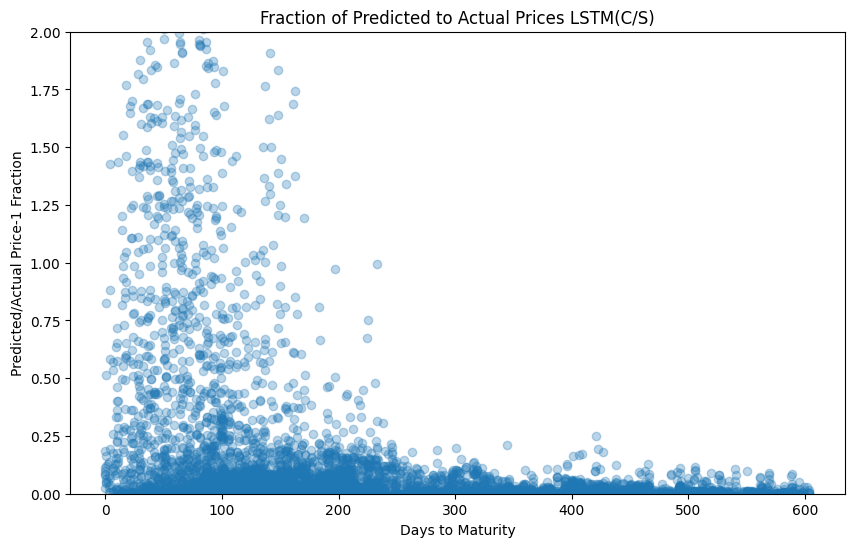

In [64]:

# Plot the fractions
plt.figure(figsize=(10, 6))
plt.plot(X_test['Maturity'].values*252,fractionsf, 'o', alpha=0.3)
plt.xlabel('Days to Maturity')
plt.ylabel('Predicted/Actual Price-1 Fraction')
plt.title('Fraction of Predicted to Actual Prices LSTM(C/S)')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

In [98]:
feature_columns = ['IV', 'K/S', 'Maturity', 'r']
target_column = 'C/S'

# Split the data into features and target
X = data[feature_columns]
y = log(data[target_column])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [91]:


# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the data for LSTM
X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:


lstm_model_log = create_improved_lstm_model()
lstm_history_log = lstm_model_log.fit(X_train_lstm, y_train, epochs=150, batch_size=16, verbose=0)

# Evaluate the model
train_loss = lstm_model_log.evaluate(X_train_lstm, y_train, verbose=0)
test_loss = lstm_model_log.evaluate(X_test_lstm, y_test, verbose=0)

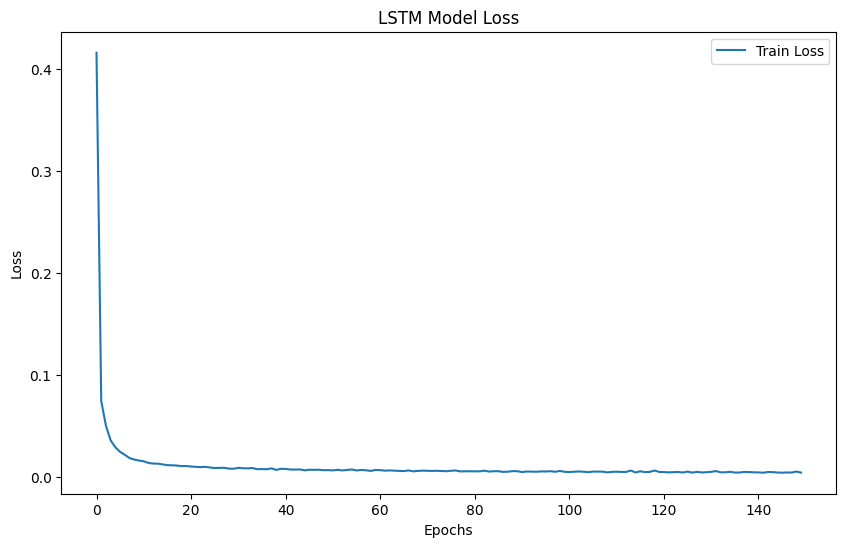

Train Loss: 0.002255053259432316
Test Loss: 0.002301045460626483


In [93]:
# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(lstm_history_log.history['loss'], label='Train Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(f'Train Loss: {train_loss}')
print(f'Test Loss: {test_loss}')


In [94]:
y_pred_LSTM = lstm_model_log.predict(X_test_lstm)
rmse_LSTM = np.sqrt(mean_squared_error(y_test,y_pred_LSTM))
mae_LSTM = mean_absolute_error(y_test, y_pred_LSTM)
mse_LSTM = mean_squared_error(y_test,y_pred_LSTM)
r2_lstm = r2_score(y_test, y_pred_LSTM)
print(f"LSTM R-squared: {r2_lstm:.3f}")
print(f"   MSA: {rmse_LSTM:.10f}")
print(f"   MAE: {mae_LSTM :.10f}")
print(f"   MSE: {mse_LSTM :.10f}")  

199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
LSTM R-squared: 0.999
   MSA: 0.0479692135
   MAE: 0.0294476776
   MSE: 0.0023010454


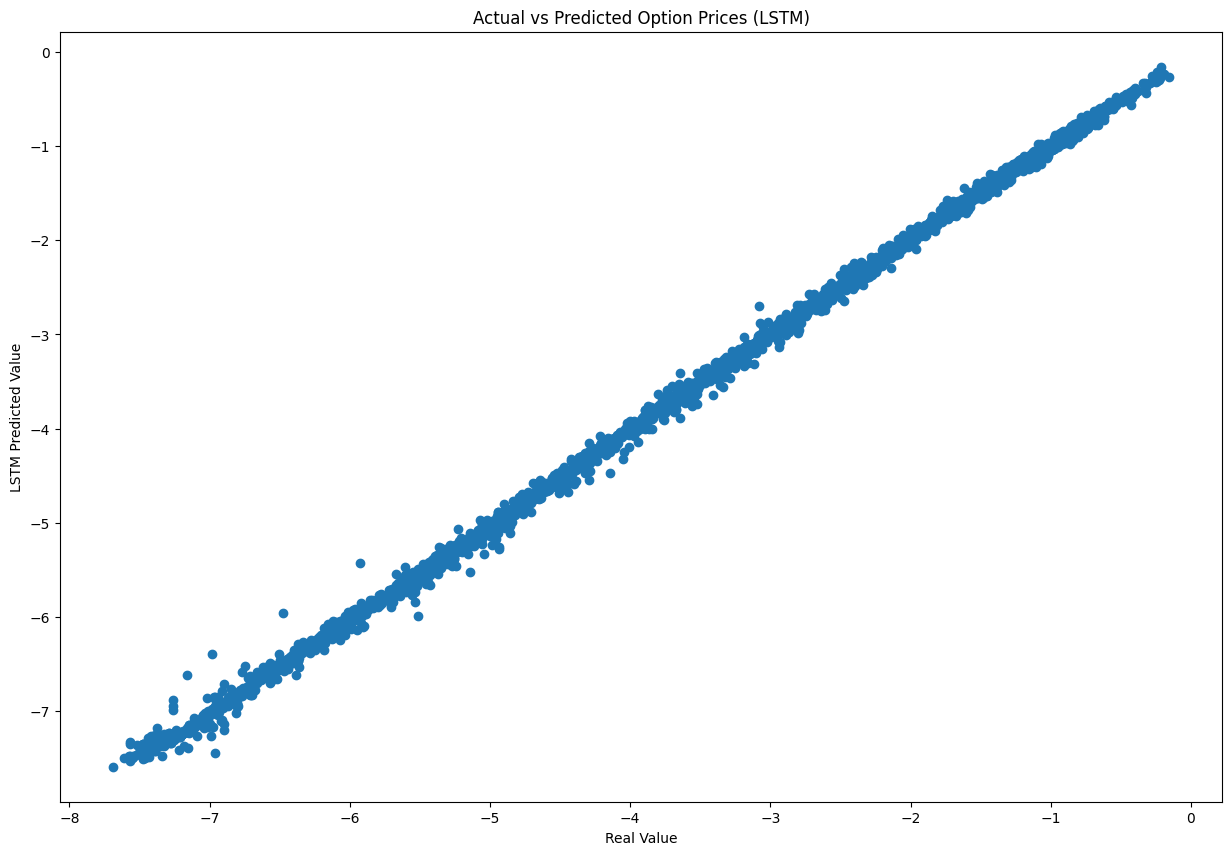

In [95]:
# Plot LSTM results
plt.figure(figsize=(15, 10))
plt.scatter(y_test, y_pred_LSTM)
plt.xlabel("Real Value")
plt.ylabel("LSTM Predicted Value")
plt.title('Actual vs Predicted Option Prices (LSTM)')
plt.show()

199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
fractions statistics
Min: -0.2618198678945962
Max: 0.7071436850836863
Mean: 0.00022958217641662294
Std: 0.024092976520102612


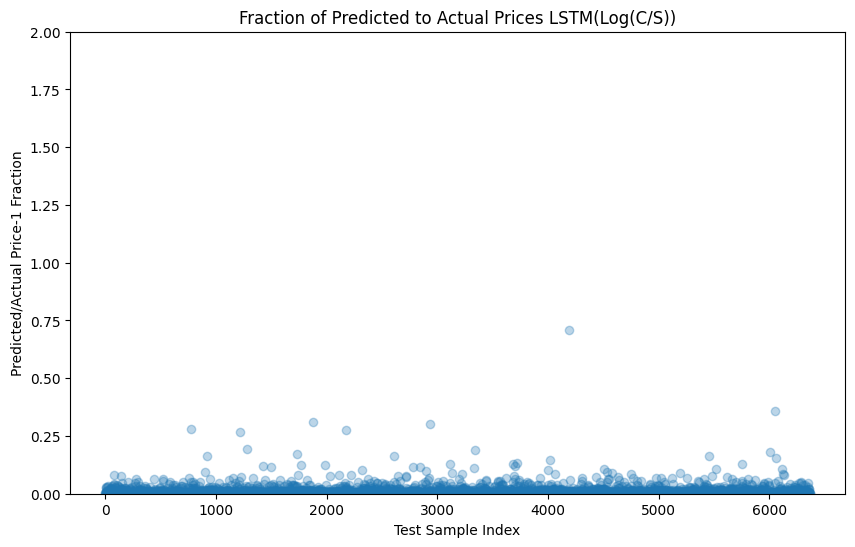

In [96]:
y_pred_LSTM = lstm_model_log.predict(X_test_lstm)
y_test = y_test.reset_index(drop=True)
newper_lstm_log = pd.Series(y_pred_LSTM.flatten(), name='Predictions')
# Combine them into a DataFrame
frac_lstm_log = pd.DataFrame({'Actual': y_test, 'Predicted': newper_lstm_log})

y_testf = frac_lstm_log['Actual'].values
y_predf = frac_lstm_log['Predicted'].values

# Calculate the fractions
fractionsf = y_predf / y_testf-1

# Print statistics for fractions
print("fractions statistics")
print("Min:", np.min(fractionsf))
print("Max:", np.max(fractionsf))
print("Mean:", np.mean(fractionsf))
print("Std:", np.std(fractionsf))

# Plot the fractions
plt.figure(figsize=(10, 6))
plt.plot(fractionsf, 'o', alpha=0.3)
plt.xlabel('Test Sample Index')
plt.ylabel('Predicted/Actual Price-1 Fraction')
plt.title('Fraction of Predicted to Actual Prices LSTM(Log(C/S))')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

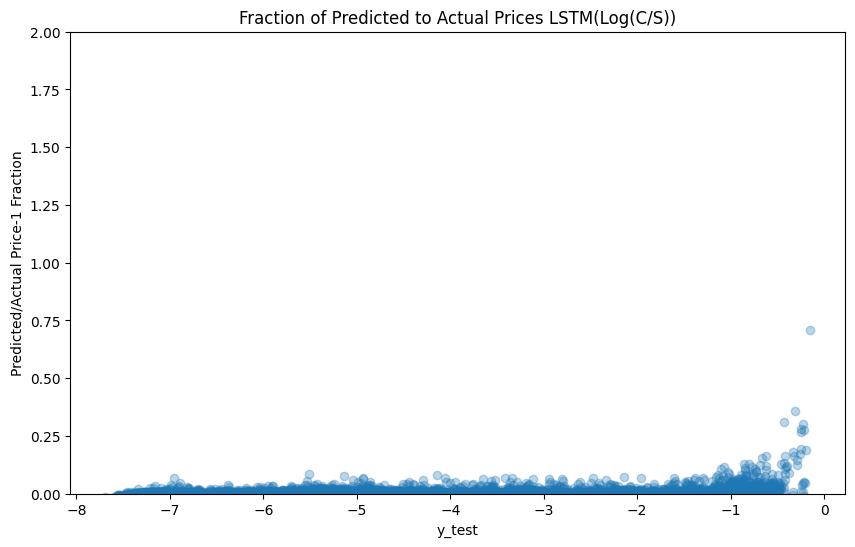

In [97]:
# Plot the fractions
plt.figure(figsize=(10, 6))
plt.plot(y_testf,fractionsf, 'o', alpha=0.3)
plt.xlabel('y_test')
plt.ylabel('Predicted/Actual Price-1 Fraction')
plt.title('Fraction of Predicted to Actual Prices LSTM(Log(C/S))')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

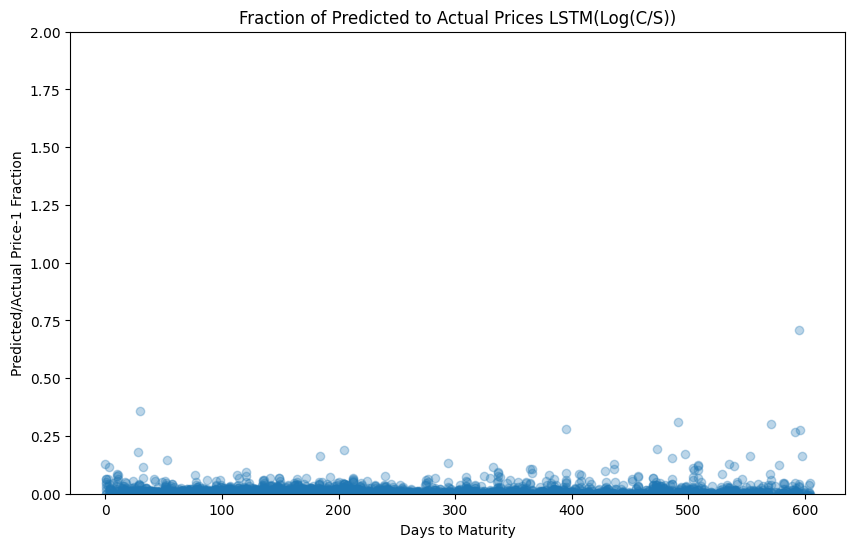

In [99]:
# Plot the fractions
plt.figure(figsize=(10, 6))
plt.plot(X_test['Maturity'].values*252,fractionsf, 'o', alpha=0.3)
plt.xlabel('Days to Maturity')
plt.ylabel('Predicted/Actual Price-1 Fraction')
plt.title('Fraction of Predicted to Actual Prices LSTM(Log(C/S))')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

# GRU

In [33]:
# Define feature columns and target column
feature_columns = ['IV', 'K/S', 'Maturity', 'r']
target_column = 'C/S'

In [34]:
# Split the data into features and target
X = data[feature_columns]
y = data[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [35]:

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the data for GRU
X_train_gru = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_gru = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [36]:
def create_gru_model():
    model = Sequential()
    model.add(GRU(units=100, return_sequences=True, input_shape=(1, 4)))
    
    model.add(GRU(units=100, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(units=50, activation='elu'))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

In [43]:
gru_model = create_gru_model()
gru_start_time = time.time()
gru_history = gru_model.fit(X_train_gru, y_train, epochs=200, batch_size=32, verbose=0)
gru_end_time = time.time()
gru_training_time = gru_end_time - gru_start_time

C:\Users\spin 3\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [43]:
print(f'gru_training_time is {gru_training_time}')

gru_training_time is 724.9872436523438


In [44]:
final_loss = gru_history.history['loss'][-1]
print(f"   Last log loss: {final_loss:.10f}")

   Last log loss: 0.0000457482


In [45]:
y_pred_gru = gru_model.predict(X_test_gru)

199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


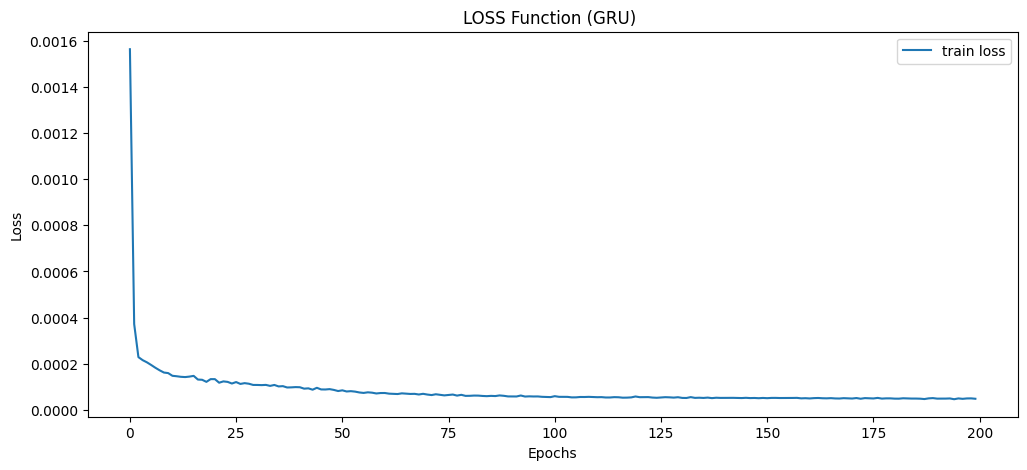

In [44]:
fig, ax = plt.subplots(figsize=(12, 5))
x_x = gru_history.history["loss"]
ax.plot(gru_history.history["loss"], label="train loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('LOSS Function (GRU) ')
#ax.plot(history.history["accuracy"], label="train accuracy")
#ax.plot(history.history["val_loss"], label="validation loss")
#ax.plot(history.history["val_accuracy"], label="validation accuracy")
ax.legend()

In [49]:

rmse_gru = np.sqrt(mean_squared_error(y_test,y_pred_gru))
mae_gru = mean_absolute_error(y_test, y_pred_gru)
mse_gru = mean_squared_error(y_test,y_pred_gru)
r2_gru = r2_score(y_test, y_pred_gru)
print(f"LSTM R-squared: {r2_gru:.3f}")
print(f"   MSA: {rmse_gru:.10f}")
print(f"   MAE: {mae_gru :.10f}")
print(f"   MSE: {mse_gru :.10f}")   

LSTM R-squared: 0.998
   MSA: 0.0067310185
   MAE: 0.0034029417
   MSE: 0.0000453066


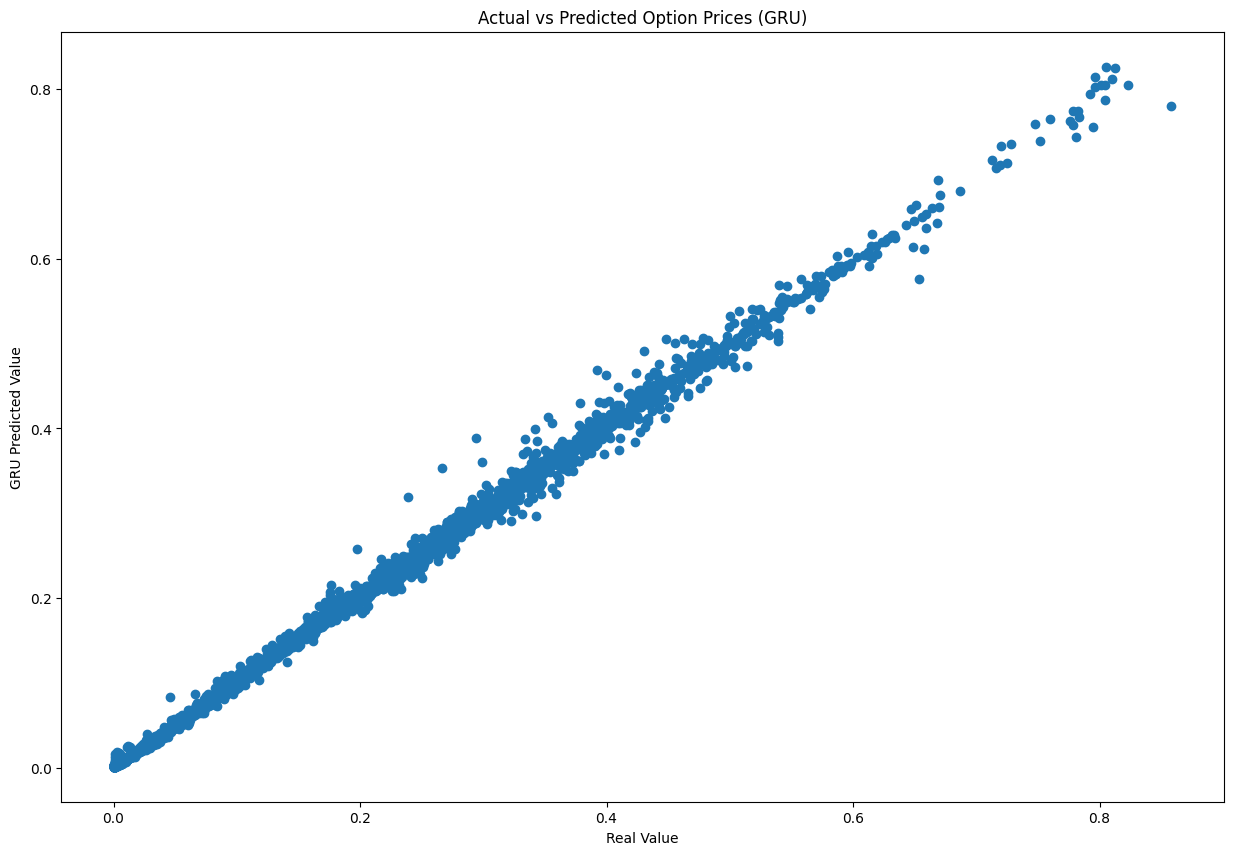

In [50]:
# Plot LSTM results
plt.figure(figsize=(15, 10))
plt.scatter(y_test, y_pred_gru)
plt.xlabel("Real Value")
plt.ylabel("GRU Predicted Value")
plt.title('Actual vs Predicted Option Prices (GRU)')
plt.show()

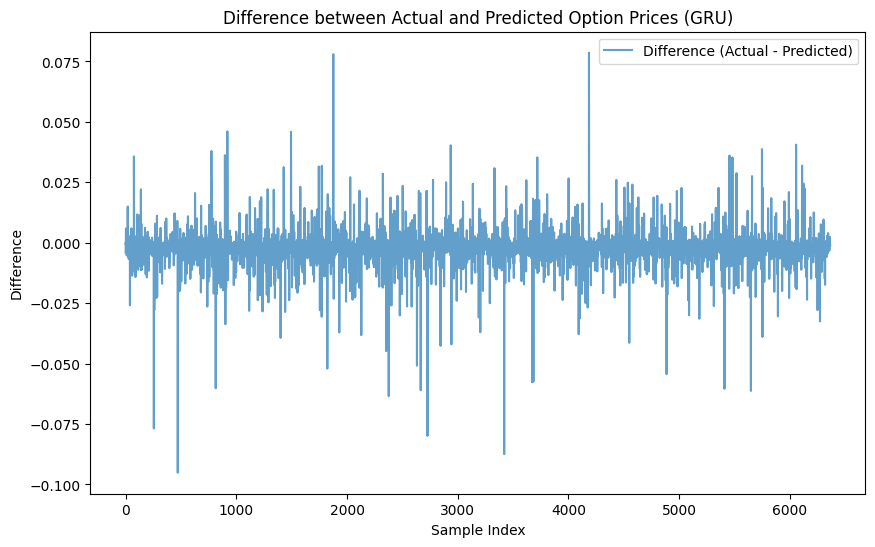

In [51]:
difference = y_test.values - y_pred_gru.flatten()

# Plot the difference
plt.figure(figsize=(10, 6))
plt.plot(difference, label='Difference (Actual - Predicted)', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('Difference')
plt.title('Difference between Actual and Predicted Option Prices (GRU)')
plt.legend()
plt.show()

199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
fractions statistics
Min: -1.0145301409065723
Max: 6.698937684297562
Mean: -0.007570905821911012
Std: 0.3165868684787091


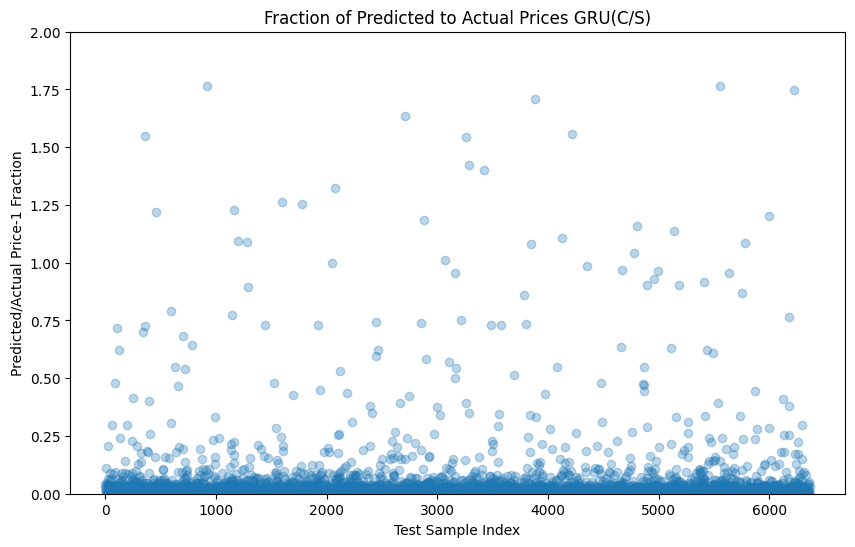

In [46]:
y_pred_gru = gru_model.predict(X_test_gru)
y_test = y_test.reset_index(drop=True)
newper_gru = pd.Series(y_pred_gru.flatten(), name='Predictions')
# Combine them into a DataFrame
frac_gru = pd.DataFrame({'Actual': y_test, 'Predicted': newper_gru})

y_testf = frac_gru['Actual'].values
y_predf = frac_gru['Predicted'].values

# Calculate the fractions
fractionsf = y_predf / y_testf-1

# Print statistics for fractions
print("fractions statistics")
print("Min:", np.min(fractionsf))
print("Max:", np.max(fractionsf))
print("Mean:", np.mean(fractionsf))
print("Std:", np.std(fractionsf))

# Plot the fractions
plt.figure(figsize=(10, 6))
plt.plot(fractionsf, 'o', alpha=0.3)
plt.xlabel('Test Sample Index')
plt.ylabel('Predicted/Actual Price-1 Fraction')
plt.title('Fraction of Predicted to Actual Prices GRU(C/S)')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

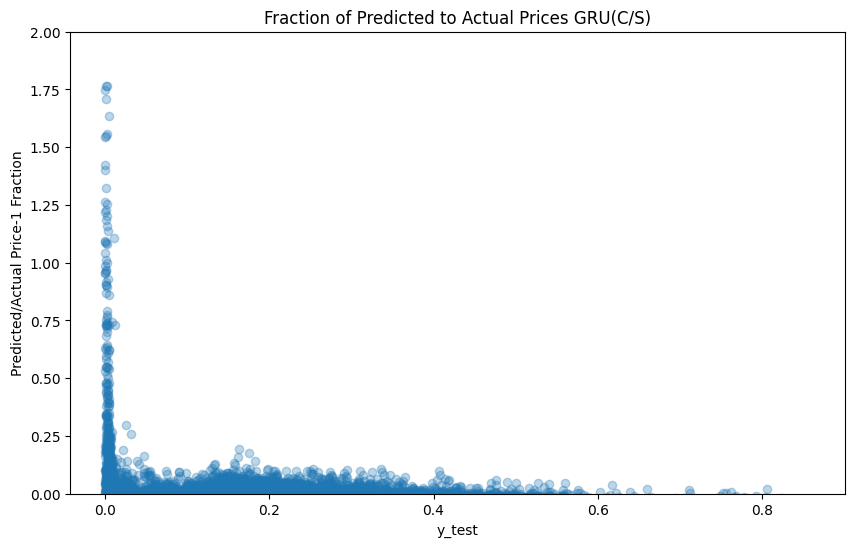

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(y_testf,fractionsf, 'o', alpha=0.3)
plt.xlabel('y_test')
plt.ylabel('Predicted/Actual Price-1 Fraction')
plt.title('Fraction of Predicted to Actual Prices GRU(C/S)')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

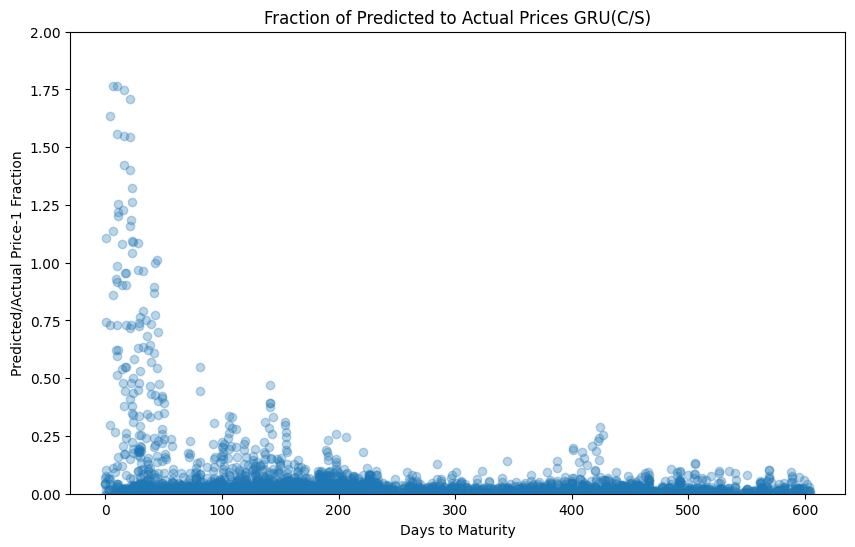

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(X_test['Maturity'].values*252,fractionsf, 'o', alpha=0.3)
plt.xlabel('Days to Maturity')
plt.ylabel('Predicted/Actual Price-1 Fraction')
plt.title('Fraction of Predicted to Actual Prices GRU(C/S)')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

# log gru

In [115]:
# Split the data into features and target
X = data[feature_columns]
y = log(data[target_column])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [105]:


# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the data for GRU
X_train_gru = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_gru = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [106]:
gru_model_log = create_gru_model()
gru_start_time = time.time()
gru_history_log = gru_model_log.fit(X_train_gru, y_train, epochs=200, batch_size=32, verbose=0)
gru_end_time = time.time()
gru_training_time = gru_end_time - gru_start_time

C:\Users\spin 3\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [107]:
print(f'gru_training_time is {gru_training_time}')

gru_training_time is 261.7893283367157


In [58]:
final_loss = gru_history_log.history['loss'][-1]
print(f"   Last log loss: {final_loss:.10f}")

   Last log loss: 0.0037814335


In [78]:
y_pred_gru = gru_model_log.predict(X_test_gru)
rmse_gru = np.sqrt(mean_squared_error(y_test,y_pred_gru))
mae_gru = mean_absolute_error(y_test, y_pred_gru)
mse_gru = mean_squared_error(y_test,y_pred_gru)
r2_gru = r2_score(y_test, y_pred_gru)
print(f"LSTM R-squared: {r2_gru:.3f}")
print(f"   MSA: {rmse_gru:.10f}")
print(f"   MAE: {mae_gru :.10f}")
print(f"   MSE: {mse_gru :.10f}")  

199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
LSTM R-squared: 0.928
   MSA: 0.4915808361
   MAE: 0.3763990818
   MSE: 0.2416517184


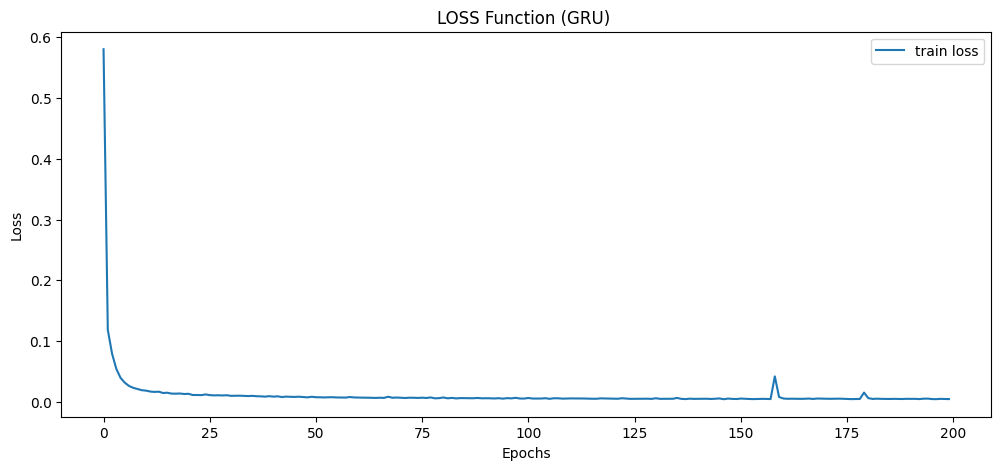

In [109]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(gru_history_log.history["loss"], label="train loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('LOSS Function (GRU) ')
#ax.plot(history.history["accuracy"], label="train accuracy")
#ax.plot(history.history["val_loss"], label="validation loss")
#ax.plot(history.history["val_accuracy"], label="validation accuracy")
ax.legend()

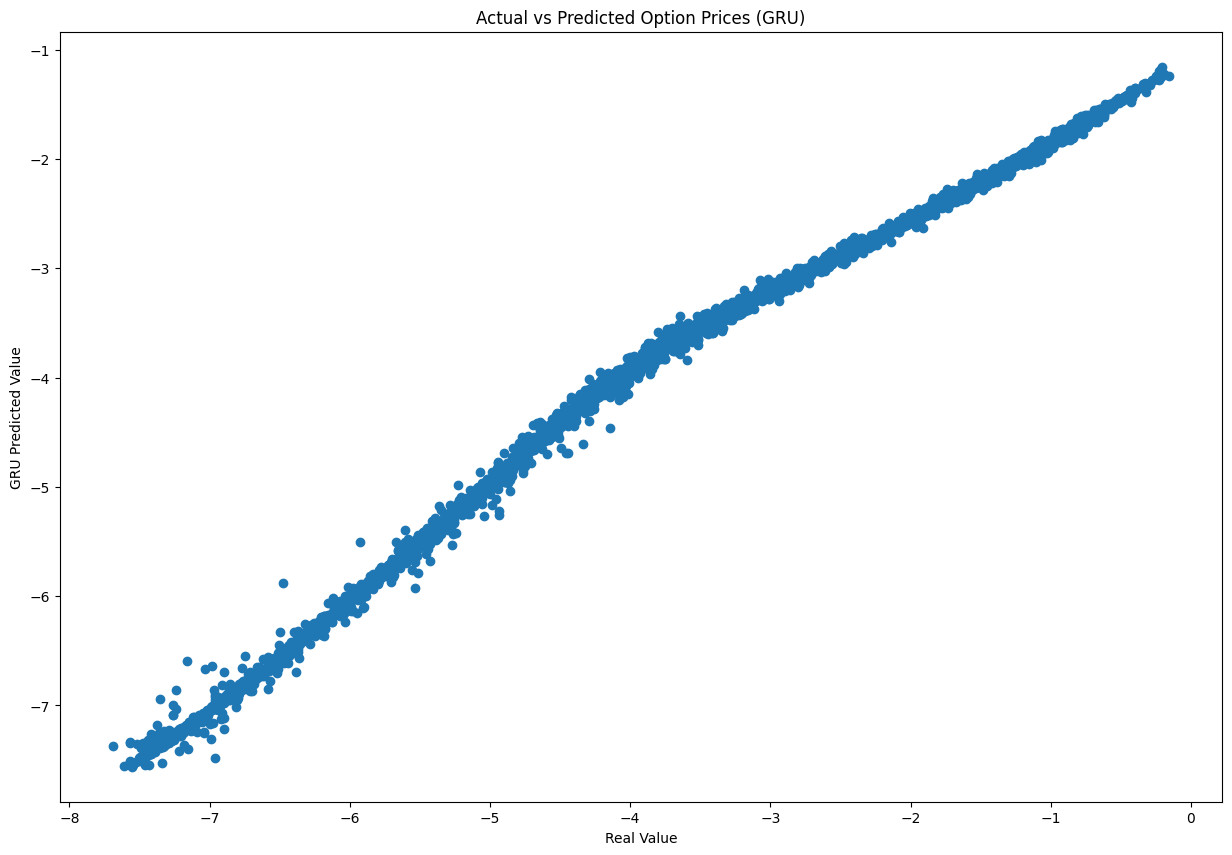

In [110]:
# Plot LSTM results
plt.figure(figsize=(15, 10))
plt.scatter(y_test, y_pred_gru)
plt.xlabel("Real Value")
plt.ylabel("GRU Predicted Value")
plt.title('Actual vs Predicted Option Prices (GRU)')
plt.show()

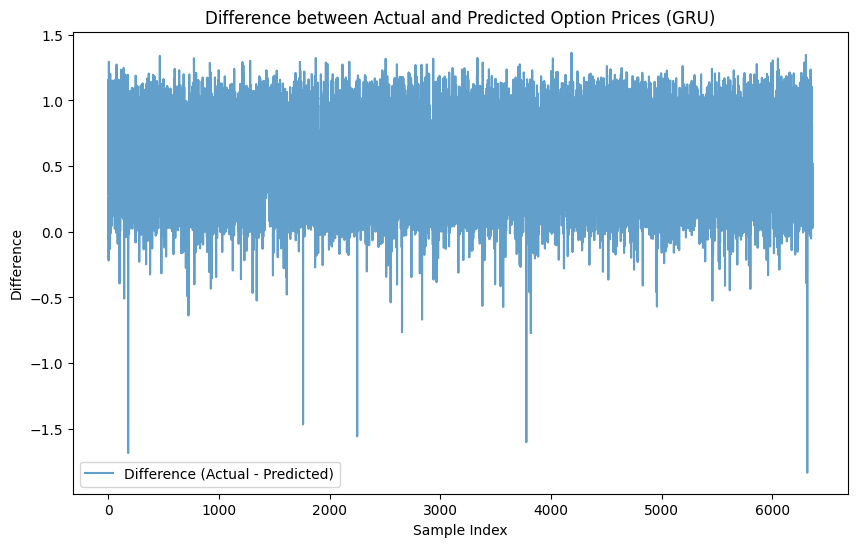

In [61]:
difference = y_test.values - y_pred_gru.flatten()

# Plot the difference
plt.figure(figsize=(10, 6))
plt.plot(difference, label='Difference (Actual - Predicted)', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('Difference')
plt.title('Difference between Actual and Predicted Option Prices (GRU)')
plt.legend()
plt.show()

In [111]:
y_pred_gru = gru_model_log.predict(X_test_gru)

199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


fractions statistics
Min: -0.15049785686654382
Max: 0.7532542288965469
Mean: 0.002973421722250875
Std: 0.023751132484019232


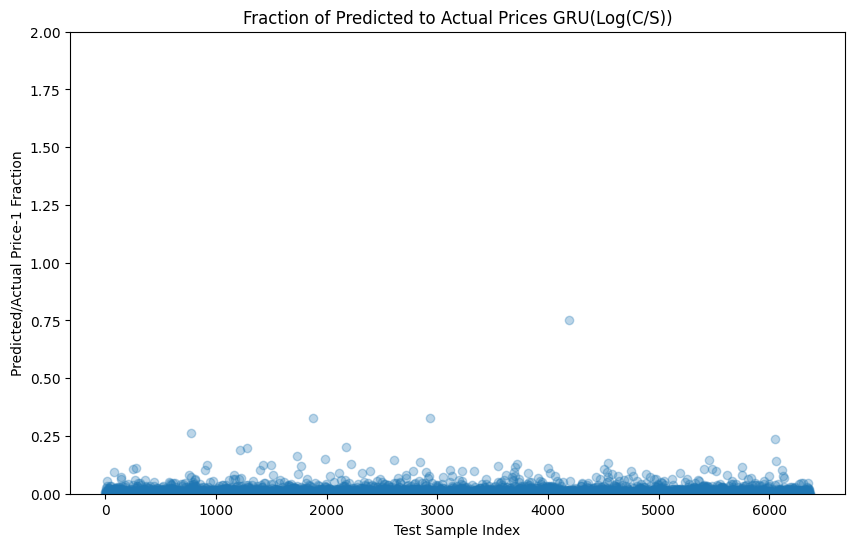

In [112]:

y_test = y_test.reset_index(drop=True)
newper_gru_log = pd.Series(y_pred_gru.flatten(), name='Predictions')
# Combine them into a DataFrame
frac_gru_log = pd.DataFrame({'Actual': y_test, 'Predicted': newper_gru_log})

y_testf = frac_gru_log['Actual'].values
y_predf = frac_gru_log['Predicted'].values

# Calculate the fractions
fractionsf = y_predf / y_testf-1

# Print statistics for fractions
print("fractions statistics")
print("Min:", np.min(fractionsf))
print("Max:", np.max(fractionsf))
print("Mean:", np.mean(fractionsf))
print("Std:", np.std(fractionsf))

# Plot the fractions
plt.figure(figsize=(10, 6))
plt.plot(fractionsf, 'o', alpha=0.3)
plt.xlabel('Test Sample Index')
plt.ylabel('Predicted/Actual Price-1 Fraction')
plt.title('Fraction of Predicted to Actual Prices GRU(Log(C/S))')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

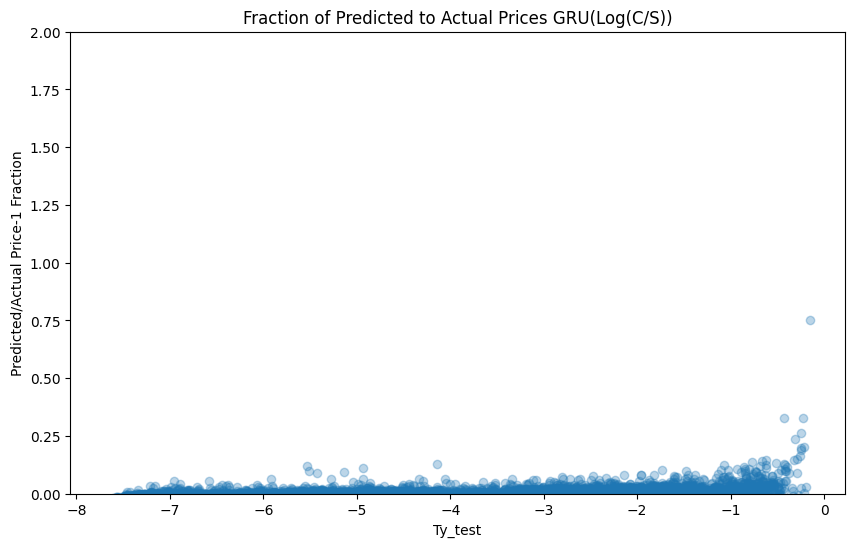

In [113]:
plt.figure(figsize=(10, 6))
plt.plot(y_testf,fractionsf, 'o', alpha=0.3)
plt.xlabel('Ty_test')
plt.ylabel('Predicted/Actual Price-1 Fraction')
plt.title('Fraction of Predicted to Actual Prices GRU(Log(C/S))')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

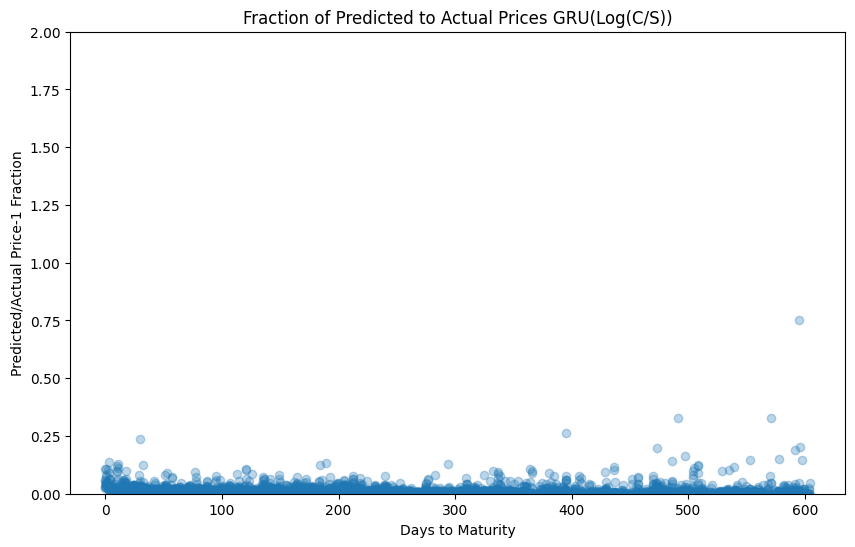

In [116]:



# Plot the fractions
plt.figure(figsize=(10, 6))
plt.plot(X_test['Maturity'].values*252,fractionsf, 'o', alpha=0.3)
plt.xlabel('Days to Maturity')
plt.ylabel('Predicted/Actual Price-1 Fraction')
plt.title('Fraction of Predicted to Actual Prices GRU(Log(C/S))')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

# garch

In [37]:
feature_columns = ['IV', 'K/S', 'Maturity', 'r', 'cond_vol']
target_column = 'C/S'

In [38]:
data = data.dropna()

In [39]:
# Split the data into features and target
X = data[feature_columns]
y = data[target_column]

In [40]:
# Split the data into features and target
X = data[feature_columns]
y = data[target_column]
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [42]:





# Display the shapes of the resulting datasets
X_train.shape, X_test.shape, y_train.shape, y_test.shape
# Initialize the scaler
scaler = StandardScaler()



model_ML_garch = Sequential()

model_ML_garch.add(Dense(30, input_dim=5))
model_ML_garch.add(LeakyReLU())
model_ML_garch.add(Dense(60))
model_ML_garch.add(ELU())
model_ML_garch.add(Dense(90))
model_ML_garch.add(LeakyReLU())
model_ML_garch.add(Dense(1))

ML_prediction_start_time = time.time()
model_ML_garch.compile(loss='mean_squared_error', optimizer='adam')


C:\Users\spin 3\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [43]:
history_model_ML_garch = model_ML_garch.fit(X_train, y_train, epochs=100, batch_size=15, verbose=0)
ML_prediction_end_time = time.time()
ML_prediction_time = ML_prediction_end_time - ML_prediction_start_time
print(ML_prediction_time)
final_loss = history_model_ML_garch.history['loss'][-1]
print(f"   Last log loss: {final_loss:.10f}")

169.71758341789246
   Last log loss: 0.0000405678


In [45]:

y_pred_ML = model_ML_garch.predict(X_test)
rmse_ML = np.sqrt(mean_squared_error(y_test,y_pred_ML))
mae_ML = mean_absolute_error(y_test, y_pred_ML)
mse_ML = mean_squared_error(y_test,y_pred_ML)
print(f"   MSA: {rmse_ML:.10f}")
print(f"   MAE: {mae_ML :.10f}")
print(f"   MSE: {mse_ML :.10f}") 
print("r-squared = {:.3f}".format(r2_score(y_test, y_pred_ML)))


199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
   MSA: 0.0060045831
   MAE: 0.0034926915
   MSE: 0.0000360550
r-squared = 0.998


In [61]:
history_model_ML_garch = model_ML_garch.fit(X_train, y_train, epochs=100, batch_size=15, verbose=0)
ML_prediction_end_time = time.time()
ML_prediction_time = ML_prediction_end_time - ML_prediction_start_time
print(ML_prediction_time)
final_loss = history_model_ML_garch.history['loss'][-1]
print(f"   Last log loss: {final_loss:.10f}")
y_pred_ML = model_ML_garch.predict(X_test)
rmse_ML = np.sqrt(mean_squared_error(y_test,y_pred_ML))
mae_ML = mean_absolute_error(y_test, y_pred_ML)
mse_ML = mean_squared_error(y_test,y_pred_ML)
print(f"   MSA: {rmse_ML:.10f}")
print(f"   MAE: {mae_ML :.10f}")
print(f"   MSE: {mse_ML :.10f}") 
print("r-squared = {:.3f}".format(r2_score(y_test, y_pred_ML)))

2678.0087854862213
   Last log loss: 0.0000363100
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step
   MSA: 0.0063766701
   MAE: 0.0035905884
   MSE: 0.0000406619
r-squared = 0.998


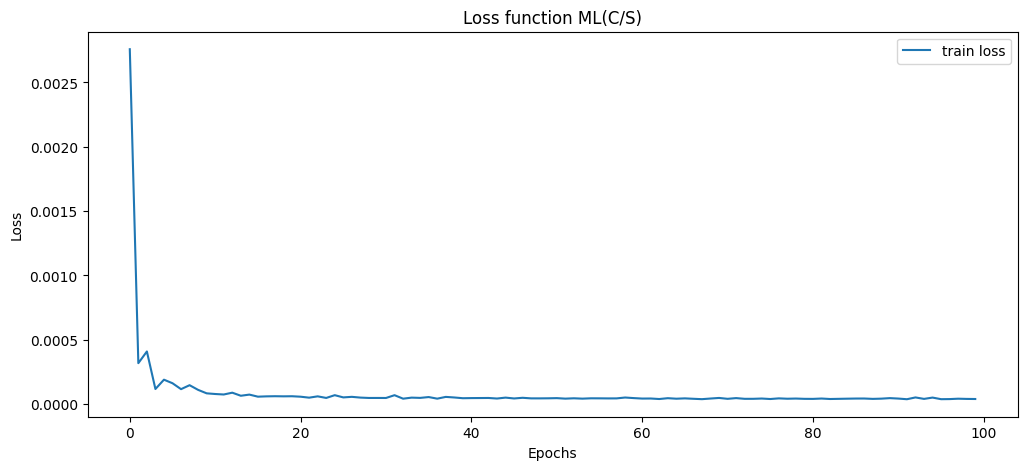

In [37]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(history_model_ML_garch.history["loss"], label="train loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Loss function ML(C/S)')
#ax.plot(history.history["accuracy"], label="train accuracy")
#ax.plot(history.history["val_loss"], label="validation loss")
#ax.plot(history.history["val_accuracy"], label="validation accuracy")
ax.legend()

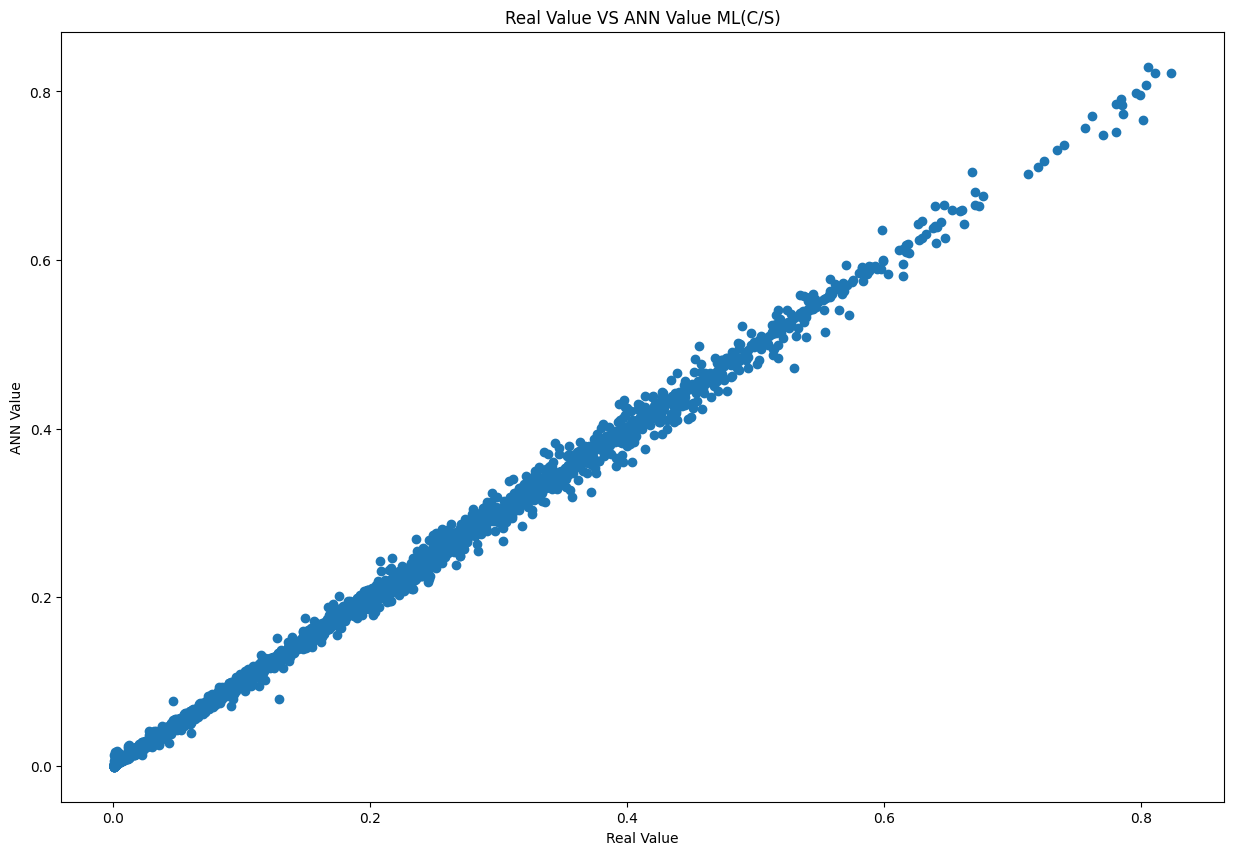

In [58]:

# Comparison of real values and predictions on the test dataset
plt.figure(figsize=(15, 10))
plt.scatter(y_test, y_pred_ML)
plt.xlabel("Real Value")
plt.ylabel("ANN Value")
plt.annotate("r-squared = {:.3f}".format(r2_score(y_test, y_pred_ML)), (20, 1), size=15)
plt.title('Real Value VS ANN Value ML(C/S)')
plt.show()

In [46]:
# Resetting the indices to ensure alignment
y_test = y_test.reset_index(drop=True)
y_pred_ML = pd.Series(y_pred_ML.flatten(), name='Predictions')
#frac_ML = pd.DataFrame({'Actual':y_test, 'Predicted': y_pred_ML})
# Combine them into a DataFrame
frac_ML = pd.DataFrame({'Actual':(y_test), 'Predicted': (y_pred_ML)})

y_testf = frac_ML['Actual'].values
y_predf = frac_ML['Predicted'].values

# Calculate the fractions
fractionsf = y_predf / y_testf-1

fractions statistics
Min: -3.3184826999902723
Max: 17.10926723147609
Mean: 0.1991924771284845
Std: 0.5756761666011664


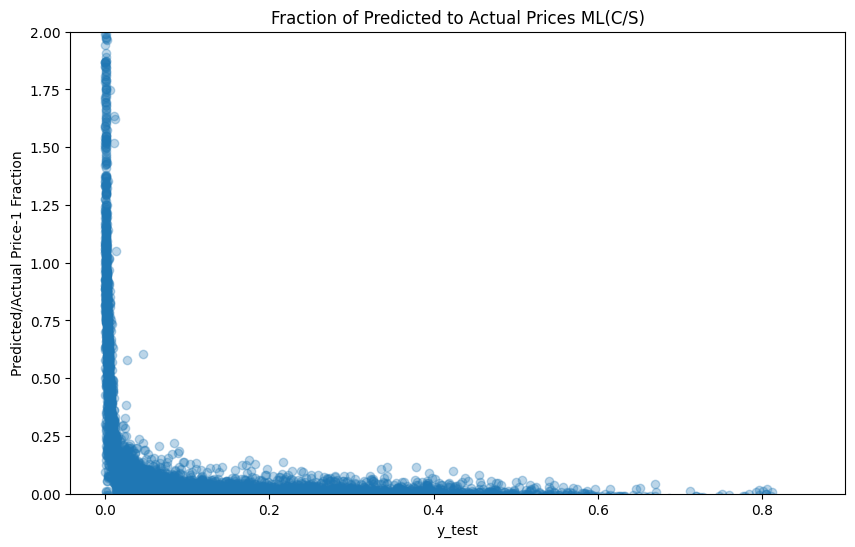

In [48]:








# Print statistics for fractions
print("fractions statistics")
print("Min:", np.min(fractionsf))
print("Max:", np.max(fractionsf))
print("Mean:", np.mean(fractionsf))
print("Std:", np.std(fractionsf))

# Plot the fractions
plt.figure(figsize=(10, 6))
plt.plot(y_testf,fractionsf, 'o', alpha=0.3)
plt.xlabel('y_test')
plt.ylabel('Predicted/Actual Price-1 Fraction')
plt.title('Fraction of Predicted to Actual Prices ML(C/S)')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

fractions statistics
Min: -4.309793509542942
Max: 16.120310566654158
Mean: -0.01206813885376893
Std: 0.39047304863551513


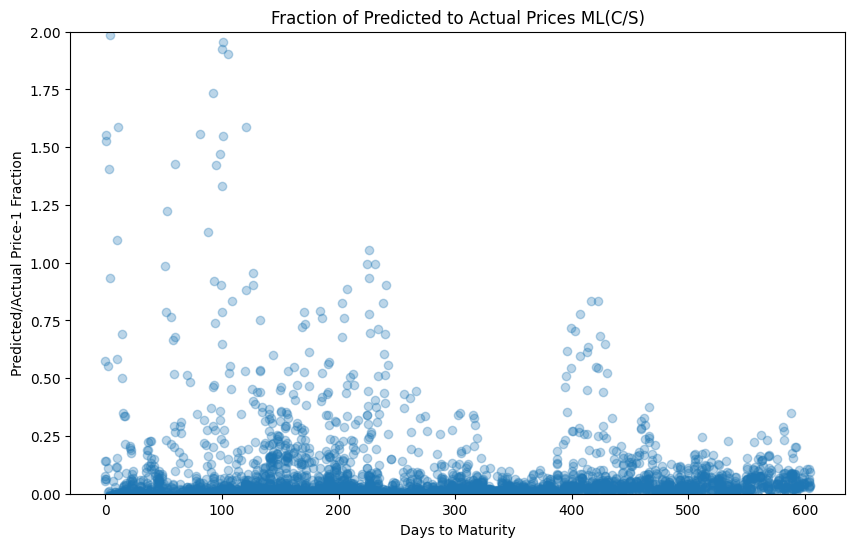

In [65]:


# Print statistics for fractions
print("fractions statistics")
print("Min:", np.min(fractionsf))
print("Max:", np.max(fractionsf))
print("Mean:", np.mean(fractionsf))
print("Std:", np.std(fractionsf))

# Plot the fractions
plt.figure(figsize=(10, 6))
plt.plot(X_test['Maturity'].values*252,fractionsf, 'o', alpha=0.3)
plt.xlabel('Days to Maturity')
plt.ylabel('Predicted/Actual Price-1 Fraction')
plt.title('Fraction of Predicted to Actual Prices ML(C/S)')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

fractions statistics
Min: -2.8822588389739394
Max: 15.150645324960347
Mean: 0.026373429723087684
Std: 0.4280872748043131


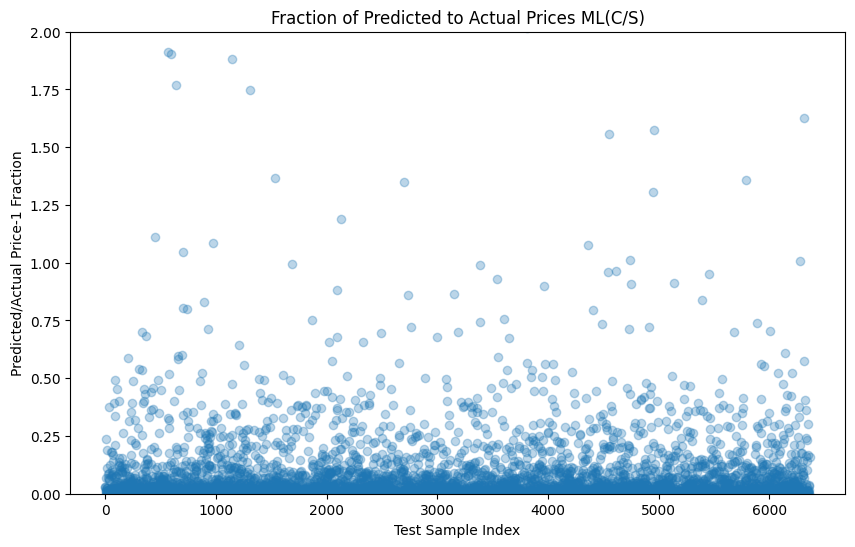

In [59]:



# Resetting the indices to ensure alignment
y_test = y_test.reset_index(drop=True)
y_pred_ML = pd.Series(y_pred_ML.flatten(), name='Predictions')
#frac_ML = pd.DataFrame({'Actual':y_test, 'Predicted': y_pred_ML})
# Combine them into a DataFrame
frac_ML = pd.DataFrame({'Actual':(y_test), 'Predicted': (y_pred_ML)})




y_testf = frac_ML['Actual'].values
y_predf = frac_ML['Predicted'].values

# Calculate the fractions
fractionsf = y_predf / y_testf-1

# Print statistics for fractions
print("fractions statistics")
print("Min:", np.min(fractionsf))
print("Max:", np.max(fractionsf))
print("Mean:", np.mean(fractionsf))
print("Std:", np.std(fractionsf))

# Plot the fractions
plt.figure(figsize=(10, 6))
plt.plot(fractionsf, 'o', alpha=0.3)
plt.xlabel('Test Sample Index')
plt.ylabel('Predicted/Actual Price-1 Fraction')
plt.title('Fraction of Predicted to Actual Prices ML(C/S)')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
# Split the data into training and testing sets


# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the data for LSTM
X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Improved LSTM model
def create_improved_lstm_model():
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(1, 5)))
    model.add(LSTM(units=100, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=50, activation='elu'))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

lstm_model_garch = create_improved_lstm_model()
lstm_history_garch = lstm_model_garch.fit(X_train_lstm, y_train, epochs=150, batch_size=16, verbose=0)

# Evaluate the model
train_loss = lstm_model_garch.evaluate(X_train_lstm, y_train, verbose=0)
test_loss = lstm_model_garch.evaluate(X_test_lstm, y_test, verbose=0)



C:\Users\spin 3\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


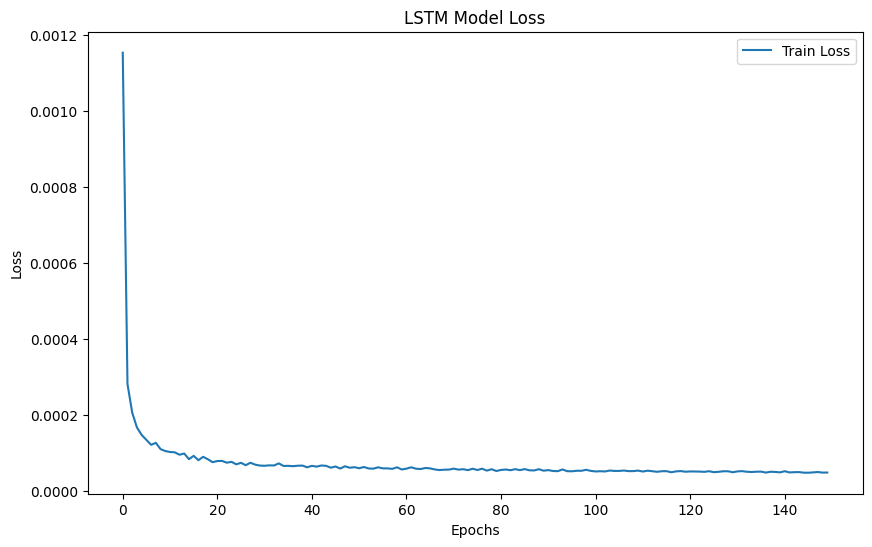

Train Loss: 5.083395808469504e-05
Test Loss: 5.495244113262743e-05


In [63]:
# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(lstm_history_garch.history['loss'], label='Train Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(f'Train Loss: {train_loss}')
print(f'Test Loss: {test_loss}')


In [116]:
final_loss = lstm_history_garch.history['loss'][-1]
print(f"   Last log loss: {final_loss:.10f}")
y_pred_LSTM = lstm_model_garch.predict(X_test_lstm)
rmse_LSTM = np.sqrt(mean_squared_error(y_test,y_pred_LSTM))
mae_LSTM = mean_absolute_error(y_test, y_pred_LSTM)
mse_LSTM = mean_squared_error(y_test,y_pred_LSTM)
r2_lstm = r2_score(y_test, y_pred_LSTM)
print(f"LSTM R-squared: {r2_lstm:.3f}")
print(f"   MSA: {rmse_LSTM:.10f}")
print(f"   MAE: {mae_LSTM :.10f}")
print(f"   MSE: {mse_LSTM :.10f}")  

   Last log loss: 0.0000491792
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
LSTM R-squared: 0.997
   MSA: 0.0074129922
   MAE: 0.0044131050
   MSE: 0.0000549525


In [52]:
final_loss = lstm_history_garch.history['loss'][-1]
print(f"   Last log loss: {final_loss:.10f}")
y_pred_LSTM = lstm_model_garch.predict(X_test_lstm)
rmse_LSTM = np.sqrt(mean_squared_error(y_test,y_pred_LSTM))
mae_LSTM = mean_absolute_error(y_test, y_pred_LSTM)
mse_LSTM = mean_squared_error(y_test,y_pred_LSTM)
r2_lstm = r2_score(y_test, y_pred_LSTM)
print(f"LSTM R-squared: {r2_lstm:.3f}")
print(f"   MSA: {rmse_LSTM:.10f}")
print(f"   MAE: {mae_LSTM :.10f}")
print(f"   MSE: {mse_LSTM :.10f}")  

   Last log loss: 0.0000486678
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
LSTM R-squared: 0.998
   MSA: 0.0064294161
   MAE: 0.0034918969
   MSE: 0.0000413374


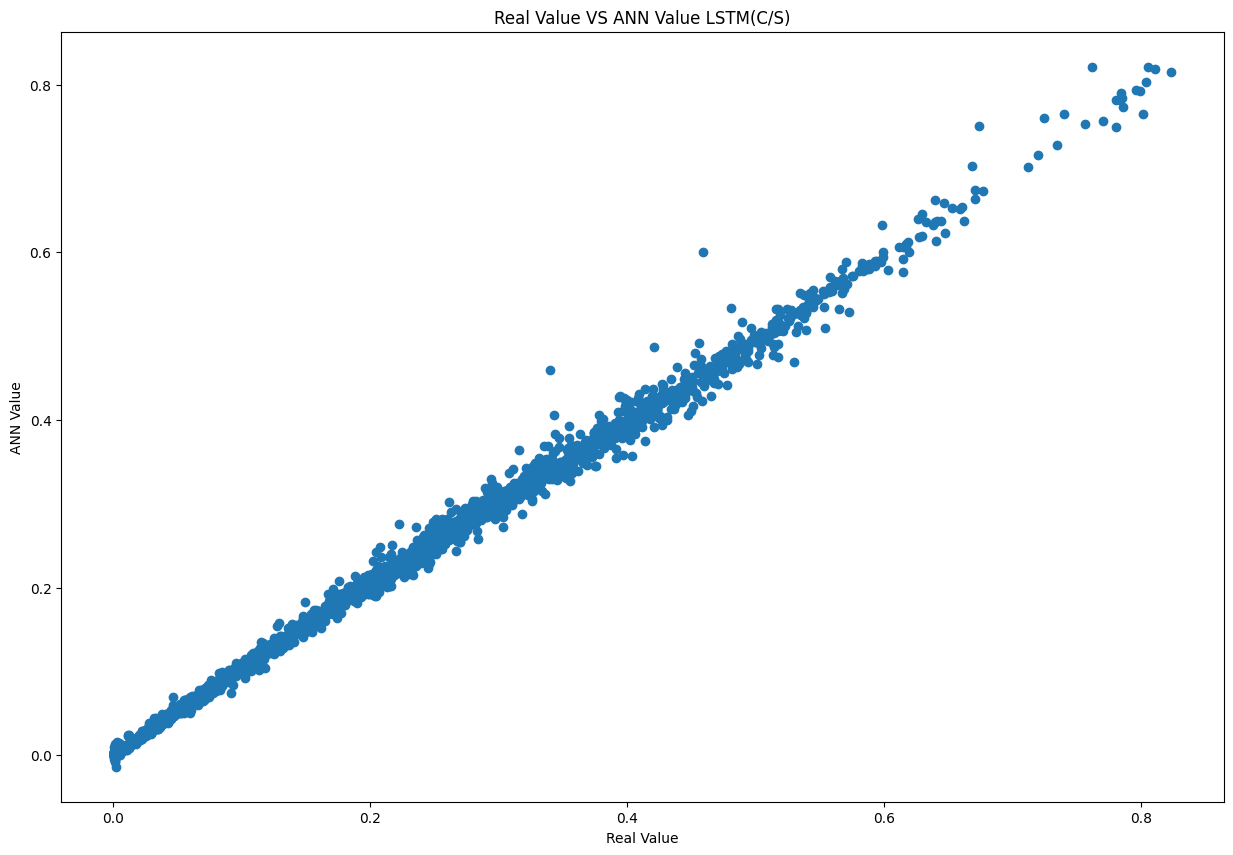

In [65]:
# Comparison of real values and predictions on the test dataset
plt.figure(figsize=(15, 10))
plt.scatter(y_test, y_pred_LSTM)
plt.xlabel("Real Value")
plt.ylabel("ANN Value")
plt.annotate("r-squared = {:.3f}".format(r2_score(y_test, y_pred_ML)), (20, 1), size=15)
plt.title('Real Value VS ANN Value LSTM(C/S)')
plt.show()

In [53]:
# Resetting the indices to ensure alignment
y_test = y_test.reset_index(drop=True)
y_pred_LSTM= pd.Series(y_pred_LSTM.flatten(), name='Predictions')
#frac_ML = pd.DataFrame({'Actual':y_test, 'Predicted': y_pred_ML})
# Combine them into a DataFrame
frac_ML = pd.DataFrame({'Actual':(y_test), 'Predicted': (y_pred_LSTM)})

# Save the DataFrame to a CSV file
frac_ML.to_csv('frac_ML.csv', index=False)


y_testf = frac_ML['Actual'].values
y_predf = frac_ML['Predicted'].values

# Calculate the fractions
fractionsf = y_predf / y_testf-1

fractions statistics
Min: -9.265446146329245
Max: 11.191748323717285
Mean: 0.06022788701916533
Std: 0.42794705441774994


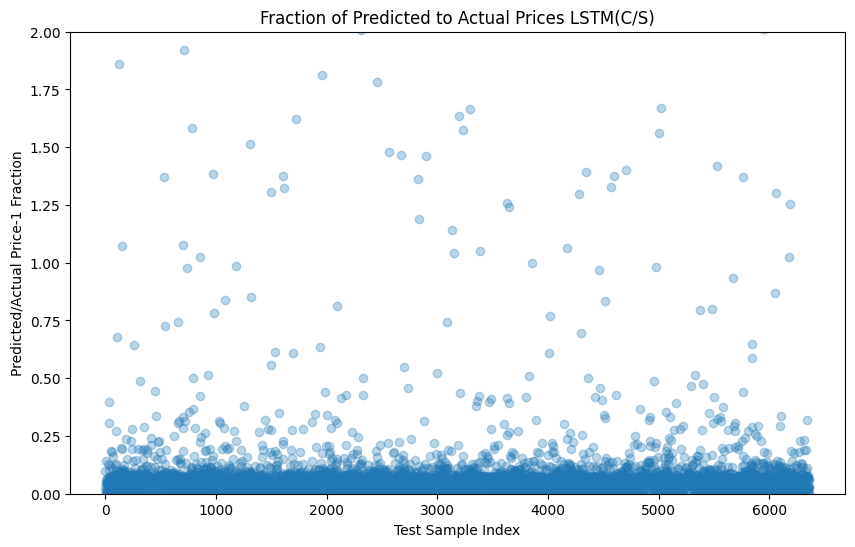

In [66]:


# Print statistics for fractions
print("fractions statistics")
print("Min:", np.min(fractionsf))
print("Max:", np.max(fractionsf))
print("Mean:", np.mean(fractionsf))
print("Std:", np.std(fractionsf))

# Plot the fractions
plt.figure(figsize=(10, 6))
plt.plot(fractionsf, 'o', alpha=0.3)
plt.xlabel('Test Sample Index')
plt.ylabel('Predicted/Actual Price-1 Fraction')
plt.title('Fraction of Predicted to Actual Prices LSTM(C/S)')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

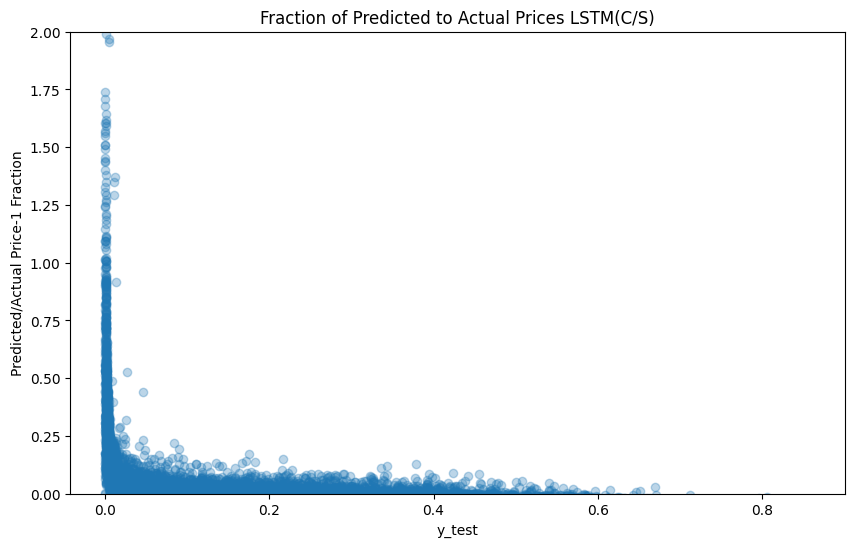

In [54]:


# Plot the fractions
plt.figure(figsize=(10, 6))
plt.plot(y_testf,fractionsf, 'o', alpha=0.3)
plt.xlabel('y_test')
plt.ylabel('Predicted/Actual Price-1 Fraction')
plt.title('Fraction of Predicted to Actual Prices LSTM(C/S)')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

fractions statistics
Min: -6.320917505770922
Max: 13.338506511279512
Mean: 0.09189615071755822
Std: 0.3203944086144582


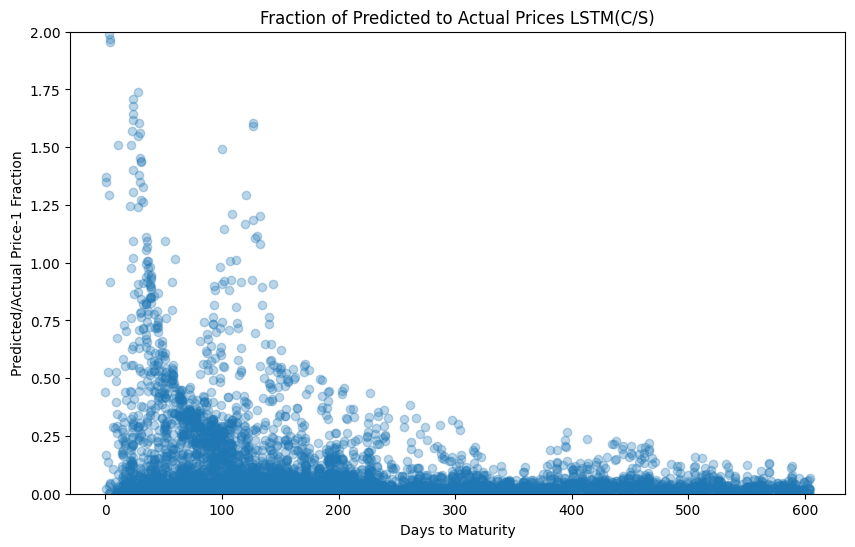

In [56]:
# Print statistics for fractions
print("fractions statistics")
print("Min:", np.min(fractionsf))
print("Max:", np.max(fractionsf))
print("Mean:", np.mean(fractionsf))
print("Std:", np.std(fractionsf))

# Plot the fractions
plt.figure(figsize=(10, 6))
plt.plot(X_test['Maturity'].values*252,fractionsf, 'o', alpha=0.3)
plt.xlabel('Days to Maturity')
plt.ylabel('Predicted/Actual Price-1 Fraction')
plt.title('Fraction of Predicted to Actual Prices LSTM(C/S)')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
# Split the data into training and testing sets


# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the data for LSTM
X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

def create_gru_model():
    model = Sequential()
    model.add(GRU(units=100, return_sequences=True, input_shape=(1, 5)))
    
    model.add(GRU(units=100, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(units=50, activation='elu'))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

gru_model_garch = create_gru_model()
gru_history_garch = gru_model_garch.fit(X_train_lstm, y_train, epochs=150, batch_size=16, verbose=0)

# Evaluate the model
train_loss = gru_model_garch.evaluate(X_train_lstm, y_train, verbose=0)
test_loss = gru_model_garch.evaluate(X_test_lstm, y_test, verbose=0)


C:\Users\spin 3\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


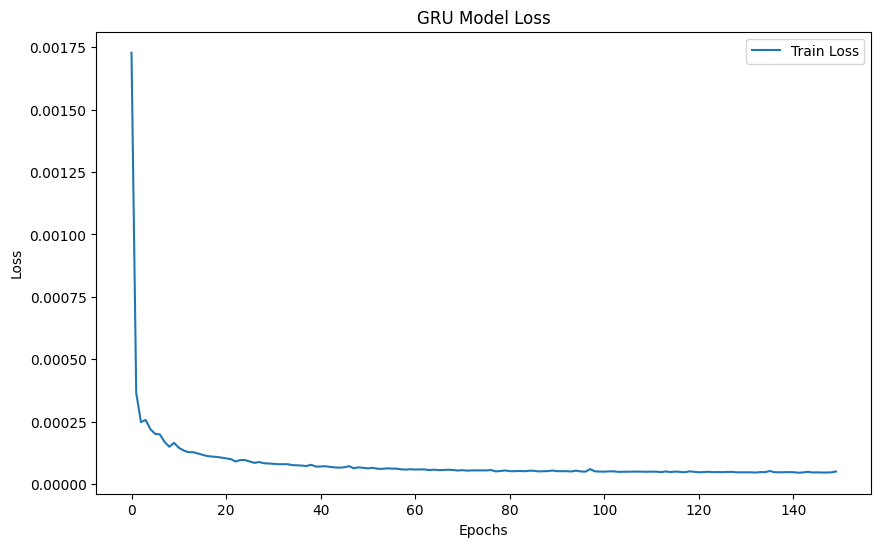

Train Loss: 3.1526684324489906e-05
Test Loss: 3.311480031698011e-05


In [41]:
# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(gru_history_garch.history['loss'], label='Train Loss')
plt.title('GRU Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(f'Train Loss: {train_loss}')
print(f'Test Loss: {test_loss}')


In [67]:
final_loss = gru_history_garch.history['loss'][-1]
print(f"   Last log loss: {final_loss:.10f}")
y_pred_gru = lstm_model_garch.predict(X_test_lstm)
rmse_LSTM = np.sqrt(mean_squared_error(y_test,y_pred_gru))
mae_LSTM = mean_absolute_error(y_test, y_pred_gru)
mse_LSTM = mean_squared_error(y_test,y_pred_gru)
r2_lstm = r2_score(y_test, y_pred_gru)
print(f"LSTM R-squared: {r2_lstm:.3f}")
print(f"   MSA: {rmse_LSTM:.10f}")
print(f"   MAE: {mae_LSTM :.10f}")
print(f"   MSE: {mse_LSTM :.10f}")  

   Last log loss: 0.0000505218
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
LSTM R-squared: 0.998
   MSA: 0.0064294161
   MAE: 0.0034918969
   MSE: 0.0000413374


In [121]:
final_loss = gru_history_garch.history['loss'][-1]
print(f"   Last log loss: {final_loss:.10f}")
y_pred_gru = lstm_model_garch.predict(X_test_lstm)
rmse_LSTM = np.sqrt(mean_squared_error(y_test,y_pred_gru))
mae_LSTM = mean_absolute_error(y_test, y_pred_gru)
mse_LSTM = mean_squared_error(y_test,y_pred_gru)
r2_lstm = r2_score(y_test, y_pred_gru)
print(f"LSTM R-squared: {r2_lstm:.3f}")
print(f"   MSA: {rmse_LSTM:.10f}")
print(f"   MAE: {mae_LSTM :.10f}")
print(f"   MSE: {mse_LSTM :.10f}")  

   Last log loss: 0.0000459835
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
LSTM R-squared: 0.997
   MSA: 0.0074129922
   MAE: 0.0044131050
   MSE: 0.0000549525


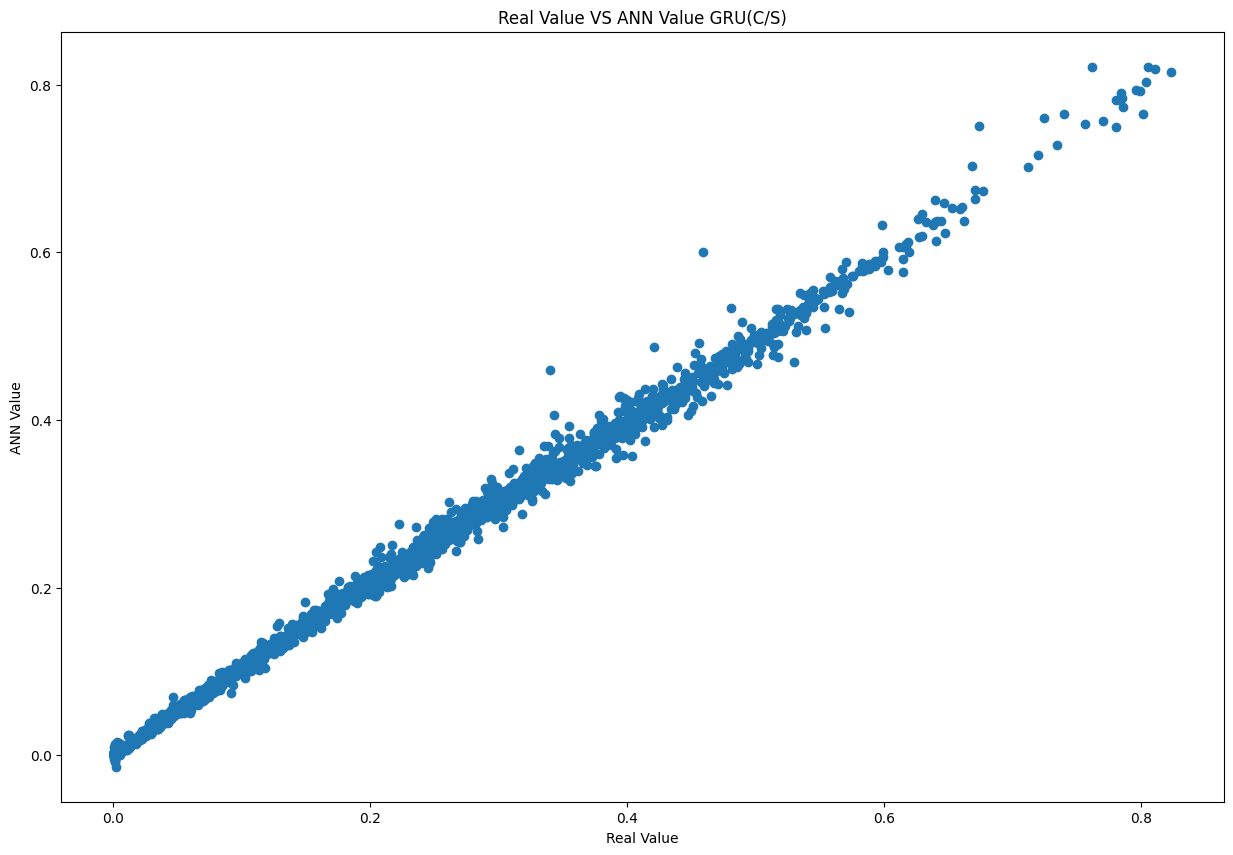

In [118]:
# Comparison of real values and predictions on the test dataset
plt.figure(figsize=(15, 10))
plt.scatter(y_test, y_pred_gru)
plt.xlabel("Real Value")
plt.ylabel("ANN Value")

plt.title('Real Value VS ANN Value GRU(C/S)')
plt.show()

In [49]:
y_pred_gru = gru_model_garch.predict(X_test_lstm)

199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [50]:
# Resetting the indices to ensure alignment
y_test = y_test.reset_index(drop=True)
y_pred_gru= pd.Series(y_pred_gru.flatten(), name='Predictions')
#frac_ML = pd.DataFrame({'Actual':y_test, 'Predicted': y_pred_ML})
# Combine them into a DataFrame
frac_ML = pd.DataFrame({'Actual':(y_test), 'Predicted': (y_pred_gru)})

# Save the DataFrame to a CSV file
frac_ML.to_csv('frac_ML.csv', index=False)


y_testf = frac_ML['Actual'].values
y_predf = frac_ML['Predicted'].values

# Calculate the fractions
fractionsf = y_predf / y_testf-1

fractions statistics
Min: -1.1064097881317139
Max: 12.751529936279567
Mean: 0.23570599782016105
Std: 0.5704270790623265


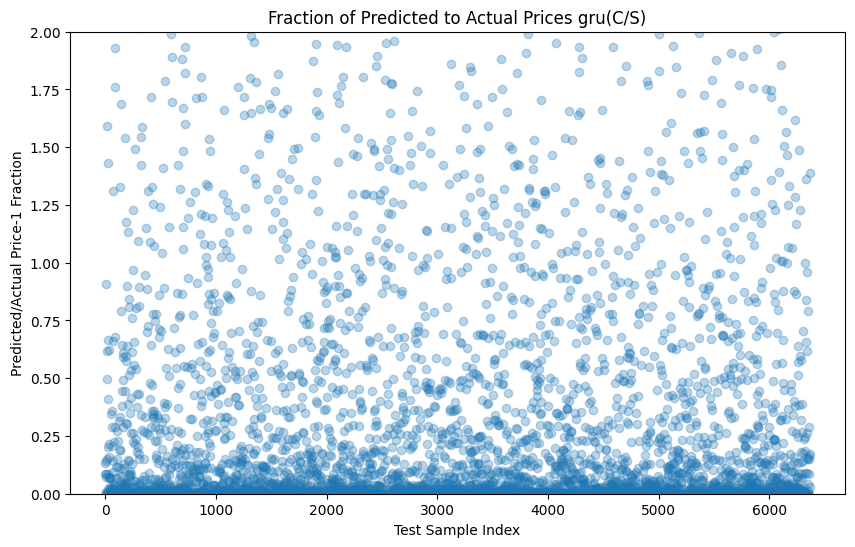

In [51]:
# Print statistics for fractions
print("fractions statistics")
print("Min:", np.min(fractionsf))
print("Max:", np.max(fractionsf))
print("Mean:", np.mean(fractionsf))
print("Std:", np.std(fractionsf))

# Plot the fractions
plt.figure(figsize=(10, 6))
plt.plot(fractionsf, 'o', alpha=0.3)
plt.xlabel('Test Sample Index')
plt.ylabel('Predicted/Actual Price-1 Fraction')
plt.title('Fraction of Predicted to Actual Prices gru(C/S)')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

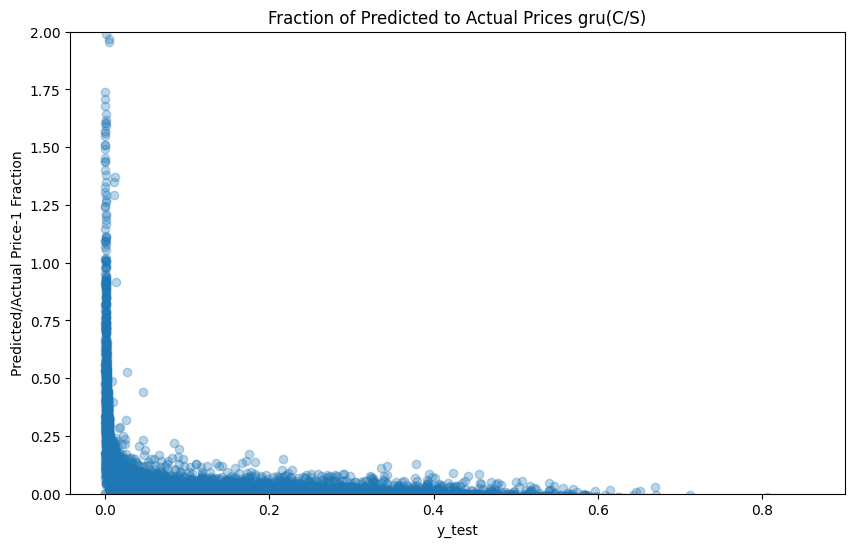

In [69]:
# Plot the fractions
plt.figure(figsize=(10, 6))
plt.plot(y_testf,fractionsf, 'o', alpha=0.3)
plt.xlabel('y_test')
plt.ylabel('Predicted/Actual Price-1 Fraction')
plt.title('Fraction of Predicted to Actual Prices gru(C/S)')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

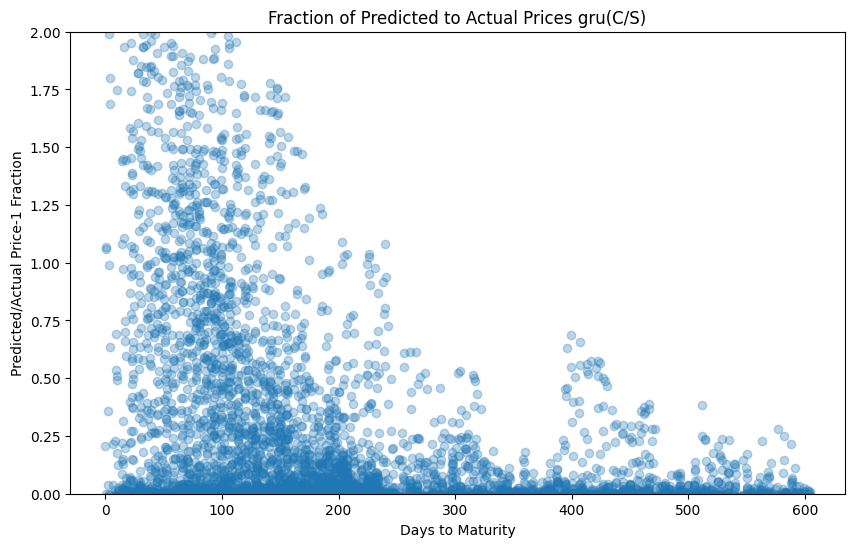

In [54]:
# Plot the fractions
plt.figure(figsize=(10, 6))
plt.plot(X_test['Maturity'].values*252,fractionsf, 'o', alpha=0.3)
plt.xlabel('Days to Maturity')
plt.ylabel('Predicted/Actual Price-1 Fraction')
plt.title('Fraction of Predicted to Actual Prices gru(C/S)')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

fractions statistics
Min: -0.3493107668239027
Max: 0.4039486111137782
Mean: -0.012999218842714386
Std: 0.03505516680870359


C:\Users\spin 3\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


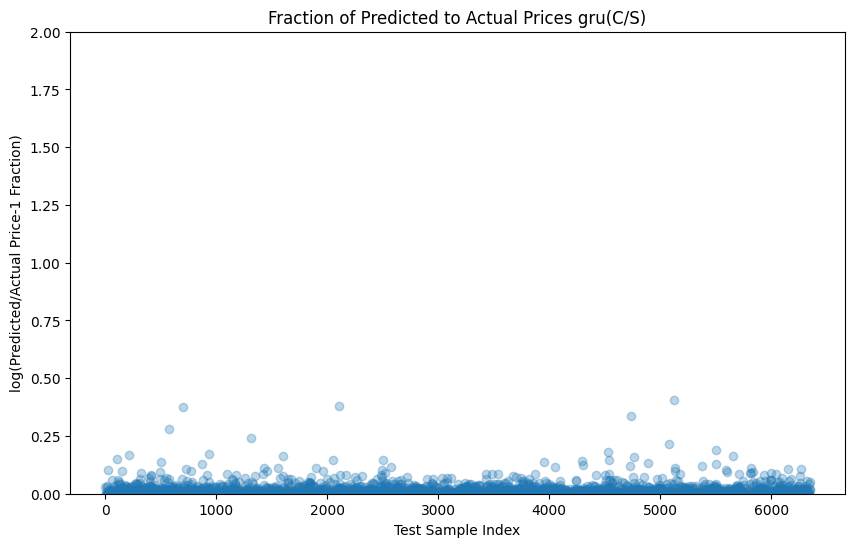

In [120]:

#frac_ML = pd.DataFrame({'Actual':y_test, 'Predicted': y_pred_ML})
# Combine them into a DataFrame
frac_ML = pd.DataFrame({'Actual':np.log(y_test), 'Predicted': np.log(y_pred_gru)})

# Save the DataFrame to a CSV file
frac_ML.to_csv('frac_ML.csv', index=False)
# Drop rows with NaN values
frac_ML = frac_ML.dropna()

# Reset index (optional)
frac_ML = frac_ML.reset_index(drop=True)


y_testf = frac_ML['Actual'].values
y_predf = frac_ML['Predicted'].values

# Calculate the fractions
fractionsf = y_predf / y_testf-1

# Print statistics for fractions
print("fractions statistics")
print("Min:", np.min(fractionsf))
print("Max:", np.max(fractionsf))
print("Mean:", np.mean(fractionsf))
print("Std:", np.std(fractionsf))

# Plot the fractions
plt.figure(figsize=(10, 6))
plt.plot(fractionsf, 'o', alpha=0.3)
plt.xlabel('Test Sample Index')
plt.ylabel('log(Predicted/Actual Price-1 Fraction)')
plt.title('Fraction of Predicted to Actual Prices gru(C/S)')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

# ML_LOG GARCH

In [96]:
feature_columns = ['IV', 'K/S', 'Maturity', 'r', 'cond_vol']
target_column = 'C/S'

In [97]:
# Split the data into features and target
X = data[feature_columns]
y = log(data[target_column])

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [99]:
# Display the shapes of the resulting datasets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((25461, 5), (6366, 5), (25461,), (6366,))

In [100]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Display the shapes of the resulting datasets
X_train.shape, X_test.shape, y_train.shape, y_test.shape
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model_ML_garch_log = Sequential()

model_ML_garch_log.add(Dense(30, input_dim=5))
model_ML_garch_log.add(LeakyReLU())
model_ML_garch_log.add(Dense(60))
model_ML_garch_log.add(ELU())
model_ML_garch_log.add(Dense(90))
model_ML_garch_log.add(LeakyReLU())
model_ML_garch_log.add(Dense(1))

ML_prediction_start_time = time.time()
model_ML_garch_log.compile(loss='mean_squared_error', optimizer='adam')

C:\Users\spin 3\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [101]:
history_model_ML_garch_log = model_ML_garch_log.fit(X_train, y_train, epochs=100, batch_size=15, verbose=0)

In [47]:

ML_prediction_end_time = time.time()
ML_prediction_time = ML_prediction_end_time - ML_prediction_start_time
print(ML_prediction_time)
final_loss = history_model_ML_garch_log.history['loss'][-1]
print(f"   Last log loss: {final_loss:.10f}")
y_pred_ML = model_ML_garch_log.predict(X_test)
rmse_ML = np.sqrt(mean_squared_error(y_test,y_pred_ML))
mae_ML = mean_absolute_error(y_test, y_pred_ML)
mse_ML = mean_squared_error(y_test,y_pred_ML)
print(f"   MSA: {rmse_ML:.10f}")
print(f"   MAE: {mae_ML :.10f}")
print(f"   MSE: {mse_ML :.10f}") 
print("r-squared = {:.3f}".format(r2_score(y_test, y_pred_ML)))

294.31391525268555
   Last log loss: 0.0044167330
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
   MSA: 0.0570045775
   MAE: 0.0322422220
   MSE: 0.0032495219
r-squared = 0.999


In [82]:
history_model_ML_garch_log = model_ML_garch_log.fit(X_train, y_train, epochs=100, batch_size=15, verbose=0)
ML_prediction_end_time = time.time()
ML_prediction_time = ML_prediction_end_time - ML_prediction_start_time
print(ML_prediction_time)
final_loss = history_model_ML_garch_log.history['loss'][-1]
print(f"   Last log loss: {final_loss:.10f}")
y_pred_ML = model_ML_garch_log.predict(X_test)
rmse_ML = np.sqrt(mean_squared_error(y_test,y_pred_ML))
mae_ML = mean_absolute_error(y_test, y_pred_ML)
mse_ML = mean_squared_error(y_test,y_pred_ML)
print(f"   MSA: {rmse_ML:.10f}")
print(f"   MAE: {mae_ML :.10f}")
print(f"   MSE: {mse_ML :.10f}") 
print("r-squared = {:.3f}".format(r2_score(y_test, y_pred_ML)))


372.5730674266815
   Last log loss: 0.0041827252
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
   MSA: 0.0580811039
   MAE: 0.0372009531
   MSE: 0.0033734146
r-squared = 0.999


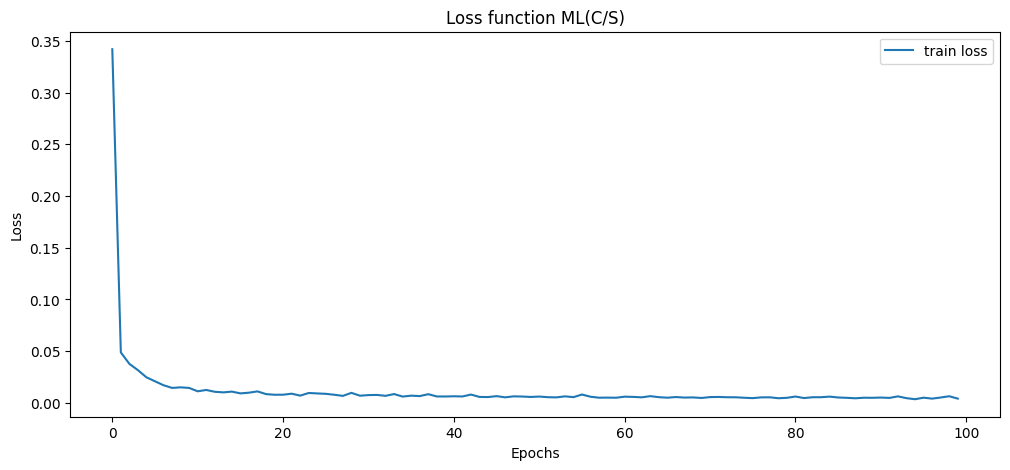

In [83]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(history_model_ML_garch_log.history["loss"], label="train loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Loss function ML(C/S)')
#ax.plot(history.history["accuracy"], label="train accuracy")
#ax.plot(history.history["val_loss"], label="validation loss")
#ax.plot(history.history["val_accuracy"], label="validation accuracy")
ax.legend()

In [ ]:
y_pred_ML = model_ML_garch_log.predict(X_test)

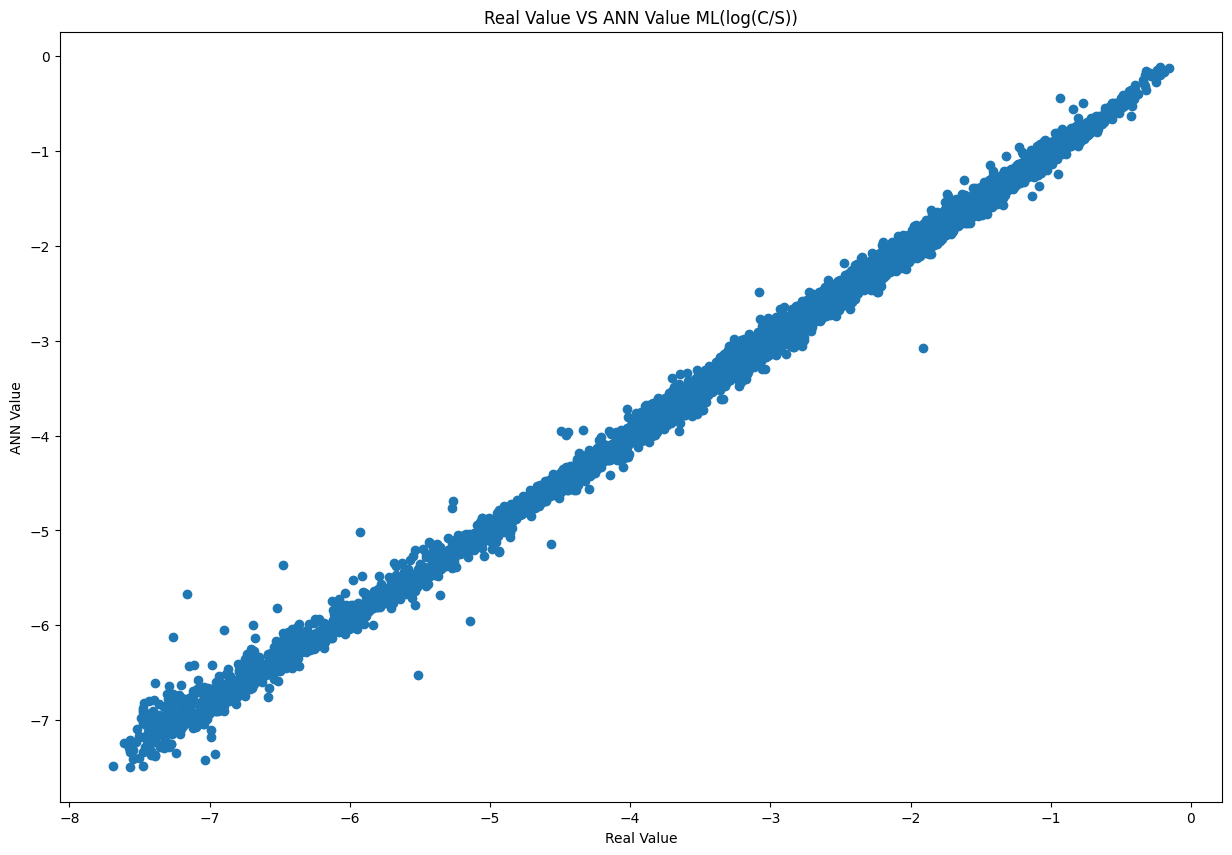

In [130]:

# Comparison of real values and predictions on the test dataset
plt.figure(figsize=(15, 10))
plt.scatter(y_test, y_pred_ML)
plt.xlabel("Real Value")
plt.ylabel("ANN Value")
plt.annotate("r-squared = {:.3f}".format(r2_score(y_test, y_pred_ML)), (20, 1), size=15)
plt.title('Real Value VS ANN Value ML(log(C/S))')
plt.show()

In [ ]:
# Resetting the indices to ensure alignment
y_test = y_test.reset_index(drop=True)
y_pred_ML = pd.Series(y_pred_ML.flatten(), name='Predictions')
#frac_ML = pd.DataFrame({'Actual':y_test, 'Predicted': y_pred_ML})
# Combine them into a DataFrame
frac_ML_garch_log = pd.DataFrame({'Actual':(y_test), 'Predicted': (y_pred_ML)})

In [170]:
y_testf = frac_ML_garch_log['Actual'].values
y_predf = frac_ML_garch_log['Predicted'].values

# Calculate the fractions
fractionsf = y_predf / y_testf-1

fractions statistics
Min: -0.5526952597518816
Max: 0.15401421349672506
Mean: -0.012122470806071267
Std: 0.028322721683173284


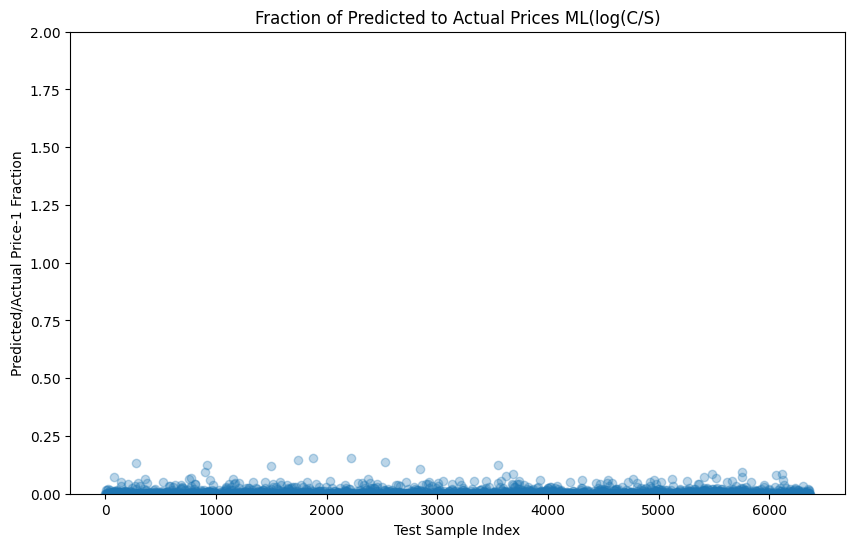

In [90]:


# Print statistics for fractions
print("fractions statistics")
print("Min:", np.min(fractionsf))
print("Max:", np.max(fractionsf))
print("Mean:", np.mean(fractionsf))
print("Std:", np.std(fractionsf))

# Plot the fractions
plt.figure(figsize=(10, 6))
plt.plot(fractionsf, 'o', alpha=0.3)
plt.xlabel('Test Sample Index')
plt.ylabel('Predicted/Actual Price-1 Fraction')
plt.title('Fraction of Predicted to Actual Prices ML(log(C/S)')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

fractions statistics
Min: -0.5526952597518816
Max: 0.15401421349672506
Mean: -0.012122470806071267
Std: 0.028322721683173284


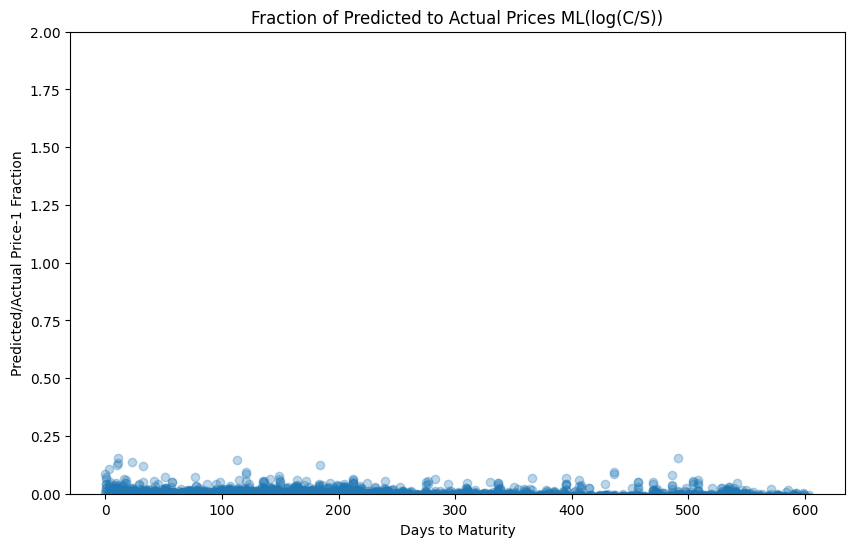

In [91]:
# Print statistics for fractions
print("fractions statistics")
print("Min:", np.min(fractionsf))
print("Max:", np.max(fractionsf))
print("Mean:", np.mean(fractionsf))
print("Std:", np.std(fractionsf))

# Plot the fractions
plt.figure(figsize=(10, 6))
plt.plot(X_test['Maturity'].values*252,fractionsf, 'o', alpha=0.3)
plt.xlabel('Days to Maturity')
plt.ylabel('Predicted/Actual Price-1 Fraction')
plt.title('Fraction of Predicted to Actual Prices ML(log(C/S))')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

fractions statistics
Min: -0.5526952597518816
Max: 0.15401421349672506
Mean: -0.012122470806071267
Std: 0.028322721683173284


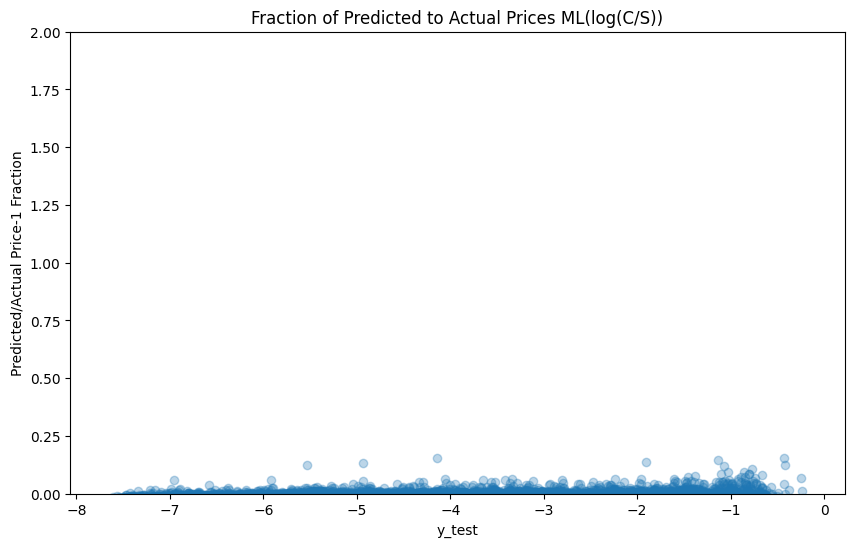

In [171]:
# Print statistics for fractions
print("fractions statistics")
print("Min:", np.min(fractionsf))
print("Max:", np.max(fractionsf))
print("Mean:", np.mean(fractionsf))
print("Std:", np.std(fractionsf))

# Plot the fractions
plt.figure(figsize=(10, 6))
plt.plot(y_testf,fractionsf, 'o', alpha=0.3)
plt.xlabel('y_test')
plt.ylabel('Predicted/Actual Price-1 Fraction')
plt.title('Fraction of Predicted to Actual Prices ML(log(C/S))')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

# LSTM_LOG

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [157]:
# Split the data into training and testing sets
# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the data for LSTM
X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Improved LSTM model
def create_improved_lstm_model():
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(1, 5)))
    model.add(LSTM(units=100, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=50, activation='elu'))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

lstm_model_garch_log = create_improved_lstm_model()
lstm_history_garch_log = lstm_model_garch_log.fit(X_train_lstm, y_train, epochs=150, batch_size=16, verbose=0)

# Evaluate the model
train_loss = lstm_model_garch_log.evaluate(X_train_lstm, y_train, verbose=0)
test_loss = lstm_model_garch_log.evaluate(X_test_lstm, y_test, verbose=0)



C:\Users\spin 3\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


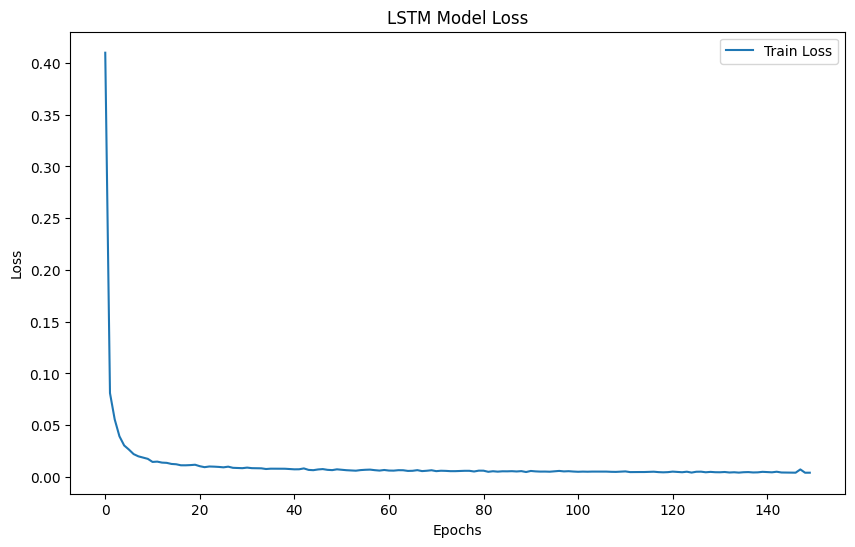

Train Loss: 0.006632489152252674
Test Loss: 0.006465633865445852


In [94]:
# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(lstm_history_garch_log.history['loss'], label='Train Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(f'Train Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

In [95]:
final_loss = lstm_history_garch_log.history['loss'][-1]
print(f"   Last log loss: {final_loss:.10f}")
y_pred_LSTM = lstm_model_garch_log.predict(X_test_lstm)
rmse_LSTM = np.sqrt(mean_squared_error(y_test,y_pred_LSTM))
mae_LSTM = mean_absolute_error(y_test, y_pred_LSTM)
mse_LSTM = mean_squared_error(y_test,y_pred_LSTM)
r2_lstm = r2_score(y_test, y_pred_LSTM)
print(f"LSTM R-squared: {r2_lstm:.3f}")
print(f"   MSA: {rmse_LSTM:.10f}")
print(f"   MAE: {mae_LSTM :.10f}")
print(f"   MSE: {mse_LSTM :.10f}")  

   Last log loss: 0.0041297306
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
LSTM R-squared: 0.998
   MSA: 0.0804091705
   MAE: 0.0482149686
   MSE: 0.0064656347


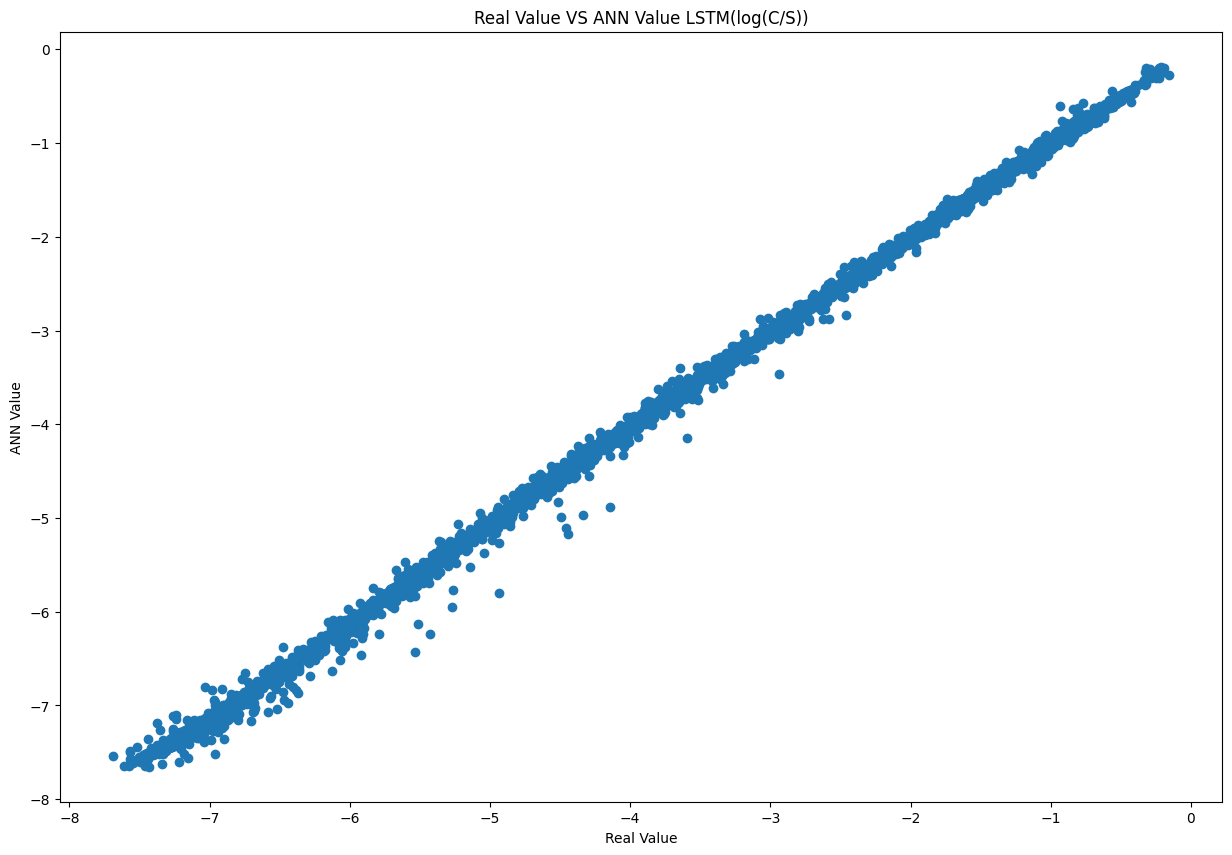

In [96]:
# Comparison of real values and predictions on the test dataset
plt.figure(figsize=(15, 10))
plt.scatter(y_test, y_pred_LSTM)
plt.xlabel("Real Value")
plt.ylabel("ANN Value")
plt.annotate("r-squared = {:.3f}".format(r2_score(y_test, y_pred_ML)), (20, 1), size=15)
plt.title('Real Value VS ANN Value LSTM(log(C/S))')
plt.show()

In [132]:
# Resetting the indices to ensure alignment
y_test = y_test.reset_index(drop=True)
y_pred_LSTM= pd.Series(y_pred_LSTM.flatten(), name='Predictions')
#frac_ML = pd.DataFrame({'Actual':y_test, 'Predicted': y_pred_ML})
# Combine them into a DataFrame
frac_LSTM_garch_log = pd.DataFrame({'Actual':(y_test), 'Predicted': (y_pred_LSTM)})




y_testf = frac_LSTM_garch_log['Actual'].values
y_predf = frac_LSTM_garch_log['Predicted'].values

# Calculate the fractions
fractionsf = y_predf / y_testf-1

fractions statistics
Min: -0.3703205445834723
Max: 0.7742897158891284
Mean: 0.010058595803091187
Std: 0.027700454412770956


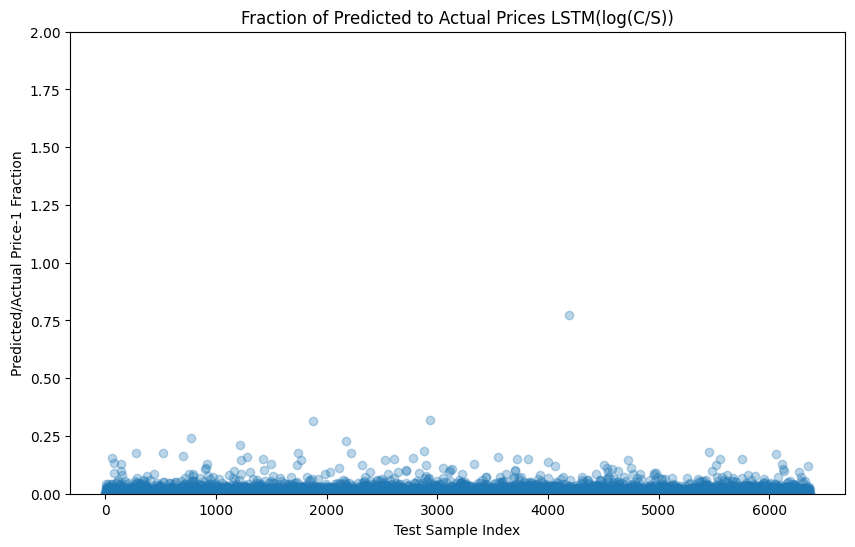

In [97]:
# Resetting the indices to ensure alignment
y_test = y_test.reset_index(drop=True)
y_pred_LSTM= pd.Series(y_pred_LSTM.flatten(), name='Predictions')
#frac_ML = pd.DataFrame({'Actual':y_test, 'Predicted': y_pred_ML})
# Combine them into a DataFrame
frac_LSTM_garch_log = pd.DataFrame({'Actual':(y_test), 'Predicted': (y_pred_LSTM)})




y_testf = frac_LSTM_garch_log['Actual'].values
y_predf = frac_LSTM_garch_log['Predicted'].values

# Calculate the fractions
fractionsf = y_predf / y_testf-1

# Print statistics for fractions
print("fractions statistics")
print("Min:", np.min(fractionsf))
print("Max:", np.max(fractionsf))
print("Mean:", np.mean(fractionsf))
print("Std:", np.std(fractionsf))

# Plot the fractions
plt.figure(figsize=(10, 6))
plt.plot(fractionsf, 'o', alpha=0.3)
plt.xlabel('Test Sample Index')
plt.ylabel('Predicted/Actual Price-1 Fraction')
plt.title('Fraction of Predicted to Actual Prices LSTM(log(C/S))')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

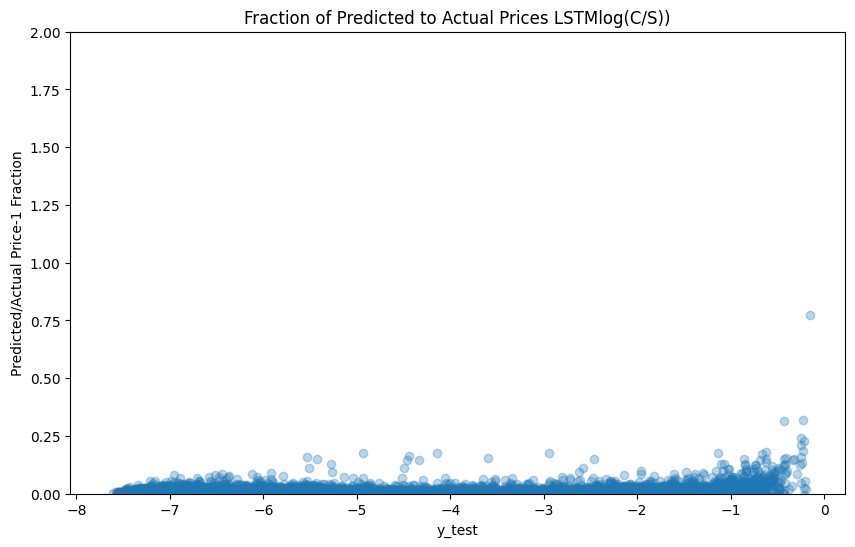

In [177]:
y_testf = frac_LSTM_garch_log['Actual'].values
y_predf = frac_LSTM_garch_log['Predicted'].values

# Calculate the fractions
fractionsf = y_predf / y_testf-1
# Plot the fractions
plt.figure(figsize=(10, 6))
plt.plot(y_testf,fractionsf, 'o', alpha=0.3)
plt.xlabel('y_test')
plt.ylabel('Predicted/Actual Price-1 Fraction')
plt.title('Fraction of Predicted to Actual Prices LSTMlog(C/S))')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

# GRU LOG

In [63]:
feature_columns = ['IV', 'K/S', 'Maturity', 'r', 'cond_vol']
target_column = 'C/S'

In [64]:
# Split the data into features and target
X = data[feature_columns]
y = log(data[target_column])

In [65]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [66]:
# Scale the data

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the data for LSTM
X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [67]:



def create_gru_model():
    model = Sequential()
    model.add(GRU(units=100, return_sequences=True, input_shape=(1, 5)))
    
    model.add(GRU(units=100, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(units=50, activation='elu'))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

gru_model_garch_log = create_gru_model()
gru_history_garch_log = gru_model_garch_log.fit(X_train_lstm, y_train, epochs=150, batch_size=16, verbose=0)

# Evaluate the model
train_loss = gru_model_garch_log.evaluate(X_train_lstm, y_train, verbose=0)
test_loss = gru_model_garch_log.evaluate(X_test_lstm, y_test, verbose=0)

C:\Users\spin 3\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


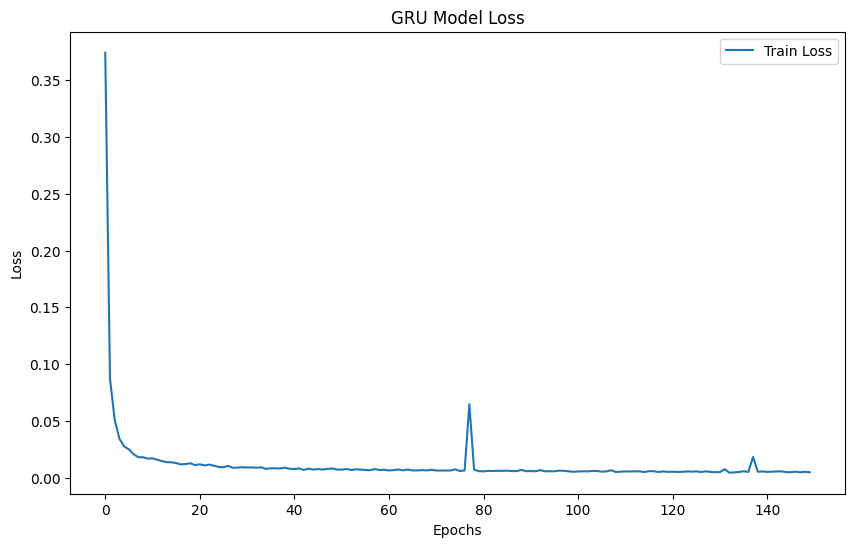

Train Loss: 0.010076194070279598
Test Loss: 0.010862745344638824


In [180]:
# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(gru_history_garch_log.history['loss'], label='Train Loss')
plt.title('GRU Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(f'Train Loss: {train_loss}')
print(f'Test Loss: {test_loss}')


In [181]:
final_loss = gru_history_garch_log.history['loss'][-1]
print(f"   Last log loss: {final_loss:.10f}")
y_pred_gru = gru_model_garch_log.predict(X_test_lstm)
rmse_LSTM = np.sqrt(mean_squared_error(y_test,y_pred_gru))
mae_LSTM = mean_absolute_error(y_test, y_pred_gru)
mse_LSTM = mean_squared_error(y_test,y_pred_gru)
r2_lstm = r2_score(y_test, y_pred_gru)
print(f"LSTM R-squared: {r2_lstm:.3f}")
print(f"   MSA: {rmse_LSTM:.10f}")
print(f"   MAE: {mae_LSTM :.10f}")
print(f"   MSE: {mse_LSTM :.10f}") 

   Last log loss: 0.0047470173
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
LSTM R-squared: 0.997
   MSA: 0.1042244912
   MAE: 0.0608744087
   MSE: 0.0108627446


In [161]:
final_loss = gru_history_garch_log.history['loss'][-1]
print(f"   Last log loss: {final_loss:.10f}")
y_pred_gru = gru_model_garch_log.predict(X_test_lstm)
rmse_LSTM = np.sqrt(mean_squared_error(y_test,y_pred_gru))
mae_LSTM = mean_absolute_error(y_test, y_pred_gru)
mse_LSTM = mean_squared_error(y_test,y_pred_gru)
r2_lstm = r2_score(y_test, y_pred_gru)
print(f"LSTM R-squared: {r2_lstm:.3f}")
print(f"   MSA: {rmse_LSTM:.10f}")
print(f"   MAE: {mae_LSTM :.10f}")
print(f"   MSE: {mse_LSTM :.10f}") 

   Last log loss: 0.0039024230
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
LSTM R-squared: 0.844
   MSA: 0.7202486296
   MAE: 0.5725166743
   MSE: 0.5187580885


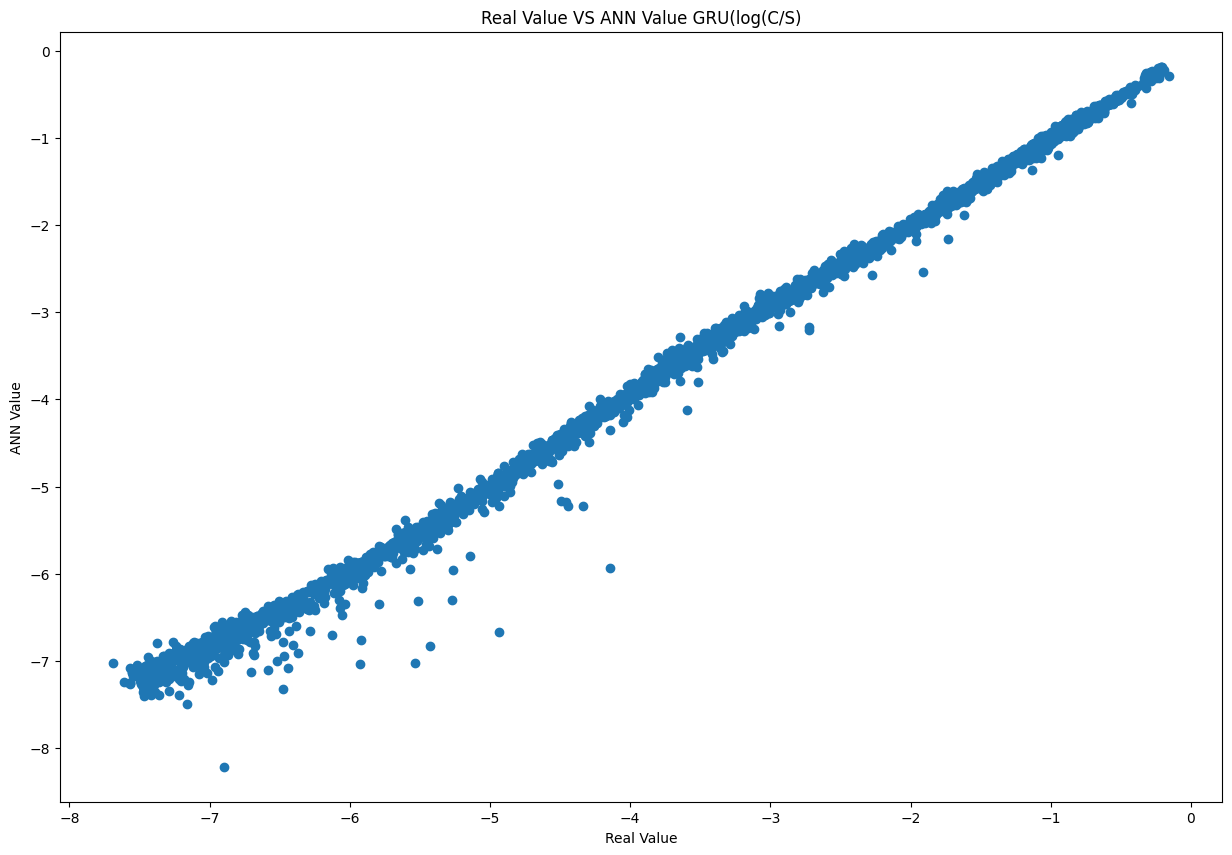

In [182]:
# Comparison of real values and predictions on the test dataset
plt.figure(figsize=(15, 10))
plt.scatter(y_test, y_pred_gru)
plt.xlabel("Real Value")
plt.ylabel("ANN Value")

plt.title('Real Value VS ANN Value GRU(log(C/S)')
plt.show()

In [183]:
# Resetting the indices to ensure alignment
y_test = y_test.reset_index(drop=True)
y_pred_gru= pd.Series(y_pred_gru.flatten(), name='Predictions')
#frac_ML = pd.DataFrame({'Actual':y_test, 'Predicted': y_pred_ML})
# Combine them into a DataFrame
frac_gru_garch_log = pd.DataFrame({'Actual':(y_test), 'Predicted': (y_pred_gru)})

fractions statistics
Min: -0.21284958282087973
Max: 0.8614464598331446
Mean: -0.004948175899700379
Std: 0.032963241550367416


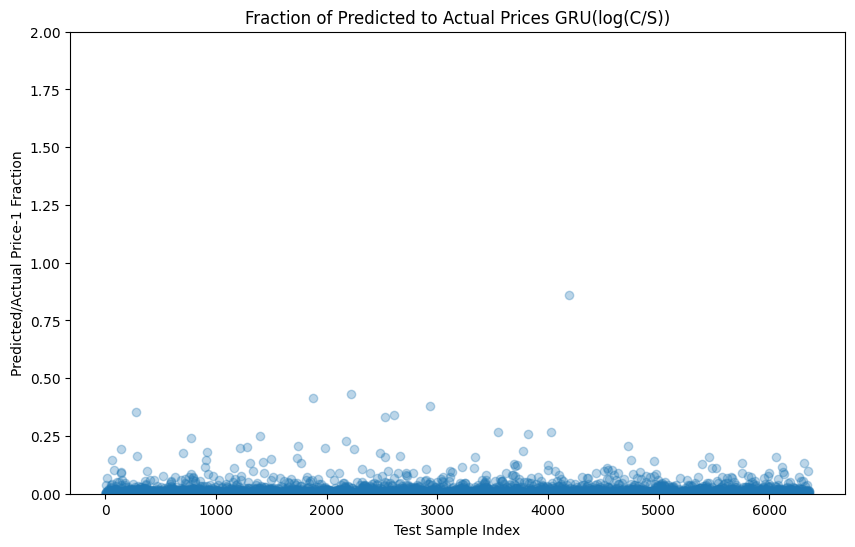

In [184]:


y_testf = frac_gru_garch_log['Actual'].values
y_predf = frac_gru_garch_log['Predicted'].values

# Calculate the fractions
fractionsf = y_predf / y_testf-1

# Print statistics for fractions
print("fractions statistics")
print("Min:", np.min(fractionsf))
print("Max:", np.max(fractionsf))
print("Mean:", np.mean(fractionsf))
print("Std:", np.std(fractionsf))

# Plot the fractions
plt.figure(figsize=(10, 6))
plt.plot(fractionsf, 'o', alpha=0.3)
plt.xlabel('Test Sample Index')
plt.ylabel('Predicted/Actual Price-1 Fraction')
plt.title('Fraction of Predicted to Actual Prices GRU(log(C/S))')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

fractions statistics
Min: -0.21284958282087973
Max: 0.8614464598331446
Mean: -0.004948175899700379
Std: 0.032963241550367416


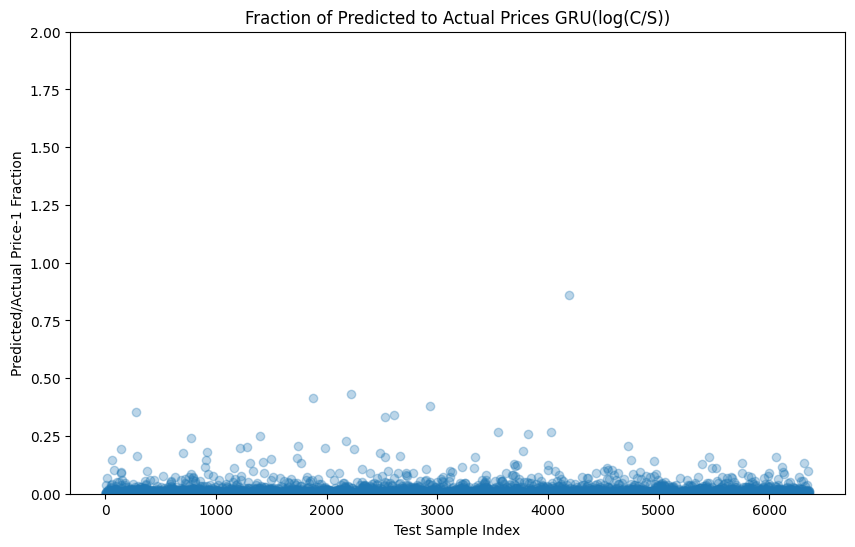

In [185]:





y_testf = frac_gru_garch_log['Actual'].values
y_predf = frac_gru_garch_log['Predicted'].values

# Calculate the fractions
fractionsf = y_predf / y_testf-1

# Print statistics for fractions
print("fractions statistics")
print("Min:", np.min(fractionsf))
print("Max:", np.max(fractionsf))
print("Mean:", np.mean(fractionsf))
print("Std:", np.std(fractionsf))

# Plot the fractions
plt.figure(figsize=(10, 6))
plt.plot(fractionsf, 'o', alpha=0.3)
plt.xlabel('Test Sample Index')
plt.ylabel('Predicted/Actual Price-1 Fraction')
plt.title('Fraction of Predicted to Actual Prices GRU(log(C/S))')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

fractions statistics
Min: -0.21284958282087973
Max: 0.8614464598331446
Mean: -0.004948175899700379
Std: 0.032963241550367416


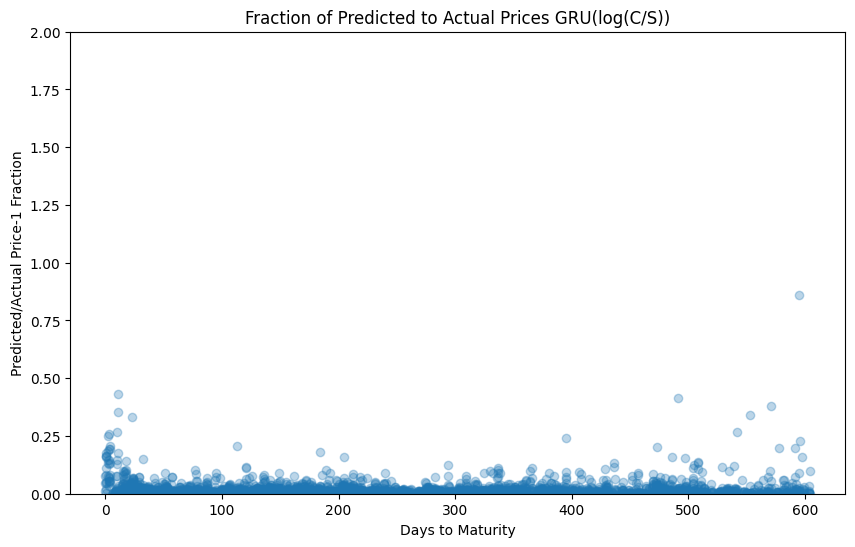

In [186]:

# Print statistics for fractions
print("fractions statistics")
print("Min:", np.min(fractionsf))
print("Max:", np.max(fractionsf))
print("Mean:", np.mean(fractionsf))
print("Std:", np.std(fractionsf))

# Plot the fractions
plt.figure(figsize=(10, 6))
plt.plot(X_test['Maturity'].values*252,fractionsf, 'o', alpha=0.3)
plt.xlabel('Days to Maturity')
plt.ylabel('Predicted/Actual Price-1 Fraction')
plt.title('Fraction of Predicted to Actual Prices GRU(log(C/S))')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

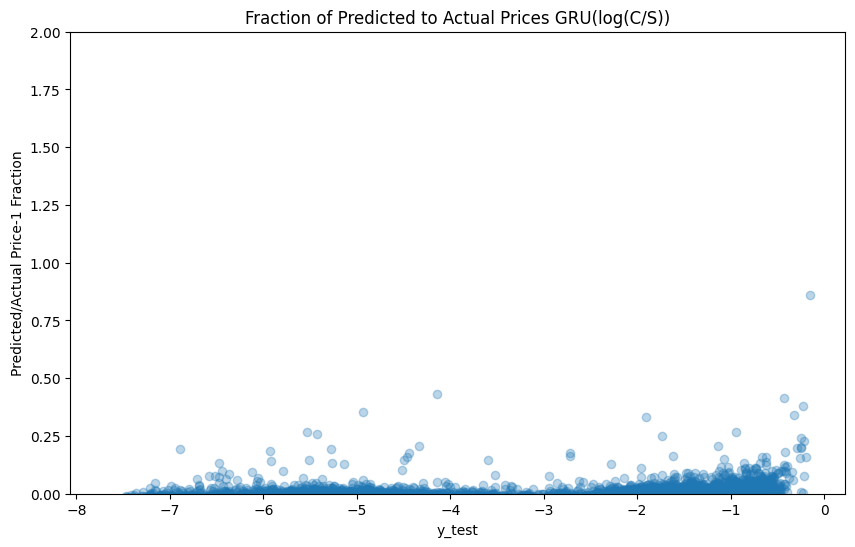

In [187]:
y_testf = frac_gru_garch_log['Actual'].values
y_predf = frac_gru_garch_log['Predicted'].values

# Calculate the fractions
fractionsf = y_predf / y_testf-1
# Plot the fractions
plt.figure(figsize=(10, 6))
plt.plot(y_testf,fractionsf, 'o', alpha=0.3)
plt.xlabel('y_test')
plt.ylabel('Predicted/Actual Price-1 Fraction')
plt.title('Fraction of Predicted to Actual Prices GRU(log(C/S))')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

# test data 

In [41]:
data2 = combined_test.copy()

data2.sort_values(by='Time', inplace=True)
data2.reset_index(drop=True, inplace=True)

In [42]:
data2_250 = df20240315_25000.copy()

In [39]:

def categorize_maturity(maturity):
    if maturity > 280/252:
        return "Long-term"
    elif 110/252 < maturity <= 280/252:
        return "Medium-term"
    else:
        return "Short-term"
data2['Maturity_State'] = data2['Maturity'].apply(categorize_maturity)   

In [40]:
 
    
# Define the categories
conditions = [
    (data2['Monyness'] < 0.95),
    (data2['Monyness'] >= 0.95) & (data2['Monyness'] <= 1.05),
    (data2['Monyness'] > 1.05)
]
choices = ['OTM', 'ATM', 'ITM']

# Create a new column for the categories
data2['Category'] = pd.Categorical(pd.cut(data2['Monyness'], bins=[0, 0.95, 1.05, float('inf')], labels=['OTM', 'NTM', 'ITM'], right=False))
data2.shape

(10198, 13)

In [44]:
 
    
# Define the categories
conditions = [
    (data2_250['Monyness'] < 0.95),
    (data2_250['Monyness'] >= 0.95) & (data2_250['Monyness'] <= 1.05),
    (data2_250['Monyness'] > 1.05)
]
choices = ['OTM', 'ATM', 'ITM']

# Create a new column for the categories
data2_250['Category'] = pd.Categorical(pd.cut(data2_250['Monyness'], bins=[0, 0.95, 1.05, float('inf')], labels=['OTM', 'NTM', 'ITM'], right=False))
data2_250.shape


(378, 12)

In [55]:
data2_250['Maturity_State'] = data2_250['Maturity'].apply(categorize_maturity) 

In [56]:
import numpy as np

# Extract necessary columns
C_t = data2['option_price']
S_t = data2['underlying_stockprice']
K = data2['Strike']
r = data2['r']
T_t = data2['Maturity']

# Calculate the right-hand side of the inequality S_t - K * exp(-r * T_t)
inequality_rhs = S_t - K * np.exp(-r * T_t)

# Apply the inequality condition to filter the rows

# Calculate S_t / K
S_K_ratio = S_t / K





In [60]:
# Calculate log returns of the underlying stock prices
data2_250['log_return'] = np.log(data2_250['underlying_stockprice'] / data2_250['underlying_stockprice'].shift(1))
data2_250 = data2_250.dropna()



# Fit a GARCH(1,1) model
returns = data2_250['log_return'].values
model = arch_model(returns, vol='Garch', p=1, q=1)
garch_fit = model.fit(disp='off')
data2_250['cond_vol'] = garch_fit.conditional_volatility

C:\Users\spin 3\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.004477. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\spin 3\AppData\Local\Temp\ipykernel_16916\462659636.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2_250['cond_vol'] = garch_fit.conditional_volatility


In [58]:
feature_columns = ['IV', 'K/S', 'Maturity', 'r', 'cond_vol']
target_column = 'C/S'

In [91]:
feature_columns = ['IV', 'K/S', 'Maturity', 'r']
target_column = 'C/S'

In [68]:
# Split the data into features and target
X = data2_250[feature_columns]
y = log(data2_250[target_column])

In [93]:
# Split the data into features and target
X = data2[feature_columns]
y = data2[target_column]

In [69]:
# Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)


# Reshape the data for LSTM
X_lstm = np.reshape(X, (X.shape[0], 1, X.shape[1]))


In [ ]:
y_pred_ML_GARCH_test =gru_model_garch_log.predict(X)

In [ ]:
y_pred_ML_GARCH_test = model_ML_garch_log.predict(X)

In [ ]:
newper_log = pd.Series(y_pred_ML_GARCH_test.flatten(), name='Predictions')
# Combine them into a DataFrame



In [ ]:
y = y.reset_index(drop=True)

In [ ]:

frac_test_ML_GARCH = pd.DataFrame({'Actual': y , 'Predicted': newper_log})
y_testf = frac_test_ML_GARCH['Actual'].values
y_predf = frac_test_ML_GARCH['Predicted'].values

# Calculate the fractions
fractionsf = y_predf / y_testf-1
data2['fractions_ML_GARCH'] = frac_test_ML_GARCH['Predicted'] / frac_test_ML_GARCH['Actual'] -1

In [151]:
nan_counts = frac_test_lstm .isna().sum()

print(nan_counts)

Actual       0
Predicted    0
dtype: int64


In [60]:
data2.head(5)

Time  option_price  Volume      IV  underlying_stockprice  Strike  \
49 2022-11-28        105.55     1.0  0.7244                 182.92   100.0   
50 2022-11-30        100.41     4.0  0.7020                 194.70   100.0   
51 2022-12-01        110.97     2.0  0.7105                 194.70   100.0   
52 2022-12-06         96.15    69.0  0.6759                 179.82   100.0   
53 2022-12-07         91.05    47.0  0.6783                 174.04   100.0   

         r  Maturity       C/S  Monyness       K/S Category Maturity_State  \
49  0.0516  1.876984  0.577028    1.8292  0.546687      ITM      Long-term   
50  0.0516  1.869048  0.515716    1.9470  0.513611      ITM      Long-term   
51  0.0516  1.865079  0.569954    1.9470  0.513611      ITM      Long-term   
52  0.0516  1.845238  0.534701    1.7982  0.556112      ITM      Long-term   
53  0.0516  1.841270  0.523156    1.7404  0.574581      ITM      Long-term   

    log_return  cond_vol  fractions  
49   -0.001530  0.052791  -0.196459  
50    0.062411  0.052319  -0.158300  
51    0.000000  0.052234  -0.181566  
52   -0.079504  0.051773  -0.170011  
53   -0.032671  0.051932  -0.173386

In [208]:
y_pred_ML_log_test =model_ML_log.predict(X)


319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step


In [233]:
y_ML_test =model_ML.predict(X)

263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step


In [236]:
newper_log = pd.Series(y_pred_ML_log_test.flatten(), name='Predictions')

In [213]:
y = y.reset_index(drop=True)

In [ ]:
frac_test_ML_log = pd.DataFrame({'Actual': y , 'Predicted': newper_log})
y_testf = frac_test_ML_log['Actual'].values
y_predf = frac_test_ML_log['Predicted'].values

# Calculate the fractions
fractionsf = y_predf / y_testf-1
data2['fractions_ML_LOG'] = frac_test_ML_log['Predicted'] / frac_test_ML['Actual'] -1

In [239]:
data2 = data2[data2['Maturity'] > 14/ 252 ] 
data2 = data2[data2['Maturity'] < 2 ]
data2 = data2[C_t >= inequality_rhs]
data2 = data2[(S_K_ratio >= 0.5) & (S_K_ratio <= 1.55)]
data2 = data2[data2['C/S'] != 1 ]
data2.sort_values(by='Time', inplace=True)
data2.reset_index(drop=True, inplace=True)
data2_Long_term = data2[data2['Maturity_State']== 'Long-term']
data2_Medium_term = data2[data2['Maturity_State']== 'Medium-term']
data2_Short_term = data2[data2['Maturity_State']== 'Short-term']
data2_Long_term= data2_Long_term.reset_index(drop=True)
data2_Medium_term= data2_Medium_term.reset_index(drop=True)
data2_Short_term= data2_Short_term.reset_index(drop=True)

C:\Users\spin 3\AppData\Local\Temp\ipykernel_23740\2662137941.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data2 = data2[C_t >= inequality_rhs]
C:\Users\spin 3\AppData\Local\Temp\ipykernel_23740\2662137941.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data2 = data2[(S_K_ratio >= 0.5) & (S_K_ratio <= 1.55)]


In [ ]:
data2.describe()

fractions statistics
Min: -0.4058607421634651
Max: 0.4885273950187745
Mean: 0.22747218075724265
Std: 0.12567419025418478


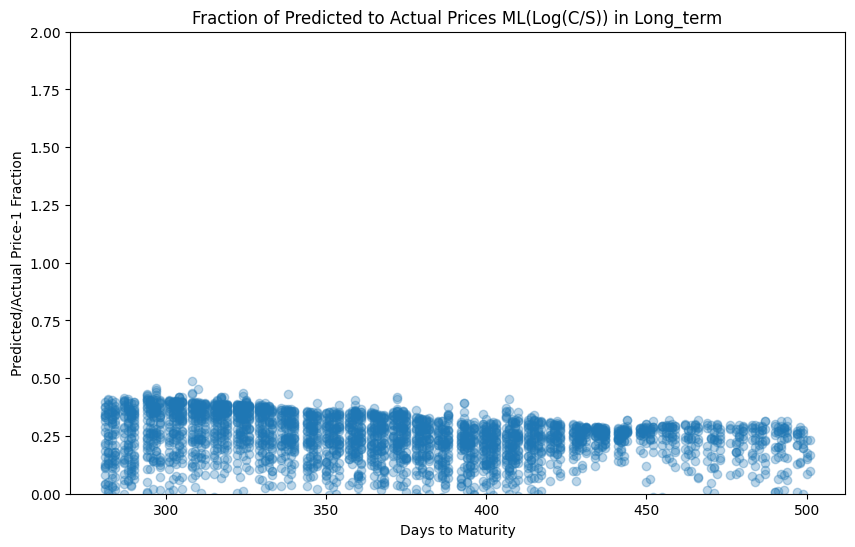

In [171]:
# Print statistics for fractions
print("fractions statistics")
print("Min:", min(data2_Long_term['fractions_ML_LOG']))
print("Max:", max(data2_Long_term['fractions_ML_LOG']))
print("Mean:", (data2_Long_term['fractions_ML_LOG']).mean())
print("Std:", (data2_Long_term['fractions_ML_LOG']).std())
      
plt.figure(figsize=(10, 6))
plt.plot(data2_Long_term['Maturity'].values*252,data2_Long_term['fractions_ML_LOG'], 'o', alpha=0.3)
plt.xlabel('Days to Maturity')
plt.ylabel('Predicted/Actual Price-1 Fraction')
plt.title('Fraction of Predicted to Actual Prices ML(Log(C/S)) in Long_term')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

In [246]:
df20240315_25000

Time  option_price  Volume      IV  underlying_stockprice  Strike  \
0   2022-07-20        532.50     2.0  0.8047                 742.50   250.0   
1   2022-07-21        585.70     2.0  0.8240                 815.12   250.0   
8   2022-08-01        672.60     2.0  0.7914                 891.83   250.0   
9   2022-08-02        684.00     8.0  0.8090                 901.76   250.0   
10  2022-08-03        705.95    21.0  0.8331                 922.19   250.0   
..         ...           ...     ...     ...                    ...     ...   
402 2024-02-26          0.30  5946.0  0.5486                 199.40   250.0   
403 2024-02-27          0.23  4425.0  0.5381                 199.73   250.0   
404 2024-02-28          0.23  3743.0  0.5313                 202.04   250.0   
405 2024-02-29          0.15  2996.0  0.5167                 201.88   250.0   
406 2024-03-01          0.12  3515.0  0.5114                 202.64   250.0   

          r  Maturity       C/S  Monyness       K/S  
0    0.0516  2.396825  0.717172   2.97000  0.336700  
1    0.0516  2.392857  0.718545   3.26048  0.306703  
8    0.0516  2.349206  0.754180   3.56732  0.280322  
9    0.0516  2.345238  0.758517   3.60704  0.277236  
10   0.0516  2.341270  0.765515   3.68876  0.271094  
..      ...       ...       ...       ...       ...  
402  0.0516  0.071429  0.001505   0.79760  1.253761  
403  0.0516  0.067460  0.001152   0.79892  1.251690  
404  0.0516  0.063492  0.001138   0.80816  1.237379  
405  0.0516  0.059524  0.000743   0.80752  1.238359  
406  0.0516  0.055556  0.000592   0.81056  1.233715  

[378 rows x 11 columns]

In [71]:
# Calculate log returns of the underlying stock prices
data2_250['log_return'] = np.log(data2_250['underlying_stockprice'] / data2_250['underlying_stockprice'].shift(1))
data2_250 = data2_250.dropna()



# Fit a GARCH(1,1) model
returns = data2_250['log_return'].values
model = arch_model(returns, vol='Garch', p=1, q=1)
garch_fit = model.fit(disp='off')
data2_250['cond_vol'] = garch_fit.conditional_volatility

C:\Users\spin 3\AppData\Local\Temp\ipykernel_16916\462659636.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2_250['log_return'] = np.log(data2_250['underlying_stockprice'] / data2_250['underlying_stockprice'].shift(1))
C:\Users\spin 3\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.004464. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [72]:
feature_columns = ['IV', 'K/S', 'Maturity', 'r', 'cond_vol']
target_column = 'C/S'

In [73]:
# Split the data into features and target
X = scaler.fit_transform(data2_250[feature_columns])
y = log(data2_250[target_column])

In [ ]:
y_pred_ML_GARCH_test =gru_model_garch_log.predict(X)

In [ ]:
newper_log = pd.Series(y_pred_ML_GARCH_test.flatten(), name='Predictions')
# Combine them into a DataFrame
y = y.reset_index(drop=True)
frac_test_ML_GARCH = pd.DataFrame({'Actual': y , 'Predicted': newper_log})
y_testf = frac_test_ML_GARCH['Actual'].values
y_predf = frac_test_ML_GARCH['Predicted'].values

# Calculate the fractions
fractionsf = y_predf / y_testf-1
data2_250['fractions_ML_GARCH'] = frac_test_ML_GARCH['Predicted'] / frac_test_ML_GARCH['Actual'] -1


In [ ]:
data2_250['pred'] = frac_test_ML_GARCH['Predicted']

In [ ]:
data2_250 = data2_250[data2_250['Maturity'] > 14/ 252 ] 
data2_250 = data2_250[data2_250['Maturity'] < 1.5 ]
#data2_250 = data2_250[C_t >= inequality_rhs]
#data2 = data2[(S_K_ratio >= 0.5) & (S_K_ratio <= 1.55)]
data2_250 = data2_250[data2_250['C/S'] != 1 ]
data2_250.sort_values(by='Time', inplace=True)
data2_250.reset_index(drop=True, inplace=True)
data2_250_Long_term = data2_250[data2_250['Maturity_State']== 'Long-term']
data2_250_Medium_term = data2_250[data2_250['Maturity_State']== 'Medium-term']
data2_250_Short_term = data2_250[data2_250['Maturity_State']== 'Short-term']
data2otm_250 = data2_250[data2_250['Category']== 'OTM']
data2ntm_250 = data2_250[data2_250['Category']== 'NTM']
data2itm_250 = data2_250[data2_250['Category']== 'ITM']
data2_250_Long_term= data2_250_Long_term.reset_index(drop=True)
data2_250_Medium_term= data2_250_Medium_term.reset_index(drop=True)
data2_250_Short_term= data2_250_Short_term.reset_index(drop=True)

data2otm_250= data2otm_250.reset_index(drop=True)
data2ntm_250= data2ntm_250.reset_index(drop=True)
data2itm_250= data2itm_250.reset_index(drop=True)

In [64]:
data2_250.shape

(249, 17)

In [60]:
data2_250_Short_term.shape

(65, 17)

In [59]:
data2_250_Medium_term.shape

(117, 17)

In [57]:
data2_250_Long_term.shape

(67, 17)

In [61]:
data2otm_250.shape

(139, 17)

In [62]:
data2ntm_250.shape

(80, 17)

In [63]:
data2itm_250.shape

(30, 17)

In [ ]:
print("fractions statistics")
print("Min:", min(data2_250['fractions_ML_GARCH']))
print("Max:", max(data2_250['fractions_ML_GARCH']))
print("Mean:", (data2_250['fractions_ML_GARCH']).mean())
print("Std:", (data2_250['fractions_ML_GARCH']).std())
plt.figure(figsize=(10, 6))
plt.plot(data2_250['Maturity'].values*252,data2_250['fractions_ML_GARCH'], 'o', alpha=0.3)
plt.xlabel('DAYs to Maturity')
plt.ylabel('Predicted/Actual Price-1 Fraction')
plt.title('Fraction of Predicted to Actual Prices ML(Log(C/S))')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

fractions statistics
Min: -0.016357599568413872
Max: 0.8879800959461357
Mean: 0.35414890449601444
Std: 0.219071698965692


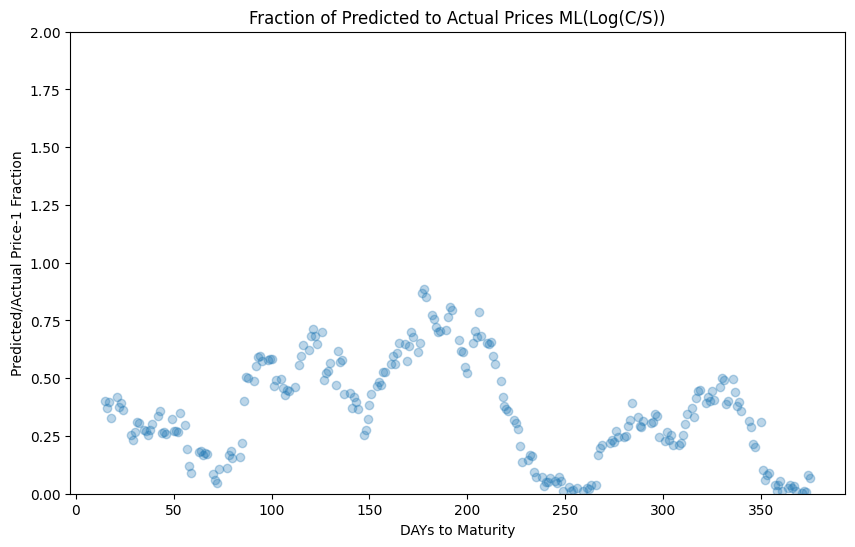

In [262]:
print("fractions statistics")
print("Min:", min(data2_250['fractions_ML_GARCH']))
print("Max:", max(data2_250['fractions_ML_GARCH']))
print("Mean:", (data2_250['fractions_ML_GARCH']).mean())
print("Std:", (data2_250['fractions_ML_GARCH']).std())
plt.figure(figsize=(10, 6))
plt.plot(data2_250['Maturity'].values*252,data2_250['fractions_ML_GARCH'], 'o', alpha=0.3)
plt.xlabel('DAYs to Maturity')
plt.ylabel('Predicted/Actual Price-1 Fraction')
plt.title('Fraction of Predicted to Actual Prices ML(Log(C/S))')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

fractions statistics
Min: 0.04501300675273634
Max: 0.5964227994716609
Mean: 0.32063629237397934
Std: 0.14838157443967578


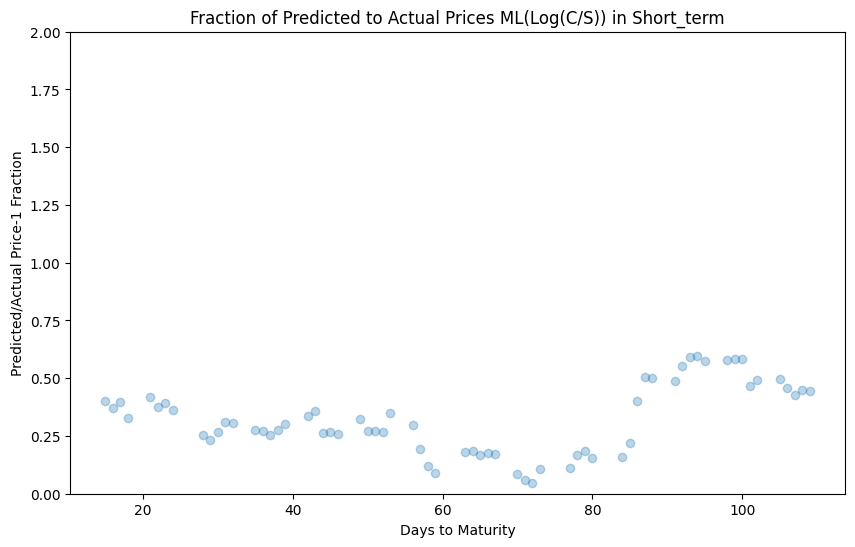

In [263]:
# Print statistics for fractions
print("fractions statistics")
print("Min:", min(data2_250_Short_term['fractions_ML_GARCH']))
print("Max:", max(data2_250_Short_term['fractions_ML_GARCH']))
print("Mean:", (data2_250_Short_term['fractions_ML_GARCH']).mean())
print("Std:", (data2_250_Short_term['fractions_ML_GARCH']).std())
      
plt.figure(figsize=(10, 6))
plt.plot(data2_250_Short_term['Maturity'].values*252,data2_250_Short_term['fractions_ML_GARCH'], 'o', alpha=0.3)
plt.xlabel('Days to Maturity')
plt.ylabel('Predicted/Actual Price-1 Fraction')
plt.title('Fraction of Predicted to Actual Prices ML(Log(C/S)) in Short_term')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

fractions statistics
Min: -0.016357599568413872
Max: 0.8879800959461357
Mean: 0.42968578034267474
Std: 0.2549673443517626


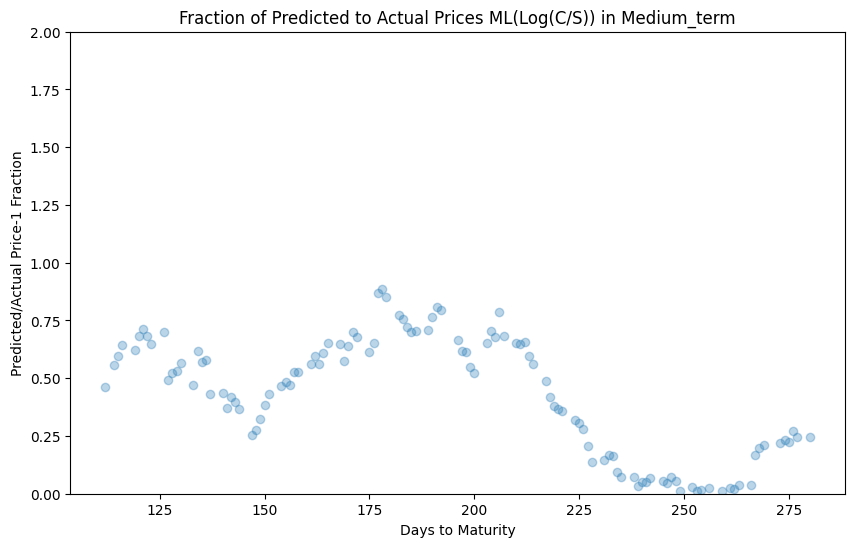

In [264]:

print("fractions statistics")
print("Min:", min(data2_250_Medium_term['fractions_ML_GARCH']))
print("Max:", max(data2_250_Medium_term['fractions_ML_GARCH']))
print("Mean:", (data2_250_Medium_term['fractions_ML_GARCH']).mean())
print("Std:", (data2_250_Medium_term['fractions_ML_GARCH']).std())
      
plt.figure(figsize=(10, 6))
plt.plot(data2_250_Medium_term['Maturity'].values*252,data2_250_Medium_term['fractions_ML_GARCH'], 'o', alpha=0.3)
plt.xlabel('Days to Maturity')
plt.ylabel('Predicted/Actual Price-1 Fraction')
plt.title('Fraction of Predicted to Actual Prices ML(Log(C/S)) in Medium_term')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()

fractions statistics
Min: 0.002557333580590848
Max: 0.5008250038439943
Mean: 0.25475346141949246
Std: 0.15322541908109474


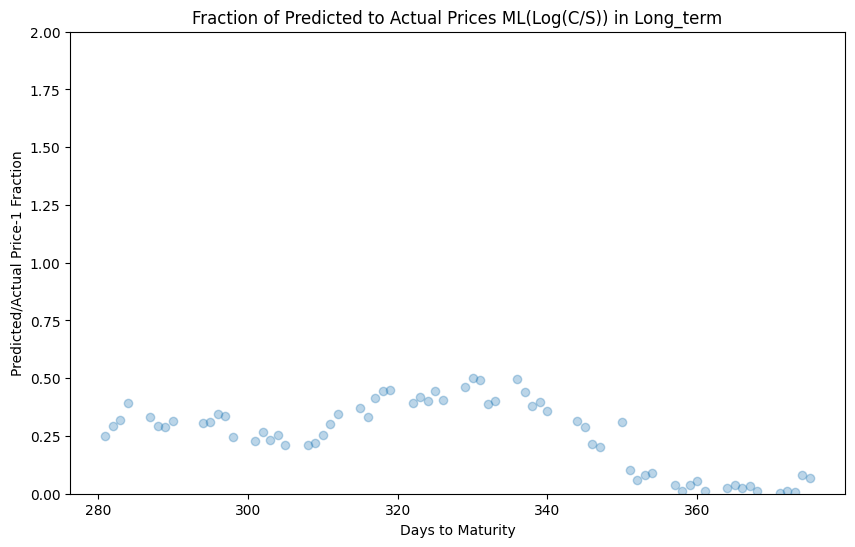

In [265]:
# Print statistics for fractions
print("fractions statistics")
print("Min:", min(data2_250_Long_term['fractions_ML_GARCH']))
print("Max:", max(data2_250_Long_term['fractions_ML_GARCH']))
print("Mean:", (data2_250_Long_term['fractions_ML_GARCH']).mean())
print("Std:", (data2_250_Long_term['fractions_ML_GARCH']).std())
      
plt.figure(figsize=(10, 6))
plt.plot(data2_250_Long_term['Maturity'].values*252,data2_250_Long_term['fractions_ML_GARCH'], 'o', alpha=0.3)
plt.xlabel('Days to Maturity')
plt.ylabel('Predicted/Actual Price-1 Fraction')
plt.title('Fraction of Predicted to Actual Prices ML(Log(C/S)) in Long_term')
plt.ylim(0, 2)  # Limit the y-axis for better visualization if needed
plt.show()